# Test of different network architectures using Keras/Tensorflow
## Import libraries

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import numpy as np
from visuals import plot_field_and_error
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

/home/andre/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load numerical training data

In [2]:
fullDataPath = "./fullRawData/"
fieldName50 = "A50.dat"
fieldName200 = "A200.dat"
fieldName400 = "A400.dat"

# skip column 2 - z is constant (2D)
colNames = ["x", "y", "z", "A"]
columns = [0, 1, 3]

# read full numerical solution (interal field + boundaries)
field50 = pd.read_csv(fullDataPath + fieldName50, sep='\t', names=colNames, header=0, usecols=columns)
field200 = pd.read_csv(fullDataPath + fieldName200, sep='\t', names=colNames, header=0, usecols=columns)
field400 = pd.read_csv(fullDataPath + fieldName400, sep='\t', names=colNames, header=0, usecols=columns)
field200.tail()

x    y         A
40795  0.9775  1.0  0.000836
40796  0.9825  1.0  0.000648
40797  0.9875  1.0  0.000462
40798  0.9925  1.0  0.000277
40799  0.9975  1.0  0.000092

## Examples for how to define a custom loss function

In [3]:
from keras import backend as K
# Using the sum of the squared error
def custom_loss(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true))

# Using a penalty factor for certain points
def penalized_loss(penalty):
    def loss(y_true, y_pred):
        return K.mean(K.square((y_pred - y_true) * penalty), axis=1)
    return loss

## Training

In [4]:
x_train = np.column_stack((field200.x, field200.y))
penalty = np.full((len(x_train), 1), 1.0) 
for p, point in enumerate(x_train):
    if point[0] < 1.0E-9 or point[1] < 1.0E-9:
        penalty[p] = 10.0
penaltyTensor = K.variable(penalty)

In [5]:
from keras import optimizers
# uncomment to use user-defined parameters for Adam optimizer
# adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
models = []
names = []
for units in [2, 4, 8, 16, 32]:
    for layers in [1, 2, 3, 4, 5]:
        model = Sequential()
        model.add(Dense(units=units, activation='sigmoid', input_dim=2))
        for add_layer in range(1, layers):
            model.add(Dense(units=units, activation='sigmoid'))
        model.add(Dense(units=1, activation='linear'))
        # uncomment to use a user-defined loss function
        # model.compile(loss=[penalized_loss(penalty=penaltyTensor)], optimizer='adam', metrics=['mae'])
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        model.summary()
        models.append(model)
        names.append(str(units) + "_perceptrons_" + str(layers) + "_hlayers")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
____________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 8)                 24        
_________________________________________________________________
dense_51 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_52 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 9         
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (De

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_91 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_92 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_93 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95

In [17]:
for i, model in enumerate(models):
    filepath = "keras/" + names[i] + "_best_weights.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=100, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    print("Start training of model " + names[i])
    print("-------------------------------------")
    model.fit(x_train, field200.A, epochs=1000, callbacks=callbacks_list, batch_size=64)

Start training of model 2_perceptrons_1_hlayers
-------------------------------------
Epoch 1/1000
40800/40800 [==============================] - 1s 24us/step - loss: 0.0035 - mean_absolute_error: 0.0329

Epoch 00001: loss improved from inf to 0.00354, saving model to keras/2_perceptrons_1_hlayers_best_weights.hdf5
Epoch 2/1000
40800/40800 [==============================] - 1s 24us/step - loss: 0.0035 - mean_absolute_error: 0.0326

Epoch 00002: loss improved from 0.00354 to 0.00350, saving model to keras/2_perceptrons_1_hlayers_best_weights.hdf5
Epoch 3/1000
40800/40800 [==============================] - 1s 25us/step - loss: 0.0035 - mean_absolute_error: 0.0322

Epoch 00003: loss improved from 0.00350 to 0.00347, saving model to keras/2_perceptrons_1_hlayers_best_weights.hdf5
Epoch 4/1000
40800/40800 [==============================] - 1s 25us/step - loss: 0.0034 - mean_absolute_error: 0.0320

Epoch 00004: loss improved from 0.00347 to 0.00344, saving model to keras/2_perceptrons_1_hlay

40800/40800 [==============================] - 1s 25us/step - loss: 0.0015 - mean_absolute_error: 0.0194

Epoch 00070: loss improved from 0.00151 to 0.00151, saving model to keras/2_perceptrons_1_hlayers_best_weights.hdf5
Epoch 71/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0194

Epoch 00071: loss improved from 0.00151 to 0.00151, saving model to keras/2_perceptrons_1_hlayers_best_weights.hdf5
Epoch 72/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0193

Epoch 00072: loss improved from 0.00151 to 0.00150, saving model to keras/2_perceptrons_1_hlayers_best_weights.hdf5
Epoch 73/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0195

Epoch 00073: loss did not improve
Epoch 74/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0194

Epoch 00074: loss improved from 

40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0201

Epoch 00110: loss improved from 0.00148 to 0.00148, saving model to keras/2_perceptrons_1_hlayers_best_weights.hdf5
Epoch 111/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0200

Epoch 00111: loss did not improve
Epoch 112/1000
40800/40800 [==============================] - 1s 24us/step - loss: 0.0015 - mean_absolute_error: 0.0200

Epoch 00112: loss improved from 0.00148 to 0.00148, saving model to keras/2_perceptrons_1_hlayers_best_weights.hdf5
Epoch 113/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0200

Epoch 00113: loss improved from 0.00148 to 0.00148, saving model to keras/2_perceptrons_1_hlayers_best_weights.hdf5
Epoch 114/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0201

Epoch 00114: loss did not im

40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00210: loss did not improve
Epoch 211/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00211: loss did not improve
Epoch 212/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00212: loss did not improve
Epoch 213/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00213: loss did not improve
Epoch 214/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0204

Epoch 00214: loss did not improve
Epoch 215/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0204

Epoch 00215: loss did not improve
Epoch 216/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.

40800/40800 [==============================] - 1s 25us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00262: loss did not improve
Epoch 263/1000
40800/40800 [==============================] - 1s 25us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00263: loss did not improve
Epoch 264/1000
40800/40800 [==============================] - 1s 25us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00264: loss did not improve
Epoch 265/1000
40800/40800 [==============================] - 1s 30us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00265: loss did not improve
Epoch 266/1000
40800/40800 [==============================] - 1s 25us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00266: loss did not improve
Epoch 267/1000
40800/40800 [==============================] - 1s 25us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00267: loss did not improve
Epoch 268/1000
40800/40800 [==============================] - 1s 25us/step - loss: 0.

40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00365: loss did not improve
Epoch 366/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00366: loss did not improve
Epoch 367/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00367: loss did not improve
Epoch 368/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00368: loss did not improve
Epoch 369/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00369: loss did not improve
Epoch 370/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00370: loss did not improve
Epoch 371/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.

40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00417: loss did not improve
Epoch 418/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00418: loss did not improve
Epoch 419/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00419: loss did not improve
Epoch 420/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00420: loss did not improve
Epoch 421/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00421: loss did not improve
Epoch 422/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00422: loss did not improve
Epoch 423/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.

Epoch 470/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00470: loss did not improve
Epoch 471/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00471: loss did not improve
Epoch 472/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00472: loss did not improve
Epoch 473/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00473: loss did not improve
Epoch 474/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00474: loss did not improve
Epoch 475/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00475: loss did not improve
Epoch 476/1000
40800/40800 [==============================] - 1s 23us/

40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00523: loss did not improve
Epoch 524/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00524: loss did not improve
Epoch 525/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00525: loss did not improve
Epoch 526/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00526: loss did not improve
Epoch 527/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00527: loss did not improve
Epoch 528/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00528: loss did not improve
Epoch 529/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.

40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0207

Epoch 00576: loss did not improve
Epoch 577/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00577: loss did not improve
Epoch 578/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00578: loss did not improve
Epoch 579/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00579: loss did not improve
Epoch 580/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00580: loss did not improve
Epoch 581/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00581: loss did not improve
Epoch 582/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.

40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00629: loss did not improve
Epoch 630/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00630: loss did not improve
Epoch 631/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00631: loss did not improve
Epoch 632/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00632: loss did not improve
Epoch 633/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00633: loss did not improve
Epoch 634/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00634: loss did not improve
Epoch 635/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.

40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00734: loss did not improve
Epoch 735/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00735: loss did not improve
Epoch 736/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00736: loss did not improve
Epoch 737/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0207

Epoch 00737: loss did not improve
Epoch 738/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00738: loss did not improve
Epoch 739/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00739: loss did not improve
Epoch 740/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.

40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00787: loss did not improve
Epoch 788/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00788: loss did not improve
Epoch 789/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00789: loss did not improve
Epoch 790/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00790: loss did not improve
Epoch 791/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00791: loss did not improve
Epoch 792/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0205

Epoch 00792: loss did not improve
Epoch 793/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.

40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00892: loss did not improve
Epoch 893/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00893: loss did not improve
Epoch 894/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00894: loss did not improve
Epoch 895/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00895: loss did not improve
Epoch 896/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00896: loss did not improve
Epoch 897/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0207

Epoch 00897: loss did not improve
Epoch 898/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.

40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00996: loss did not improve
Epoch 997/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00997: loss did not improve
Epoch 998/1000
40800/40800 [==============================] - 1s 24us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00998: loss did not improve
Epoch 999/1000
40800/40800 [==============================] - 1s 24us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 00999: loss did not improve
Epoch 1000/1000
40800/40800 [==============================] - 1s 24us/step - loss: 0.0015 - mean_absolute_error: 0.0206

Epoch 01000: loss did not improve
Start training of model 2_perceptrons_2_hlayers
-------------------------------------
Epoch 1/1000
40800/40800 [==============================] - 2s 43us/step - loss: 0.0746 - mean_absolute_error: 0.2206

Epoch 00001: loss improved from in

40800/40800 [==============================] - 1s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0200

Epoch 00067: loss improved from 0.00115 to 0.00114, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 68/1000
40800/40800 [==============================] - 1s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0198

Epoch 00068: loss improved from 0.00114 to 0.00112, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 69/1000
40800/40800 [==============================] - 1s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0195

Epoch 00069: loss improved from 0.00112 to 0.00111, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 70/1000
40800/40800 [==============================] - 1s 25us/step - loss: 0.0011 - mean_absolute_error: 0.0192

Epoch 00070: loss improved from 0.00111 to 0.00109, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 71/1000
40800/40800 [==============================] - 1s 25us/s

40800/40800 [==============================] - 1s 25us/step - loss: 3.3899e-04 - mean_absolute_error: 0.0097

Epoch 00135: loss improved from 0.00034 to 0.00034, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 136/1000
40800/40800 [==============================] - 1s 25us/step - loss: 3.3740e-04 - mean_absolute_error: 0.0097

Epoch 00136: loss improved from 0.00034 to 0.00034, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 137/1000
40800/40800 [==============================] - 1s 25us/step - loss: 3.3403e-04 - mean_absolute_error: 0.0096

Epoch 00137: loss improved from 0.00034 to 0.00033, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 138/1000
40800/40800 [==============================] - 1s 25us/step - loss: 3.3237e-04 - mean_absolute_error: 0.0096

Epoch 00138: loss improved from 0.00033 to 0.00033, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 139/1000
40800/40800 [=======================

40800/40800 [==============================] - 1s 25us/step - loss: 2.6533e-04 - mean_absolute_error: 0.0092

Epoch 00205: loss did not improve
Epoch 206/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.6362e-04 - mean_absolute_error: 0.0091

Epoch 00206: loss did not improve
Epoch 207/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.6346e-04 - mean_absolute_error: 0.0091

Epoch 00207: loss improved from 0.00026 to 0.00026, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 208/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.6171e-04 - mean_absolute_error: 0.0090

Epoch 00208: loss improved from 0.00026 to 0.00026, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 209/1000
40800/40800 [==============================] - 1s 24us/step - loss: 2.6061e-04 - mean_absolute_error: 0.0090

Epoch 00209: loss improved from 0.00026 to 0.00026, saving model to keras/2_perceptrons_2_

40800/40800 [==============================] - 1s 25us/step - loss: 2.2550e-04 - mean_absolute_error: 0.0086

Epoch 00284: loss improved from 0.00023 to 0.00023, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 285/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.2542e-04 - mean_absolute_error: 0.0086

Epoch 00285: loss improved from 0.00023 to 0.00023, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 286/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.2603e-04 - mean_absolute_error: 0.0086

Epoch 00286: loss did not improve
Epoch 287/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.2437e-04 - mean_absolute_error: 0.0086

Epoch 00287: loss improved from 0.00023 to 0.00022, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 288/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.2406e-04 - mean_absolute_error: 0.0086

Epoch 00

40800/40800 [==============================] - 1s 26us/step - loss: 2.1360e-04 - mean_absolute_error: 0.0084

Epoch 00323: loss did not improve
Epoch 324/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.1309e-04 - mean_absolute_error: 0.0084

Epoch 00324: loss improved from 0.00021 to 0.00021, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 325/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.1386e-04 - mean_absolute_error: 0.0085

Epoch 00325: loss did not improve
Epoch 326/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.1280e-04 - mean_absolute_error: 0.0084

Epoch 00326: loss improved from 0.00021 to 0.00021, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 327/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.1273e-04 - mean_absolute_error: 0.0084

Epoch 00327: loss improved from 0.00021 to 0.00021, saving model to keras/2_perceptrons_2_

40800/40800 [==============================] - 1s 25us/step - loss: 1.9738e-04 - mean_absolute_error: 0.0082

Epoch 00406: loss did not improve
Epoch 407/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.9577e-04 - mean_absolute_error: 0.0081

Epoch 00407: loss improved from 0.00020 to 0.00020, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 408/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.9641e-04 - mean_absolute_error: 0.0082

Epoch 00408: loss did not improve
Epoch 409/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.9546e-04 - mean_absolute_error: 0.0081

Epoch 00409: loss improved from 0.00020 to 0.00020, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 410/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.9488e-04 - mean_absolute_error: 0.0081

Epoch 00410: loss improved from 0.00020 to 0.00019, saving model to keras/2_perceptrons_2_

40800/40800 [==============================] - 1s 25us/step - loss: 1.8876e-04 - mean_absolute_error: 0.0080

Epoch 00451: loss improved from 0.00019 to 0.00019, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 452/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.9054e-04 - mean_absolute_error: 0.0081

Epoch 00452: loss did not improve
Epoch 453/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.8847e-04 - mean_absolute_error: 0.0080

Epoch 00453: loss improved from 0.00019 to 0.00019, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 454/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.8865e-04 - mean_absolute_error: 0.0080

Epoch 00454: loss did not improve
Epoch 455/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.8910e-04 - mean_absolute_error: 0.0080

Epoch 00455: loss did not improve
Epoch 456/1000
40800/40800 [============================

40800/40800 [==============================] - 1s 25us/step - loss: 1.8384e-04 - mean_absolute_error: 0.0079

Epoch 00496: loss did not improve
Epoch 497/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.8248e-04 - mean_absolute_error: 0.0079

Epoch 00497: loss improved from 0.00018 to 0.00018, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 498/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.8365e-04 - mean_absolute_error: 0.0079

Epoch 00498: loss did not improve
Epoch 499/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.8275e-04 - mean_absolute_error: 0.0079

Epoch 00499: loss did not improve
Epoch 500/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.8189e-04 - mean_absolute_error: 0.0079

Epoch 00500: loss improved from 0.00018 to 0.00018, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 501/1000
40800/40800 [============================

40800/40800 [==============================] - 1s 25us/step - loss: 1.7854e-04 - mean_absolute_error: 0.0078

Epoch 00541: loss did not improve
Epoch 542/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.7857e-04 - mean_absolute_error: 0.0078

Epoch 00542: loss did not improve
Epoch 543/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.7796e-04 - mean_absolute_error: 0.0078

Epoch 00543: loss did not improve
Epoch 544/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.7767e-04 - mean_absolute_error: 0.0078

Epoch 00544: loss improved from 0.00018 to 0.00018, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 545/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.7750e-04 - mean_absolute_error: 0.0078

Epoch 00545: loss improved from 0.00018 to 0.00018, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 546/1000
40800/40800 [============================

40800/40800 [==============================] - 1s 25us/step - loss: 1.7361e-04 - mean_absolute_error: 0.0077

Epoch 00586: loss improved from 0.00017 to 0.00017, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 587/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.7426e-04 - mean_absolute_error: 0.0077

Epoch 00587: loss did not improve
Epoch 588/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.7459e-04 - mean_absolute_error: 0.0078

Epoch 00588: loss did not improve
Epoch 589/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.7391e-04 - mean_absolute_error: 0.0077

Epoch 00589: loss did not improve
Epoch 590/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.7401e-04 - mean_absolute_error: 0.0077

Epoch 00590: loss did not improve
Epoch 591/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.7299e-04 - mean_absolute_error: 0.0077

Epoch 00591: 

40800/40800 [==============================] - 1s 25us/step - loss: 1.6642e-04 - mean_absolute_error: 0.0076

Epoch 00681: loss did not improve
Epoch 682/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.6733e-04 - mean_absolute_error: 0.0076: 0s - loss: 1.4220e-04 - mean_abs

Epoch 00682: loss did not improve
Epoch 683/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.6681e-04 - mean_absolute_error: 0.0077

Epoch 00683: loss did not improve
Epoch 684/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.6689e-04 - mean_absolute_error: 0.0076

Epoch 00684: loss did not improve
Epoch 685/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.6616e-04 - mean_absolute_error: 0.0076

Epoch 00685: loss improved from 0.00017 to 0.00017, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 686/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.6620e-04 - mean_abs

40800/40800 [==============================] - 1s 26us/step - loss: 1.6288e-04 - mean_absolute_error: 0.0075

Epoch 00728: loss did not improve
Epoch 729/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.6353e-04 - mean_absolute_error: 0.0075

Epoch 00729: loss did not improve
Epoch 730/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.6290e-04 - mean_absolute_error: 0.0075

Epoch 00730: loss did not improve
Epoch 731/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.6318e-04 - mean_absolute_error: 0.0075

Epoch 00731: loss did not improve
Epoch 732/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.6358e-04 - mean_absolute_error: 0.0075

Epoch 00732: loss did not improve
Epoch 733/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.6340e-04 - mean_absolute_error: 0.0075

Epoch 00733: loss did not improve
Epoch 734/1000
40800/40800 [==============================] -

Epoch 777/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.6139e-04 - mean_absolute_error: 0.0075

Epoch 00777: loss did not improve
Epoch 778/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.6086e-04 - mean_absolute_error: 0.0075

Epoch 00778: loss did not improve
Epoch 779/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.6012e-04 - mean_absolute_error: 0.0075

Epoch 00779: loss did not improve
Epoch 780/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.5974e-04 - mean_absolute_error: 0.0074

Epoch 00780: loss improved from 0.00016 to 0.00016, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 781/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.6014e-04 - mean_absolute_error: 0.0075

Epoch 00781: loss did not improve
Epoch 782/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.6099e-04 - mean_absolute_error: 0.0075

40800/40800 [==============================] - 1s 25us/step - loss: 1.5790e-04 - mean_absolute_error: 0.0074

Epoch 00824: loss did not improve
Epoch 825/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.5887e-04 - mean_absolute_error: 0.0074

Epoch 00825: loss did not improve
Epoch 826/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.5656e-04 - mean_absolute_error: 0.0074

Epoch 00826: loss improved from 0.00016 to 0.00016, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 827/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.5852e-04 - mean_absolute_error: 0.0074

Epoch 00827: loss did not improve
Epoch 828/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.5693e-04 - mean_absolute_error: 0.0074

Epoch 00828: loss did not improve
Epoch 829/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.5810e-04 - mean_absolute_error: 0.0074

Epoch 00829: 

40800/40800 [==============================] - 1s 25us/step - loss: 1.5349e-04 - mean_absolute_error: 0.0073

Epoch 00919: loss did not improve
Epoch 920/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.5308e-04 - mean_absolute_error: 0.0073: 1s - loss: 1.6320e-04 - mean_abs

Epoch 00920: loss did not improve
Epoch 921/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.5209e-04 - mean_absolute_error: 0.0072

Epoch 00921: loss improved from 0.00015 to 0.00015, saving model to keras/2_perceptrons_2_hlayers_best_weights.hdf5
Epoch 922/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.5311e-04 - mean_absolute_error: 0.0073

Epoch 00922: loss did not improve
Epoch 923/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.5213e-04 - mean_absolute_error: 0.0073

Epoch 00923: loss did not improve
Epoch 924/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.5233e-04 - mean_abs

40800/40800 [==============================] - 1s 26us/step - loss: 0.0028 - mean_absolute_error: 0.0280

Epoch 00009: loss improved from 0.00289 to 0.00278, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 10/1000
40800/40800 [==============================] - 1s 26us/step - loss: 0.0027 - mean_absolute_error: 0.0279

Epoch 00010: loss improved from 0.00278 to 0.00275, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 11/1000
40800/40800 [==============================] - 1s 26us/step - loss: 0.0027 - mean_absolute_error: 0.0276

Epoch 00011: loss improved from 0.00275 to 0.00271, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 12/1000
40800/40800 [==============================] - 1s 26us/step - loss: 0.0027 - mean_absolute_error: 0.0272

Epoch 00012: loss improved from 0.00271 to 0.00266, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 13/1000
40800/40800 [==============================] - 1s 27us/s

Epoch 44/1000
40800/40800 [==============================] - 1s 26us/step - loss: 6.2354e-04 - mean_absolute_error: 0.0126

Epoch 00044: loss improved from 0.00063 to 0.00062, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 45/1000
40800/40800 [==============================] - 1s 26us/step - loss: 6.1260e-04 - mean_absolute_error: 0.0124

Epoch 00045: loss improved from 0.00062 to 0.00061, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 46/1000
40800/40800 [==============================] - 1s 26us/step - loss: 6.0299e-04 - mean_absolute_error: 0.0124

Epoch 00046: loss improved from 0.00061 to 0.00060, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 47/1000
40800/40800 [==============================] - 1s 26us/step - loss: 5.9290e-04 - mean_absolute_error: 0.0124

Epoch 00047: loss improved from 0.00060 to 0.00059, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 48/1000
40800/40800 [=============

40800/40800 [==============================] - 1s 26us/step - loss: 4.4823e-04 - mean_absolute_error: 0.0119

Epoch 00115: loss improved from 0.00045 to 0.00045, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 116/1000
40800/40800 [==============================] - ETA: 0s - loss: 4.4637e-04 - mean_absolute_error: 0.012 - 1s 26us/step - loss: 4.4739e-04 - mean_absolute_error: 0.0120

Epoch 00116: loss improved from 0.00045 to 0.00045, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 117/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.4741e-04 - mean_absolute_error: 0.0119

Epoch 00117: loss did not improve
Epoch 118/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.4688e-04 - mean_absolute_error: 0.0119

Epoch 00118: loss improved from 0.00045 to 0.00045, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 119/1000
40800/40800 [==============================] - 1s 27us/step 

Epoch 156/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.3423e-04 - mean_absolute_error: 0.0118

Epoch 00156: loss did not improve
Epoch 157/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.3395e-04 - mean_absolute_error: 0.0119

Epoch 00157: loss improved from 0.00043 to 0.00043, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 158/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.3497e-04 - mean_absolute_error: 0.0119

Epoch 00158: loss did not improve
Epoch 159/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.3438e-04 - mean_absolute_error: 0.0119

Epoch 00159: loss did not improve
Epoch 160/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.3400e-04 - mean_absolute_error: 0.0119

Epoch 00160: loss did not improve
Epoch 161/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.3230e-04 - mean_absolute_error: 0.0118

Epoch 198/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.2158e-04 - mean_absolute_error: 0.0116

Epoch 00198: loss improved from 0.00042 to 0.00042, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 199/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.2135e-04 - mean_absolute_error: 0.0116

Epoch 00199: loss improved from 0.00042 to 0.00042, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 200/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.2209e-04 - mean_absolute_error: 0.0116

Epoch 00200: loss did not improve
Epoch 201/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.2128e-04 - mean_absolute_error: 0.0115

Epoch 00201: loss improved from 0.00042 to 0.00042, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 202/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.2084e-04 - mean_absolute_error: 0

Epoch 241/1000
40800/40800 [==============================] - 1s 27us/step - loss: 4.0928e-04 - mean_absolute_error: 0.0113

Epoch 00241: loss did not improve
Epoch 242/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.1137e-04 - mean_absolute_error: 0.0113

Epoch 00242: loss did not improve
Epoch 243/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.0860e-04 - mean_absolute_error: 0.0113

Epoch 00243: loss improved from 0.00041 to 0.00041, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 244/1000
40800/40800 [==============================] - 1s 27us/step - loss: 4.0906e-04 - mean_absolute_error: 0.0113

Epoch 00244: loss did not improve
Epoch 245/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.0822e-04 - mean_absolute_error: 0.0113

Epoch 00245: loss improved from 0.00041 to 0.00041, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 246/1000
40800/40800 [=============


Epoch 00283: loss improved from 0.00040 to 0.00040, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 284/1000
40800/40800 [==============================] - 1s 27us/step - loss: 3.9950e-04 - mean_absolute_error: 0.0111

Epoch 00284: loss did not improve
Epoch 285/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.0024e-04 - mean_absolute_error: 0.0111

Epoch 00285: loss did not improve
Epoch 286/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.9860e-04 - mean_absolute_error: 0.0110

Epoch 00286: loss improved from 0.00040 to 0.00040, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 287/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.9908e-04 - mean_absolute_error: 0.0111

Epoch 00287: loss did not improve
Epoch 288/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.9862e-04 - mean_absolute_error: 0.0111

Epoch 00288: loss did not improve
Epoch 

40800/40800 [==============================] - 1s 26us/step - loss: 3.9241e-04 - mean_absolute_error: 0.0109

Epoch 00327: loss did not improve
Epoch 328/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.9037e-04 - mean_absolute_error: 0.0108

Epoch 00328: loss improved from 0.00039 to 0.00039, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 329/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.9110e-04 - mean_absolute_error: 0.0109

Epoch 00329: loss did not improve
Epoch 330/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.9167e-04 - mean_absolute_error: 0.0109

Epoch 00330: loss did not improve
Epoch 331/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.9086e-04 - mean_absolute_error: 0.0109

Epoch 00331: loss did not improve
Epoch 332/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.9058e-04 - mean_absolute_error: 0.0109

Epoch 00332: 

Epoch 415/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7858e-04 - mean_absolute_error: 0.0106

Epoch 00415: loss did not improve
Epoch 416/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.8096e-04 - mean_absolute_error: 0.0107

Epoch 00416: loss did not improve
Epoch 417/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7963e-04 - mean_absolute_error: 0.0106

Epoch 00417: loss did not improve
Epoch 418/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7830e-04 - mean_absolute_error: 0.0106

Epoch 00418: loss improved from 0.00038 to 0.00038, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 419/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.8010e-04 - mean_absolute_error: 0.0106

Epoch 00419: loss did not improve
Epoch 420/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7781e-04 - mean_absolute_error: 0.0106

40800/40800 [==============================] - 1s 27us/step - loss: 3.7559e-04 - mean_absolute_error: 0.0106

Epoch 00461: loss did not improve
Epoch 462/1000
40800/40800 [==============================] - 1s 27us/step - loss: 3.7448e-04 - mean_absolute_error: 0.0105

Epoch 00462: loss did not improve
Epoch 463/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7375e-04 - mean_absolute_error: 0.0105

Epoch 00463: loss improved from 0.00037 to 0.00037, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 464/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7516e-04 - mean_absolute_error: 0.0106

Epoch 00464: loss did not improve
Epoch 465/1000
40800/40800 [==============================] - 1s 27us/step - loss: 3.7402e-04 - mean_absolute_error: 0.0105

Epoch 00465: loss did not improve
Epoch 466/1000
40800/40800 [==============================] - 1s 27us/step - loss: 3.7476e-04 - mean_absolute_error: 0.0105

Epoch 00466: 

Epoch 507/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7065e-04 - mean_absolute_error: 0.0104

Epoch 00507: loss did not improve
Epoch 508/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7040e-04 - mean_absolute_error: 0.0104

Epoch 00508: loss did not improve
Epoch 509/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7152e-04 - mean_absolute_error: 0.0105

Epoch 00509: loss did not improve
Epoch 510/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7007e-04 - mean_absolute_error: 0.0104

Epoch 00510: loss did not improve
Epoch 511/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.6933e-04 - mean_absolute_error: 0.0104

Epoch 00511: loss improved from 0.00037 to 0.00037, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 512/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7130e-04 - mean_absolute_error: 0.0105

40800/40800 [==============================] - 1s 25us/step - loss: 3.6524e-04 - mean_absolute_error: 0.0103

Epoch 00603: loss did not improve
Epoch 604/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.6496e-04 - mean_absolute_error: 0.0103

Epoch 00604: loss did not improve
Epoch 605/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.6516e-04 - mean_absolute_error: 0.0103

Epoch 00605: loss did not improve
Epoch 606/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.6552e-04 - mean_absolute_error: 0.0104

Epoch 00606: loss did not improve
Epoch 607/1000
40800/40800 [==============================] - 1s 25us/step - loss: 3.6487e-04 - mean_absolute_error: 0.0103

Epoch 00607: loss did not improve
Epoch 608/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.6586e-04 - mean_absolute_error: 0.0104

Epoch 00608: loss did not improve
Epoch 609/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 24us/step - loss: 3.6453e-04 - mean_absolute_error: 0.0103

Epoch 00651: loss did not improve
Epoch 652/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.6375e-04 - mean_absolute_error: 0.0103

Epoch 00652: loss did not improve
Epoch 653/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.6250e-04 - mean_absolute_error: 0.0102

Epoch 00653: loss did not improve
Epoch 654/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.6292e-04 - mean_absolute_error: 0.0102

Epoch 00654: loss did not improve
Epoch 655/1000
40800/40800 [==============================] - 1s 25us/step - loss: 3.6280e-04 - mean_absolute_error: 0.0103

Epoch 00655: loss did not improve
Epoch 656/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.6206e-04 - mean_absolute_error: 0.0102

Epoch 00656: loss improved from 0.00036 to 0.00036, saving model to keras/2_perceptrons_3_hlaye

40800/40800 [==============================] - 1s 23us/step - loss: 3.6036e-04 - mean_absolute_error: 0.0102

Epoch 00748: loss did not improve
Epoch 749/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.6107e-04 - mean_absolute_error: 0.0102

Epoch 00749: loss did not improve
Epoch 750/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.6043e-04 - mean_absolute_error: 0.0102

Epoch 00750: loss did not improve
Epoch 751/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.5963e-04 - mean_absolute_error: 0.0102

Epoch 00751: loss did not improve
Epoch 752/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.6107e-04 - mean_absolute_error: 0.0102

Epoch 00752: loss did not improve
Epoch 753/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.6047e-04 - mean_absolute_error: 0.0102

Epoch 00753: loss did not improve
Epoch 754/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 24us/step - loss: 3.5914e-04 - mean_absolute_error: 0.0102

Epoch 00846: loss did not improve
Epoch 847/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.5759e-04 - mean_absolute_error: 0.0101

Epoch 00847: loss improved from 0.00036 to 0.00036, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 848/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.5789e-04 - mean_absolute_error: 0.0101

Epoch 00848: loss did not improve
Epoch 849/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.5917e-04 - mean_absolute_error: 0.0102

Epoch 00849: loss did not improve
Epoch 850/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.5902e-04 - mean_absolute_error: 0.0102

Epoch 00850: loss did not improve
Epoch 851/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.6011e-04 - mean_absolute_error: 0.0102

Epoch 00851: 

40800/40800 [==============================] - 1s 24us/step - loss: 3.5881e-04 - mean_absolute_error: 0.0101

Epoch 00946: loss did not improve
Epoch 947/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.5614e-04 - mean_absolute_error: 0.0100

Epoch 00947: loss improved from 0.00036 to 0.00036, saving model to keras/2_perceptrons_3_hlayers_best_weights.hdf5
Epoch 948/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.5715e-04 - mean_absolute_error: 0.0101

Epoch 00948: loss did not improve
Epoch 949/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.5772e-04 - mean_absolute_error: 0.0101

Epoch 00949: loss did not improve
Epoch 950/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.5769e-04 - mean_absolute_error: 0.0101

Epoch 00950: loss did not improve
Epoch 951/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.5827e-04 - mean_absolute_error: 0.0102

Epoch 00951: 

Epoch 32/1000
40800/40800 [==============================] - 1s 25us/step - loss: 0.0010 - mean_absolute_error: 0.0155

Epoch 00032: loss improved from 0.00110 to 0.00103, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 33/1000
40800/40800 [==============================] - 1s 25us/step - loss: 9.7616e-04 - mean_absolute_error: 0.0150

Epoch 00033: loss improved from 0.00103 to 0.00098, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 34/1000
40800/40800 [==============================] - 1s 25us/step - loss: 9.1828e-04 - mean_absolute_error: 0.0145

Epoch 00034: loss improved from 0.00098 to 0.00092, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 35/1000
40800/40800 [==============================] - 1s 25us/step - loss: 8.6587e-04 - mean_absolute_error: 0.0140

Epoch 00035: loss improved from 0.00092 to 0.00087, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 36/1000
40800/40800 [=================

40800/40800 [==============================] - 1s 21us/step - loss: 4.3499e-04 - mean_absolute_error: 0.0116

Epoch 00105: loss improved from 0.00044 to 0.00043, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 106/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.3710e-04 - mean_absolute_error: 0.0116

Epoch 00106: loss did not improve
Epoch 107/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.3490e-04 - mean_absolute_error: 0.0116

Epoch 00107: loss improved from 0.00043 to 0.00043, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 108/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.3515e-04 - mean_absolute_error: 0.0116

Epoch 00108: loss did not improve
Epoch 109/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.3495e-04 - mean_absolute_error: 0.0116

Epoch 00109: loss did not improve
Epoch 110/1000
40800/40800 [============================

40800/40800 [==============================] - 1s 23us/step - loss: 4.2518e-04 - mean_absolute_error: 0.0116

Epoch 00198: loss did not improve
Epoch 199/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.2315e-04 - mean_absolute_error: 0.0116

Epoch 00199: loss improved from 0.00042 to 0.00042, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 200/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.2385e-04 - mean_absolute_error: 0.0116

Epoch 00200: loss did not improve
Epoch 201/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.2382e-04 - mean_absolute_error: 0.0116

Epoch 00201: loss did not improve
Epoch 202/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.2282e-04 - mean_absolute_error: 0.0116

Epoch 00202: loss improved from 0.00042 to 0.00042, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 203/1000
40800/40800 [============================

40800/40800 [==============================] - 1s 20us/step - loss: 4.2069e-04 - mean_absolute_error: 0.0116

Epoch 00246: loss did not improve
Epoch 247/1000
40800/40800 [==============================] - 1s 23us/step - loss: 4.1857e-04 - mean_absolute_error: 0.0115

Epoch 00247: loss improved from 0.00042 to 0.00042, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 248/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.2108e-04 - mean_absolute_error: 0.0116

Epoch 00248: loss did not improve
Epoch 249/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.2116e-04 - mean_absolute_error: 0.0116

Epoch 00249: loss did not improve
Epoch 250/1000
40800/40800 [==============================] - 1s 24us/step - loss: 4.2056e-04 - mean_absolute_error: 0.0116

Epoch 00250: loss did not improve
Epoch 251/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.2133e-04 - mean_absolute_error: 0.0116

Epoch 00251: 

40800/40800 [==============================] - 1s 20us/step - loss: 4.1949e-04 - mean_absolute_error: 0.0116

Epoch 00295: loss did not improve
Epoch 296/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.1738e-04 - mean_absolute_error: 0.0115

Epoch 00296: loss did not improve
Epoch 297/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.1976e-04 - mean_absolute_error: 0.0116

Epoch 00297: loss did not improve
Epoch 298/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.1783e-04 - mean_absolute_error: 0.0115

Epoch 00298: loss did not improve
Epoch 299/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.1927e-04 - mean_absolute_error: 0.0115

Epoch 00299: loss did not improve
Epoch 300/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.1857e-04 - mean_absolute_error: 0.0115

Epoch 00300: loss did not improve
Epoch 301/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 26us/step - loss: 4.1427e-04 - mean_absolute_error: 0.0114

Epoch 00393: loss did not improve
Epoch 394/1000
40800/40800 [==============================] - 1s 28us/step - loss: 4.1180e-04 - mean_absolute_error: 0.0114

Epoch 00394: loss improved from 0.00041 to 0.00041, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 395/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.1376e-04 - mean_absolute_error: 0.0114

Epoch 00395: loss did not improve
Epoch 396/1000
40800/40800 [==============================] - 1s 24us/step - loss: 4.1267e-04 - mean_absolute_error: 0.0114

Epoch 00396: loss did not improve
Epoch 397/1000
40800/40800 [==============================] - 1s 25us/step - loss: 4.1453e-04 - mean_absolute_error: 0.0114

Epoch 00397: loss did not improve
Epoch 398/1000
40800/40800 [==============================] - 1s 27us/step - loss: 4.1403e-04 - mean_absolute_error: 0.0114

Epoch 00398: 

40800/40800 [==============================] - 1s 21us/step - loss: 4.1285e-04 - mean_absolute_error: 0.0114

Epoch 00489: loss did not improve
Epoch 490/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.0857e-04 - mean_absolute_error: 0.0113

Epoch 00490: loss did not improve
Epoch 491/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0878e-04 - mean_absolute_error: 0.0113

Epoch 00491: loss did not improve
Epoch 492/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0927e-04 - mean_absolute_error: 0.0113

Epoch 00492: loss did not improve
Epoch 493/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0889e-04 - mean_absolute_error: 0.0113

Epoch 00493: loss did not improve
Epoch 494/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0856e-04 - mean_absolute_error: 0.0114

Epoch 00494: loss did not improve
Epoch 495/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 4.0632e-04 - mean_absolute_error: 0.0112

Epoch 00539: loss did not improve
Epoch 540/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0967e-04 - mean_absolute_error: 0.0113

Epoch 00540: loss did not improve
Epoch 541/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0593e-04 - mean_absolute_error: 0.0113

Epoch 00541: loss improved from 0.00041 to 0.00041, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 542/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0730e-04 - mean_absolute_error: 0.0112

Epoch 00542: loss did not improve
Epoch 543/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0934e-04 - mean_absolute_error: 0.0113

Epoch 00543: loss did not improve
Epoch 544/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0870e-04 - mean_absolute_error: 0.0113

Epoch 00544: 

40800/40800 [==============================] - 1s 20us/step - loss: 4.0435e-04 - mean_absolute_error: 0.0112

Epoch 00637: loss did not improve
Epoch 638/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0493e-04 - mean_absolute_error: 0.0112

Epoch 00638: loss did not improve
Epoch 639/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0445e-04 - mean_absolute_error: 0.0112

Epoch 00639: loss did not improve
Epoch 640/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.0610e-04 - mean_absolute_error: 0.0112

Epoch 00640: loss did not improve
Epoch 641/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0648e-04 - mean_absolute_error: 0.0113

Epoch 00641: loss did not improve
Epoch 642/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0452e-04 - mean_absolute_error: 0.0112

Epoch 00642: loss did not improve
Epoch 643/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 4.0319e-04 - mean_absolute_error: 0.0112

Epoch 00687: loss did not improve
Epoch 688/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0401e-04 - mean_absolute_error: 0.0112

Epoch 00688: loss did not improve
Epoch 689/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0452e-04 - mean_absolute_error: 0.0112

Epoch 00689: loss did not improve
Epoch 690/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0265e-04 - mean_absolute_error: 0.0112

Epoch 00690: loss did not improve
Epoch 691/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0337e-04 - mean_absolute_error: 0.0111

Epoch 00691: loss did not improve
Epoch 692/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0320e-04 - mean_absolute_error: 0.0112

Epoch 00692: loss did not improve
Epoch 693/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 4.0267e-04 - mean_absolute_error: 0.0111

Epoch 00787: loss did not improve
Epoch 788/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.0357e-04 - mean_absolute_error: 0.0111

Epoch 00788: loss did not improve
Epoch 789/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0026e-04 - mean_absolute_error: 0.0111

Epoch 00789: loss did not improve
Epoch 790/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0016e-04 - mean_absolute_error: 0.0111

Epoch 00790: loss did not improve
Epoch 791/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0236e-04 - mean_absolute_error: 0.0111

Epoch 00791: loss did not improve
Epoch 792/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0103e-04 - mean_absolute_error: 0.0111

Epoch 00792: loss did not improve
Epoch 793/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 4.0062e-04 - mean_absolute_error: 0.0111

Epoch 00837: loss did not improve
Epoch 838/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.0100e-04 - mean_absolute_error: 0.0111

Epoch 00838: loss did not improve
Epoch 839/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0091e-04 - mean_absolute_error: 0.0111

Epoch 00839: loss did not improve
Epoch 840/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.9979e-04 - mean_absolute_error: 0.0111

Epoch 00840: loss did not improve
Epoch 841/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.9965e-04 - mean_absolute_error: 0.0111

Epoch 00841: loss did not improve
Epoch 842/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.9886e-04 - mean_absolute_error: 0.0110

Epoch 00842: loss improved from 0.00040 to 0.00040, saving model to keras/2_perceptrons_4_hlaye

40800/40800 [==============================] - 1s 21us/step - loss: 3.9972e-04 - mean_absolute_error: 0.0111

Epoch 00937: loss did not improve
Epoch 938/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0072e-04 - mean_absolute_error: 0.0111

Epoch 00938: loss did not improve
Epoch 939/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.9889e-04 - mean_absolute_error: 0.0111

Epoch 00939: loss did not improve
Epoch 940/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.9696e-04 - mean_absolute_error: 0.0110

Epoch 00940: loss improved from 0.00040 to 0.00040, saving model to keras/2_perceptrons_4_hlayers_best_weights.hdf5
Epoch 941/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9716e-04 - mean_absolute_error: 0.0110

Epoch 00941: loss did not improve
Epoch 942/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.9920e-04 - mean_absolute_error: 0.0110

Epoch 00942: 

40800/40800 [==============================] - 1s 22us/step - loss: 9.3156e-04 - mean_absolute_error: 0.0161

Epoch 00026: loss improved from 0.00101 to 0.00093, saving model to keras/2_perceptrons_5_hlayers_best_weights.hdf5
Epoch 27/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.6095e-04 - mean_absolute_error: 0.0155

Epoch 00027: loss improved from 0.00093 to 0.00086, saving model to keras/2_perceptrons_5_hlayers_best_weights.hdf5
Epoch 28/1000
40800/40800 [==============================] - 1s 22us/step - loss: 7.9611e-04 - mean_absolute_error: 0.0149

Epoch 00028: loss improved from 0.00086 to 0.00080, saving model to keras/2_perceptrons_5_hlayers_best_weights.hdf5
Epoch 29/1000
40800/40800 [==============================] - 1s 22us/step - loss: 7.4680e-04 - mean_absolute_error: 0.0145

Epoch 00029: loss improved from 0.00080 to 0.00075, saving model to keras/2_perceptrons_5_hlayers_best_weights.hdf5
Epoch 30/1000
40800/40800 [===========================

40800/40800 [==============================] - 1s 22us/step - loss: 4.1567e-04 - mean_absolute_error: 0.0110

Epoch 00098: loss improved from 0.00042 to 0.00042, saving model to keras/2_perceptrons_5_hlayers_best_weights.hdf5
Epoch 99/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.1721e-04 - mean_absolute_error: 0.0111

Epoch 00099: loss did not improve
Epoch 100/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.1576e-04 - mean_absolute_error: 0.0111

Epoch 00100: loss did not improve
Epoch 101/1000
40800/40800 [==============================] - 1s 23us/step - loss: 4.1554e-04 - mean_absolute_error: 0.0111

Epoch 00101: loss improved from 0.00042 to 0.00042, saving model to keras/2_perceptrons_5_hlayers_best_weights.hdf5
Epoch 102/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.1509e-04 - mean_absolute_error: 0.0111

Epoch 00102: loss improved from 0.00042 to 0.00042, saving model to keras/2_perceptrons_5_h

40800/40800 [==============================] - 1s 22us/step - loss: 4.1003e-04 - mean_absolute_error: 0.0113

Epoch 00142: loss did not improve
Epoch 143/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.0642e-04 - mean_absolute_error: 0.0112

Epoch 00143: loss did not improve
Epoch 144/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.0865e-04 - mean_absolute_error: 0.0112

Epoch 00144: loss did not improve
Epoch 145/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.0798e-04 - mean_absolute_error: 0.0112

Epoch 00145: loss did not improve
Epoch 146/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.0815e-04 - mean_absolute_error: 0.0112

Epoch 00146: loss did not improve
Epoch 147/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.0695e-04 - mean_absolute_error: 0.0112

Epoch 00147: loss did not improve
Epoch 148/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 22us/step - loss: 4.0069e-04 - mean_absolute_error: 0.0112

Epoch 00239: loss did not improve
Epoch 240/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.0153e-04 - mean_absolute_error: 0.0112

Epoch 00240: loss did not improve
Epoch 241/1000
40800/40800 [==============================] - 1s 24us/step - loss: 4.0124e-04 - mean_absolute_error: 0.0112

Epoch 00241: loss did not improve
Epoch 242/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.0057e-04 - mean_absolute_error: 0.0112

Epoch 00242: loss did not improve
Epoch 243/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.0117e-04 - mean_absolute_error: 0.0112

Epoch 00243: loss did not improve
Epoch 244/1000
40800/40800 [==============================] - 1s 23us/step - loss: 4.0081e-04 - mean_absolute_error: 0.0112

Epoch 00244: loss did not improve
Epoch 245/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 22us/step - loss: 3.9964e-04 - mean_absolute_error: 0.0111

Epoch 00289: loss did not improve
Epoch 290/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9833e-04 - mean_absolute_error: 0.0111

Epoch 00290: loss did not improve
Epoch 291/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.0056e-04 - mean_absolute_error: 0.0111

Epoch 00291: loss did not improve
Epoch 292/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9871e-04 - mean_absolute_error: 0.0112

Epoch 00292: loss did not improve
Epoch 293/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9886e-04 - mean_absolute_error: 0.0111

Epoch 00293: loss did not improve
Epoch 294/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9997e-04 - mean_absolute_error: 0.0111

Epoch 00294: loss did not improve
Epoch 295/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 22us/step - loss: 3.9589e-04 - mean_absolute_error: 0.0111

Epoch 00339: loss did not improve
Epoch 340/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9469e-04 - mean_absolute_error: 0.0110

Epoch 00340: loss improved from 0.00040 to 0.00039, saving model to keras/2_perceptrons_5_hlayers_best_weights.hdf5
Epoch 341/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9820e-04 - mean_absolute_error: 0.0111

Epoch 00341: loss did not improve
Epoch 342/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9702e-04 - mean_absolute_error: 0.0111

Epoch 00342: loss did not improve
Epoch 343/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9876e-04 - mean_absolute_error: 0.0111

Epoch 00343: loss did not improve
Epoch 344/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9852e-04 - mean_absolute_error: 0.0111

Epoch 00344: 

40800/40800 [==============================] - 1s 22us/step - loss: 3.9346e-04 - mean_absolute_error: 0.0110

Epoch 00440: loss improved from 0.00039 to 0.00039, saving model to keras/2_perceptrons_5_hlayers_best_weights.hdf5
Epoch 441/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9440e-04 - mean_absolute_error: 0.0110

Epoch 00441: loss did not improve
Epoch 442/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9534e-04 - mean_absolute_error: 0.0110

Epoch 00442: loss did not improve
Epoch 443/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9732e-04 - mean_absolute_error: 0.0111

Epoch 00443: loss did not improve
Epoch 444/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9587e-04 - mean_absolute_error: 0.0110

Epoch 00444: loss did not improve
Epoch 445/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9571e-04 - mean_absolute_error: 0.0110

Epoch 00445: 

40800/40800 [==============================] - 1s 22us/step - loss: 3.9397e-04 - mean_absolute_error: 0.0110

Epoch 00540: loss did not improve
Epoch 541/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9488e-04 - mean_absolute_error: 0.0110

Epoch 00541: loss did not improve
Epoch 542/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9300e-04 - mean_absolute_error: 0.0110

Epoch 00542: loss did not improve
Epoch 543/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9618e-04 - mean_absolute_error: 0.0110

Epoch 00543: loss did not improve
Epoch 544/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9346e-04 - mean_absolute_error: 0.0110

Epoch 00544: loss did not improve
Epoch 545/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9462e-04 - mean_absolute_error: 0.0110

Epoch 00545: loss did not improve
Epoch 546/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 22us/step - loss: 3.9302e-04 - mean_absolute_error: 0.0110

Epoch 00641: loss did not improve
Epoch 642/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9553e-04 - mean_absolute_error: 0.0110

Epoch 00642: loss did not improve
Epoch 643/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9193e-04 - mean_absolute_error: 0.0110

Epoch 00643: loss did not improve
Epoch 644/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9491e-04 - mean_absolute_error: 0.0110

Epoch 00644: loss did not improve
Epoch 645/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9036e-04 - mean_absolute_error: 0.0110

Epoch 00645: loss did not improve
Epoch 646/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9419e-04 - mean_absolute_error: 0.0110

Epoch 00646: loss did not improve
Epoch 647/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 22us/step - loss: 3.9174e-04 - mean_absolute_error: 0.0109

Epoch 00742: loss did not improve
Epoch 743/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9312e-04 - mean_absolute_error: 0.0110

Epoch 00743: loss did not improve
Epoch 744/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9161e-04 - mean_absolute_error: 0.0110

Epoch 00744: loss did not improve
Epoch 745/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9184e-04 - mean_absolute_error: 0.0109

Epoch 00745: loss did not improve
Epoch 746/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9250e-04 - mean_absolute_error: 0.0110

Epoch 00746: loss did not improve
Epoch 747/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9047e-04 - mean_absolute_error: 0.0109

Epoch 00747: loss did not improve
Epoch 748/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 22us/step - loss: 3.9114e-04 - mean_absolute_error: 0.0110

Epoch 00842: loss did not improve
Epoch 843/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9195e-04 - mean_absolute_error: 0.0109

Epoch 00843: loss did not improve
Epoch 844/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.8930e-04 - mean_absolute_error: 0.0109

Epoch 00844: loss did not improve
Epoch 845/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9083e-04 - mean_absolute_error: 0.0109

Epoch 00845: loss did not improve
Epoch 846/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9148e-04 - mean_absolute_error: 0.0110

Epoch 00846: loss did not improve
Epoch 847/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9318e-04 - mean_absolute_error: 0.0109

Epoch 00847: loss did not improve
Epoch 848/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 23us/step - loss: 3.8977e-04 - mean_absolute_error: 0.0109

Epoch 00944: loss did not improve
Epoch 945/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9010e-04 - mean_absolute_error: 0.0109

Epoch 00945: loss did not improve
Epoch 946/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.8794e-04 - mean_absolute_error: 0.0109

Epoch 00946: loss improved from 0.00039 to 0.00039, saving model to keras/2_perceptrons_5_hlayers_best_weights.hdf5
Epoch 947/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9109e-04 - mean_absolute_error: 0.0109

Epoch 00947: loss did not improve
Epoch 948/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9317e-04 - mean_absolute_error: 0.0110

Epoch 00948: loss did not improve
Epoch 949/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9030e-04 - mean_absolute_error: 0.0109

Epoch 00949: 

40800/40800 [==============================] - 1s 19us/step - loss: 0.0023 - mean_absolute_error: 0.0254

Epoch 00031: loss improved from 0.00236 to 0.00227, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 32/1000
40800/40800 [==============================] - 1s 21us/step - loss: 0.0022 - mean_absolute_error: 0.0255

Epoch 00032: loss improved from 0.00227 to 0.00219, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 33/1000
40800/40800 [==============================] - 1s 19us/step - loss: 0.0021 - mean_absolute_error: 0.0256

Epoch 00033: loss improved from 0.00219 to 0.00211, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 34/1000
40800/40800 [==============================] - 1s 20us/step - loss: 0.0020 - mean_absolute_error: 0.0257

Epoch 00034: loss improved from 0.00211 to 0.00204, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 35/1000
40800/40800 [==============================] - 1s 19us/s

40800/40800 [==============================] - 1s 19us/step - loss: 0.0013 - mean_absolute_error: 0.0215

Epoch 00066: loss improved from 0.00132 to 0.00129, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 67/1000
40800/40800 [==============================] - 1s 19us/step - loss: 0.0013 - mean_absolute_error: 0.0212

Epoch 00067: loss improved from 0.00129 to 0.00126, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 68/1000
40800/40800 [==============================] - 1s 19us/step - loss: 0.0012 - mean_absolute_error: 0.0208

Epoch 00068: loss improved from 0.00126 to 0.00123, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 69/1000
40800/40800 [==============================] - 1s 19us/step - loss: 0.0012 - mean_absolute_error: 0.0205

Epoch 00069: loss improved from 0.00123 to 0.00119, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 70/1000
40800/40800 [==============================] - 1s 19us/s

40800/40800 [==============================] - 1s 19us/step - loss: 3.1889e-04 - mean_absolute_error: 0.0109

Epoch 00135: loss improved from 0.00032 to 0.00032, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 136/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.1838e-04 - mean_absolute_error: 0.0110

Epoch 00136: loss improved from 0.00032 to 0.00032, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 137/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.1858e-04 - mean_absolute_error: 0.0110

Epoch 00137: loss did not improve
Epoch 138/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.1816e-04 - mean_absolute_error: 0.0110

Epoch 00138: loss improved from 0.00032 to 0.00032, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 139/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.1825e-04 - mean_absolute_error: 0.0110

Epoch 00

Epoch 178/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.0899e-04 - mean_absolute_error: 0.0111

Epoch 00178: loss improved from 0.00031 to 0.00031, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 179/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.1030e-04 - mean_absolute_error: 0.0111

Epoch 00179: loss did not improve
Epoch 180/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.0889e-04 - mean_absolute_error: 0.0111

Epoch 00180: loss improved from 0.00031 to 0.00031, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 181/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.0938e-04 - mean_absolute_error: 0.0111

Epoch 00181: loss did not improve
Epoch 182/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.0857e-04 - mean_absolute_error: 0.0111

Epoch 00182: loss improved from 0.00031 to 0.00031, saving model to keras/4

40800/40800 [==============================] - 1s 19us/step - loss: 2.9946e-04 - mean_absolute_error: 0.0110

Epoch 00261: loss did not improve
Epoch 262/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9923e-04 - mean_absolute_error: 0.0110

Epoch 00262: loss did not improve
Epoch 263/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9975e-04 - mean_absolute_error: 0.0110

Epoch 00263: loss did not improve
Epoch 264/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9941e-04 - mean_absolute_error: 0.0109

Epoch 00264: loss did not improve
Epoch 265/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9907e-04 - mean_absolute_error: 0.0109

Epoch 00265: loss did not improve
Epoch 266/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9960e-04 - mean_absolute_error: 0.0110

Epoch 00266: loss did not improve
Epoch 267/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 19us/step - loss: 2.9603e-04 - mean_absolute_error: 0.0109

Epoch 00308: loss did not improve
Epoch 309/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9533e-04 - mean_absolute_error: 0.0109

Epoch 00309: loss did not improve
Epoch 310/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9539e-04 - mean_absolute_error: 0.0109

Epoch 00310: loss did not improve
Epoch 311/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9637e-04 - mean_absolute_error: 0.0109

Epoch 00311: loss did not improve
Epoch 312/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9522e-04 - mean_absolute_error: 0.0109

Epoch 00312: loss did not improve
Epoch 313/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9546e-04 - mean_absolute_error: 0.0109

Epoch 00313: loss did not improve
Epoch 314/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 19us/step - loss: 2.9234e-04 - mean_absolute_error: 0.0108

Epoch 00355: loss did not improve
Epoch 356/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9244e-04 - mean_absolute_error: 0.0108

Epoch 00356: loss did not improve
Epoch 357/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9111e-04 - mean_absolute_error: 0.0108

Epoch 00357: loss improved from 0.00029 to 0.00029, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 358/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9267e-04 - mean_absolute_error: 0.0108

Epoch 00358: loss did not improve
Epoch 359/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9174e-04 - mean_absolute_error: 0.0108

Epoch 00359: loss did not improve
Epoch 360/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9081e-04 - mean_absolute_error: 0.0108

Epoch 00360: 

40800/40800 [==============================] - 1s 19us/step - loss: 2.8894e-04 - mean_absolute_error: 0.0107

Epoch 00401: loss did not improve
Epoch 402/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8966e-04 - mean_absolute_error: 0.0108

Epoch 00402: loss did not improve
Epoch 403/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9033e-04 - mean_absolute_error: 0.0108

Epoch 00403: loss did not improve
Epoch 404/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8920e-04 - mean_absolute_error: 0.0108

Epoch 00404: loss did not improve
Epoch 405/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8973e-04 - mean_absolute_error: 0.0108

Epoch 00405: loss did not improve
Epoch 406/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8891e-04 - mean_absolute_error: 0.0108

Epoch 00406: loss did not improve
Epoch 407/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 20us/step - loss: 2.8496e-04 - mean_absolute_error: 0.0107

Epoch 00496: loss improved from 0.00028 to 0.00028, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 497/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8550e-04 - mean_absolute_error: 0.0107

Epoch 00497: loss did not improve
Epoch 498/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.8445e-04 - mean_absolute_error: 0.0107

Epoch 00498: loss improved from 0.00028 to 0.00028, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 499/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8684e-04 - mean_absolute_error: 0.0107

Epoch 00499: loss did not improve
Epoch 500/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8568e-04 - mean_absolute_error: 0.0107

Epoch 00500: loss did not improve
Epoch 501/1000
40800/40800 [============================

40800/40800 [==============================] - 1s 20us/step - loss: 2.8345e-04 - mean_absolute_error: 0.0106

Epoch 00544: loss did not improve
Epoch 545/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.8350e-04 - mean_absolute_error: 0.0107

Epoch 00545: loss did not improve
Epoch 546/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8287e-04 - mean_absolute_error: 0.0107

Epoch 00546: loss improved from 0.00028 to 0.00028, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 547/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8370e-04 - mean_absolute_error: 0.0107

Epoch 00547: loss did not improve
Epoch 548/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8340e-04 - mean_absolute_error: 0.0107

Epoch 00548: loss did not improve
Epoch 549/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8441e-04 - mean_absolute_error: 0.0107

Epoch 00549: 

40800/40800 [==============================] - 1s 19us/step - loss: 2.8084e-04 - mean_absolute_error: 0.0106

Epoch 00640: loss did not improve
Epoch 641/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8031e-04 - mean_absolute_error: 0.0106

Epoch 00641: loss did not improve
Epoch 642/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.8101e-04 - mean_absolute_error: 0.0106

Epoch 00642: loss did not improve
Epoch 643/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.8051e-04 - mean_absolute_error: 0.0106

Epoch 00643: loss did not improve
Epoch 644/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7993e-04 - mean_absolute_error: 0.0106

Epoch 00644: loss did not improve
Epoch 645/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.8041e-04 - mean_absolute_error: 0.0106

Epoch 00645: loss did not improve
Epoch 646/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 19us/step - loss: 2.7802e-04 - mean_absolute_error: 0.0105

Epoch 00735: loss did not improve
Epoch 736/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7873e-04 - mean_absolute_error: 0.0106

Epoch 00736: loss did not improve
Epoch 737/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7766e-04 - mean_absolute_error: 0.0105

Epoch 00737: loss did not improve
Epoch 738/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7715e-04 - mean_absolute_error: 0.0105

Epoch 00738: loss improved from 0.00028 to 0.00028, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 739/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7798e-04 - mean_absolute_error: 0.0106

Epoch 00739: loss did not improve
Epoch 740/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7718e-04 - mean_absolute_error: 0.0106

Epoch 00740: 

40800/40800 [==============================] - 1s 21us/step - loss: 2.7602e-04 - mean_absolute_error: 0.0105

Epoch 00833: loss did not improve
Epoch 834/1000
40800/40800 [==============================] - 1s 21us/step - loss: 2.7619e-04 - mean_absolute_error: 0.0105

Epoch 00834: loss did not improve
Epoch 835/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.7545e-04 - mean_absolute_error: 0.0105

Epoch 00835: loss did not improve
Epoch 836/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.7563e-04 - mean_absolute_error: 0.0105

Epoch 00836: loss did not improve
Epoch 837/1000
40800/40800 [==============================] - 1s 21us/step - loss: 2.7540e-04 - mean_absolute_error: 0.0105

Epoch 00837: loss did not improve
Epoch 838/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.7538e-04 - mean_absolute_error: 0.0105

Epoch 00838: loss did not improve
Epoch 839/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 19us/step - loss: 2.7411e-04 - mean_absolute_error: 0.0105

Epoch 00931: loss did not improve
Epoch 932/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7371e-04 - mean_absolute_error: 0.0105

Epoch 00932: loss did not improve
Epoch 933/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7372e-04 - mean_absolute_error: 0.0105

Epoch 00933: loss did not improve
Epoch 934/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7393e-04 - mean_absolute_error: 0.0105

Epoch 00934: loss did not improve
Epoch 935/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7280e-04 - mean_absolute_error: 0.0105

Epoch 00935: loss improved from 0.00027 to 0.00027, saving model to keras/4_perceptrons_1_hlayers_best_weights.hdf5
Epoch 936/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7350e-04 - mean_absolute_error: 0.0105

Epoch 00936: 

40800/40800 [==============================] - 1s 19us/step - loss: 2.7221e-04 - mean_absolute_error: 0.0104

Epoch 00981: loss did not improve
Epoch 982/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7132e-04 - mean_absolute_error: 0.0104

Epoch 00982: loss did not improve
Epoch 983/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7315e-04 - mean_absolute_error: 0.0104

Epoch 00983: loss did not improve
Epoch 984/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7178e-04 - mean_absolute_error: 0.0104

Epoch 00984: loss did not improve
Epoch 985/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7239e-04 - mean_absolute_error: 0.0104

Epoch 00985: loss did not improve
Epoch 986/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.7220e-04 - mean_absolute_error: 0.0104

Epoch 00986: loss did not improve
Epoch 987/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 20us/step - loss: 2.3711e-04 - mean_absolute_error: 0.0079

Epoch 00055: loss improved from 0.00025 to 0.00024, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 56/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.2797e-04 - mean_absolute_error: 0.0078

Epoch 00056: loss improved from 0.00024 to 0.00023, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 57/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.1843e-04 - mean_absolute_error: 0.0076

Epoch 00057: loss improved from 0.00023 to 0.00022, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 58/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.1166e-04 - mean_absolute_error: 0.0076

Epoch 00058: loss improved from 0.00022 to 0.00021, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 59/1000
40800/40800 [===========================

40800/40800 [==============================] - 1s 20us/step - loss: 4.3557e-05 - mean_absolute_error: 0.0041

Epoch 00125: loss did not improve
Epoch 126/1000
40800/40800 [==============================] - 1s 19us/step - loss: 4.4026e-05 - mean_absolute_error: 0.0042

Epoch 00126: loss did not improve
Epoch 127/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.3969e-05 - mean_absolute_error: 0.0042

Epoch 00127: loss did not improve
Epoch 128/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.3416e-05 - mean_absolute_error: 0.0041

Epoch 00128: loss improved from 0.00004 to 0.00004, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 129/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.3261e-05 - mean_absolute_error: 0.0042

Epoch 00129: loss improved from 0.00004 to 0.00004, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 130/1000
40800/40800 [============================

40800/40800 [==============================] - 1s 20us/step - loss: 3.9205e-05 - mean_absolute_error: 0.0040

Epoch 00165: loss improved from 0.00004 to 0.00004, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 166/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.9476e-05 - mean_absolute_error: 0.0040

Epoch 00166: loss did not improve
Epoch 167/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.8839e-05 - mean_absolute_error: 0.0040

Epoch 00167: loss improved from 0.00004 to 0.00004, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 168/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.9394e-05 - mean_absolute_error: 0.0040

Epoch 00168: loss did not improve
Epoch 169/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.9304e-05 - mean_absolute_error: 0.0040

Epoch 00169: loss did not improve
Epoch 170/1000
40800/40800 [============================

40800/40800 [==============================] - 1s 20us/step - loss: 3.5312e-05 - mean_absolute_error: 0.0037

Epoch 00206: loss improved from 0.00004 to 0.00004, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 207/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.5621e-05 - mean_absolute_error: 0.0038

Epoch 00207: loss did not improve
Epoch 208/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.6064e-05 - mean_absolute_error: 0.0038

Epoch 00208: loss did not improve
Epoch 209/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.5603e-05 - mean_absolute_error: 0.0038

Epoch 00209: loss did not improve
Epoch 210/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.5426e-05 - mean_absolute_error: 0.0038

Epoch 00210: loss did not improve
Epoch 211/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.5516e-05 - mean_absolute_error: 0.0038

Epoch 00211: 

40800/40800 [==============================] - 1s 20us/step - loss: 3.1961e-05 - mean_absolute_error: 0.0035

Epoch 00248: loss did not improve
Epoch 249/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.1992e-05 - mean_absolute_error: 0.0036

Epoch 00249: loss did not improve
Epoch 250/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.1946e-05 - mean_absolute_error: 0.0035

Epoch 00250: loss did not improve
Epoch 251/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.2069e-05 - mean_absolute_error: 0.0036

Epoch 00251: loss did not improve
Epoch 252/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.1446e-05 - mean_absolute_error: 0.0035

Epoch 00252: loss improved from 0.00003 to 0.00003, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 253/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.1550e-05 - mean_absolute_error: 0.0035

Epoch 00253: 

40800/40800 [==============================] - 1s 22us/step - loss: 2.0126e-05 - mean_absolute_error: 0.0029

Epoch 00327: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 328/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.9647e-05 - mean_absolute_error: 0.0028

Epoch 00328: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 329/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.9107e-05 - mean_absolute_error: 0.0028

Epoch 00329: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 330/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.9130e-05 - mean_absolute_error: 0.0028

Epoch 00330: loss did not improve
Epoch 331/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.8439e-05 - mean_absolute_error: 0.0027

Epoch 00

40800/40800 [==============================] - 1s 20us/step - loss: 1.2450e-05 - mean_absolute_error: 0.0023

Epoch 00405: loss did not improve
Epoch 406/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.2446e-05 - mean_absolute_error: 0.0023

Epoch 00406: loss did not improve
Epoch 407/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2625e-05 - mean_absolute_error: 0.0023

Epoch 00407: loss did not improve
Epoch 408/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2557e-05 - mean_absolute_error: 0.0023

Epoch 00408: loss did not improve
Epoch 409/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2401e-05 - mean_absolute_error: 0.0023

Epoch 00409: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 410/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2374e-05 - mean_absolute_error: 0.0023

Epoch 00410: 

40800/40800 [==============================] - 1s 20us/step - loss: 1.1456e-05 - mean_absolute_error: 0.0022

Epoch 00451: loss did not improve
Epoch 452/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1647e-05 - mean_absolute_error: 0.0022

Epoch 00452: loss did not improve
Epoch 453/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1300e-05 - mean_absolute_error: 0.0022

Epoch 00453: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 454/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1528e-05 - mean_absolute_error: 0.0022

Epoch 00454: loss did not improve
Epoch 455/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1457e-05 - mean_absolute_error: 0.0022

Epoch 00455: loss did not improve
Epoch 456/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1331e-05 - mean_absolute_error: 0.0022

Epoch 00456: 

40800/40800 [==============================] - 1s 20us/step - loss: 1.0927e-05 - mean_absolute_error: 0.0021

Epoch 00499: loss did not improve
Epoch 500/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0961e-05 - mean_absolute_error: 0.0021

Epoch 00500: loss did not improve
Epoch 501/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0917e-05 - mean_absolute_error: 0.0021

Epoch 00501: loss did not improve
Epoch 502/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0831e-05 - mean_absolute_error: 0.0021

Epoch 00502: loss did not improve
Epoch 503/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.0974e-05 - mean_absolute_error: 0.0021

Epoch 00503: loss did not improve
Epoch 504/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1027e-05 - mean_absolute_error: 0.0021

Epoch 00504: loss did not improve
Epoch 505/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 20us/step - loss: 1.0487e-05 - mean_absolute_error: 0.0021

Epoch 00595: loss did not improve
Epoch 596/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0074e-05 - mean_absolute_error: 0.0020

Epoch 00596: loss did not improve
Epoch 597/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0089e-05 - mean_absolute_error: 0.0020

Epoch 00597: loss did not improve
Epoch 598/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0087e-05 - mean_absolute_error: 0.0020

Epoch 00598: loss did not improve
Epoch 599/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.0118e-05 - mean_absolute_error: 0.0020

Epoch 00599: loss did not improve
Epoch 600/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0047e-05 - mean_absolute_error: 0.0020

Epoch 00600: loss did not improve
Epoch 601/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 20us/step - loss: 9.8393e-06 - mean_absolute_error: 0.0020

Epoch 00645: loss did not improve
Epoch 646/1000
40800/40800 [==============================] - 1s 19us/step - loss: 9.8817e-06 - mean_absolute_error: 0.0020

Epoch 00646: loss did not improve
Epoch 647/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0162e-05 - mean_absolute_error: 0.0020

Epoch 00647: loss did not improve
Epoch 648/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.8365e-06 - mean_absolute_error: 0.0020

Epoch 00648: loss did not improve
Epoch 649/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0224e-05 - mean_absolute_error: 0.0021

Epoch 00649: loss did not improve
Epoch 650/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0119e-05 - mean_absolute_error: 0.0020

Epoch 00650: loss did not improve
Epoch 651/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 20us/step - loss: 9.9083e-06 - mean_absolute_error: 0.0020

Epoch 00695: loss did not improve
Epoch 696/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.8158e-06 - mean_absolute_error: 0.0020

Epoch 00696: loss did not improve
Epoch 697/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.8450e-06 - mean_absolute_error: 0.0020

Epoch 00697: loss did not improve
Epoch 698/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.6965e-06 - mean_absolute_error: 0.0020

Epoch 00698: loss did not improve
Epoch 699/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.7805e-06 - mean_absolute_error: 0.0020

Epoch 00699: loss did not improve
Epoch 700/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.6465e-06 - mean_absolute_error: 0.0020

Epoch 00700: loss did not improve
Epoch 701/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 20us/step - loss: 9.1158e-06 - mean_absolute_error: 0.0019

Epoch 00792: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 793/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.3935e-06 - mean_absolute_error: 0.0020

Epoch 00793: loss did not improve
Epoch 794/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.0889e-06 - mean_absolute_error: 0.0019

Epoch 00794: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 795/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.2913e-06 - mean_absolute_error: 0.0020

Epoch 00795: loss did not improve
Epoch 796/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.1890e-06 - mean_absolute_error: 0.0019

Epoch 00796: loss did not improve
Epoch 797/1000
40800/40800 [============================

40800/40800 [==============================] - 1s 20us/step - loss: 9.0759e-06 - mean_absolute_error: 0.0019

Epoch 00840: loss did not improve
Epoch 841/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.0199e-06 - mean_absolute_error: 0.0019

Epoch 00841: loss did not improve
Epoch 842/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.7805e-06 - mean_absolute_error: 0.0019

Epoch 00842: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 843/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.1810e-06 - mean_absolute_error: 0.0019

Epoch 00843: loss did not improve
Epoch 844/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.9835e-06 - mean_absolute_error: 0.0019

Epoch 00844: loss did not improve
Epoch 845/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.0577e-06 - mean_absolute_error: 0.0019

Epoch 00845: 

40800/40800 [==============================] - 1s 20us/step - loss: 8.7508e-06 - mean_absolute_error: 0.0019

Epoch 00890: loss did not improve
Epoch 891/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.8696e-06 - mean_absolute_error: 0.0019

Epoch 00891: loss did not improve
Epoch 892/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.5982e-06 - mean_absolute_error: 0.0019

Epoch 00892: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_2_hlayers_best_weights.hdf5
Epoch 893/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.8602e-06 - mean_absolute_error: 0.0019

Epoch 00893: loss did not improve
Epoch 894/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.8306e-06 - mean_absolute_error: 0.0019

Epoch 00894: loss did not improve
Epoch 895/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.9228e-06 - mean_absolute_error: 0.0019

Epoch 00895: 

40800/40800 [==============================] - 1s 20us/step - loss: 8.5010e-06 - mean_absolute_error: 0.0019

Epoch 00939: loss did not improve
Epoch 940/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.5589e-06 - mean_absolute_error: 0.0019

Epoch 00940: loss did not improve
Epoch 941/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.5669e-06 - mean_absolute_error: 0.0019

Epoch 00941: loss did not improve
Epoch 942/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.6354e-06 - mean_absolute_error: 0.0019

Epoch 00942: loss did not improve
Epoch 943/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.6136e-06 - mean_absolute_error: 0.0019

Epoch 00943: loss did not improve
Epoch 944/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.3716e-06 - mean_absolute_error: 0.0019

Epoch 00944: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_2_hlaye

40800/40800 [==============================] - 1s 21us/step - loss: 6.4187e-04 - mean_absolute_error: 0.0131

Epoch 00025: loss improved from 0.00069 to 0.00064, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 26/1000
40800/40800 [==============================] - 1s 21us/step - loss: 5.9768e-04 - mean_absolute_error: 0.0126

Epoch 00026: loss improved from 0.00064 to 0.00060, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 27/1000
40800/40800 [==============================] - 1s 20us/step - loss: 5.6158e-04 - mean_absolute_error: 0.0122

Epoch 00027: loss improved from 0.00060 to 0.00056, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 28/1000
40800/40800 [==============================] - 1s 21us/step - loss: 5.3213e-04 - mean_absolute_error: 0.0120

Epoch 00028: loss improved from 0.00056 to 0.00053, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 29/1000
40800/40800 [===========================

40800/40800 [==============================] - 1s 21us/step - loss: 5.4139e-05 - mean_absolute_error: 0.0037

Epoch 00094: loss improved from 0.00006 to 0.00005, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 95/1000
40800/40800 [==============================] - 1s 21us/step - loss: 5.3590e-05 - mean_absolute_error: 0.0037

Epoch 00095: loss improved from 0.00005 to 0.00005, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 96/1000
40800/40800 [==============================] - 1s 21us/step - loss: 5.1872e-05 - mean_absolute_error: 0.0036

Epoch 00096: loss improved from 0.00005 to 0.00005, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 97/1000
40800/40800 [==============================] - 1s 21us/step - loss: 5.1494e-05 - mean_absolute_error: 0.0036

Epoch 00097: loss improved from 0.00005 to 0.00005, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 98/1000
40800/40800 [===========================

40800/40800 [==============================] - 1s 21us/step - loss: 1.6473e-05 - mean_absolute_error: 0.0023

Epoch 00165: loss did not improve
Epoch 166/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.6232e-05 - mean_absolute_error: 0.0023

Epoch 00166: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 167/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.6596e-05 - mean_absolute_error: 0.0023

Epoch 00167: loss did not improve
Epoch 168/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.6387e-05 - mean_absolute_error: 0.0023

Epoch 00168: loss did not improve
Epoch 169/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.6497e-05 - mean_absolute_error: 0.0023

Epoch 00169: loss did not improve
Epoch 170/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.6112e-05 - mean_absolute_error: 0.0023

Epoch 00170: 

40800/40800 [==============================] - 1s 21us/step - loss: 1.2860e-05 - mean_absolute_error: 0.0021

Epoch 00253: loss did not improve
Epoch 254/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2783e-05 - mean_absolute_error: 0.0021

Epoch 00254: loss did not improve
Epoch 255/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2823e-05 - mean_absolute_error: 0.0021

Epoch 00255: loss did not improve
Epoch 256/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2934e-05 - mean_absolute_error: 0.0021

Epoch 00256: loss did not improve
Epoch 257/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2792e-05 - mean_absolute_error: 0.0021

Epoch 00257: loss did not improve
Epoch 258/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2665e-05 - mean_absolute_error: 0.0021

Epoch 00258: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_3_hlaye

40800/40800 [==============================] - 1s 21us/step - loss: 1.1686e-05 - mean_absolute_error: 0.0020

Epoch 00346: loss did not improve
Epoch 347/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1617e-05 - mean_absolute_error: 0.0020

Epoch 00347: loss did not improve
Epoch 348/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1397e-05 - mean_absolute_error: 0.0019

Epoch 00348: loss did not improve
Epoch 349/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1532e-05 - mean_absolute_error: 0.0020

Epoch 00349: loss did not improve
Epoch 350/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1272e-05 - mean_absolute_error: 0.0019

Epoch 00350: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 351/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1526e-05 - mean_absolute_error: 0.0020

Epoch 00351: 

40800/40800 [==============================] - 1s 21us/step - loss: 1.1350e-05 - mean_absolute_error: 0.0019

Epoch 00394: loss did not improve
Epoch 395/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0956e-05 - mean_absolute_error: 0.0019

Epoch 00395: loss did not improve
Epoch 396/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0859e-05 - mean_absolute_error: 0.0019

Epoch 00396: loss did not improve
Epoch 397/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1100e-05 - mean_absolute_error: 0.0019

Epoch 00397: loss did not improve
Epoch 398/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0897e-05 - mean_absolute_error: 0.0019

Epoch 00398: loss did not improve
Epoch 399/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0930e-05 - mean_absolute_error: 0.0019

Epoch 00399: loss did not improve
Epoch 400/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 1.0477e-05 - mean_absolute_error: 0.0019

Epoch 00493: loss did not improve
Epoch 494/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0470e-05 - mean_absolute_error: 0.0019

Epoch 00494: loss did not improve
Epoch 495/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0558e-05 - mean_absolute_error: 0.0019

Epoch 00495: loss did not improve
Epoch 496/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0449e-05 - mean_absolute_error: 0.0019

Epoch 00496: loss did not improve
Epoch 497/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0361e-05 - mean_absolute_error: 0.0018

Epoch 00497: loss did not improve
Epoch 498/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0450e-05 - mean_absolute_error: 0.0019

Epoch 00498: loss did not improve
Epoch 499/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 1.0144e-05 - mean_absolute_error: 0.0019

Epoch 00592: loss did not improve
Epoch 593/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0018e-05 - mean_absolute_error: 0.0018

Epoch 00593: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 594/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0213e-05 - mean_absolute_error: 0.0019

Epoch 00594: loss did not improve
Epoch 595/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0165e-05 - mean_absolute_error: 0.0019

Epoch 00595: loss did not improve
Epoch 596/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0297e-05 - mean_absolute_error: 0.0019

Epoch 00596: loss did not improve
Epoch 597/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0043e-05 - mean_absolute_error: 0.0018

Epoch 00597: 

40800/40800 [==============================] - 1s 21us/step - loss: 9.8642e-06 - mean_absolute_error: 0.0018

Epoch 00690: loss did not improve
Epoch 691/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.8884e-06 - mean_absolute_error: 0.0018

Epoch 00691: loss did not improve
Epoch 692/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0187e-05 - mean_absolute_error: 0.0019

Epoch 00692: loss did not improve
Epoch 693/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.9291e-06 - mean_absolute_error: 0.0018

Epoch 00693: loss did not improve
Epoch 694/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.9850e-06 - mean_absolute_error: 0.0019

Epoch 00694: loss did not improve
Epoch 695/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.7952e-06 - mean_absolute_error: 0.0018

Epoch 00695: loss did not improve
Epoch 696/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 9.5110e-06 - mean_absolute_error: 0.0018

Epoch 00791: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_3_hlayers_best_weights.hdf5
Epoch 792/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.6778e-06 - mean_absolute_error: 0.0018

Epoch 00792: loss did not improve
Epoch 793/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.7448e-06 - mean_absolute_error: 0.0018

Epoch 00793: loss did not improve
Epoch 794/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.6266e-06 - mean_absolute_error: 0.0018

Epoch 00794: loss did not improve
Epoch 795/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.8418e-06 - mean_absolute_error: 0.0019

Epoch 00795: loss did not improve
Epoch 796/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.8707e-06 - mean_absolute_error: 0.0019

Epoch 00796: 

40800/40800 [==============================] - 1s 21us/step - loss: 9.3097e-06 - mean_absolute_error: 0.0018

Epoch 00890: loss did not improve
Epoch 891/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.6586e-06 - mean_absolute_error: 0.0018

Epoch 00891: loss did not improve
Epoch 892/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.5929e-06 - mean_absolute_error: 0.0018

Epoch 00892: loss did not improve
Epoch 893/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.4724e-06 - mean_absolute_error: 0.0018

Epoch 00893: loss did not improve
Epoch 894/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.4572e-06 - mean_absolute_error: 0.0018

Epoch 00894: loss did not improve
Epoch 895/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.3996e-06 - mean_absolute_error: 0.0018

Epoch 00895: loss did not improve
Epoch 896/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 9.2710e-06 - mean_absolute_error: 0.0018

Epoch 00990: loss did not improve
Epoch 991/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.3411e-06 - mean_absolute_error: 0.0018

Epoch 00991: loss did not improve
Epoch 992/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.3850e-06 - mean_absolute_error: 0.0018

Epoch 00992: loss did not improve
Epoch 993/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.3407e-06 - mean_absolute_error: 0.0018

Epoch 00993: loss did not improve
Epoch 994/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.4898e-06 - mean_absolute_error: 0.0018

Epoch 00994: loss did not improve
Epoch 995/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.6857e-06 - mean_absolute_error: 0.0019

Epoch 00995: loss did not improve
Epoch 996/1000
40800/40800 [==============================] -

Epoch 28/1000
40800/40800 [==============================] - 1s 24us/step - loss: 4.8993e-04 - mean_absolute_error: 0.0125

Epoch 00028: loss improved from 0.00051 to 0.00049, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 29/1000
40800/40800 [==============================] - 1s 25us/step - loss: 4.6743e-04 - mean_absolute_error: 0.0123

Epoch 00029: loss improved from 0.00049 to 0.00047, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 30/1000
40800/40800 [==============================] - 1s 23us/step - loss: 4.4389e-04 - mean_absolute_error: 0.0120

Epoch 00030: loss improved from 0.00047 to 0.00044, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 31/1000
40800/40800 [==============================] - 1s 25us/step - loss: 4.1722e-04 - mean_absolute_error: 0.0117

Epoch 00031: loss improved from 0.00044 to 0.00042, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 32/1000
40800/40800 [=============

40800/40800 [==============================] - 1s 22us/step - loss: 5.4429e-05 - mean_absolute_error: 0.0042

Epoch 00096: loss improved from 0.00006 to 0.00005, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 97/1000
40800/40800 [==============================] - 1s 21us/step - loss: 5.3448e-05 - mean_absolute_error: 0.0042

Epoch 00097: loss improved from 0.00005 to 0.00005, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 98/1000
40800/40800 [==============================] - 1s 22us/step - loss: 5.2609e-05 - mean_absolute_error: 0.0042

Epoch 00098: loss improved from 0.00005 to 0.00005, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 99/1000
40800/40800 [==============================] - 1s 22us/step - loss: 5.2051e-05 - mean_absolute_error: 0.0041

Epoch 00099: loss improved from 0.00005 to 0.00005, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 100/1000
40800/40800 [==========================

40800/40800 [==============================] - 1s 22us/step - loss: 2.2478e-05 - mean_absolute_error: 0.0029

Epoch 00166: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 167/1000
40800/40800 [==============================] - 1s 21us/step - loss: 2.2231e-05 - mean_absolute_error: 0.0029

Epoch 00167: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 168/1000
40800/40800 [==============================] - 1s 21us/step - loss: 2.2058e-05 - mean_absolute_error: 0.0029

Epoch 00168: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 169/1000
40800/40800 [==============================] - 1s 21us/step - loss: 2.1649e-05 - mean_absolute_error: 0.0029

Epoch 00169: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 170/1000
40800/40800 [=======================

40800/40800 [==============================] - 1s 20us/step - loss: 1.6659e-05 - mean_absolute_error: 0.0026

Epoch 00204: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 205/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.6410e-05 - mean_absolute_error: 0.0026

Epoch 00205: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 206/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.6439e-05 - mean_absolute_error: 0.0026

Epoch 00206: loss did not improve
Epoch 207/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.6619e-05 - mean_absolute_error: 0.0026

Epoch 00207: loss did not improve
Epoch 208/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.6262e-05 - mean_absolute_error: 0.0025

Epoch 00208: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_4_

40800/40800 [==============================] - 1s 21us/step - loss: 1.1206e-05 - mean_absolute_error: 0.0021

Epoch 00284: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 285/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1419e-05 - mean_absolute_error: 0.0022

Epoch 00285: loss did not improve
Epoch 286/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.1307e-05 - mean_absolute_error: 0.0022

Epoch 00286: loss did not improve
Epoch 287/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.1409e-05 - mean_absolute_error: 0.0022

Epoch 00287: loss did not improve
Epoch 288/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1144e-05 - mean_absolute_error: 0.0021

Epoch 00288: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 289/1000
40800/40800 [============================

40800/40800 [==============================] - 1s 23us/step - loss: 9.7639e-06 - mean_absolute_error: 0.0020

Epoch 00376: loss did not improve
Epoch 377/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.6312e-06 - mean_absolute_error: 0.0020

Epoch 00377: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 378/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.9190e-06 - mean_absolute_error: 0.0020

Epoch 00378: loss did not improve
Epoch 379/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.8126e-06 - mean_absolute_error: 0.0020

Epoch 00379: loss did not improve
Epoch 380/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.7966e-06 - mean_absolute_error: 0.0020

Epoch 00380: loss did not improve
Epoch 381/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0126e-05 - mean_absolute_error: 0.0021

Epoch 00381: 

40800/40800 [==============================] - 1s 26us/step - loss: 8.8379e-06 - mean_absolute_error: 0.0019

Epoch 00473: loss did not improve
Epoch 474/1000
40800/40800 [==============================] - 1s 26us/step - loss: 8.8617e-06 - mean_absolute_error: 0.0019

Epoch 00474: loss did not improve
Epoch 475/1000
40800/40800 [==============================] - 1s 24us/step - loss: 8.9756e-06 - mean_absolute_error: 0.0019

Epoch 00475: loss did not improve
Epoch 476/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.0191e-06 - mean_absolute_error: 0.0019

Epoch 00476: loss did not improve
Epoch 477/1000
40800/40800 [==============================] - 1s 19us/step - loss: 9.0849e-06 - mean_absolute_error: 0.0019

Epoch 00477: loss did not improve
Epoch 478/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.8058e-06 - mean_absolute_error: 0.0019

Epoch 00478: loss did not improve
Epoch 479/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 19us/step - loss: 8.1732e-06 - mean_absolute_error: 0.0018

Epoch 00567: loss did not improve
Epoch 568/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.2607e-06 - mean_absolute_error: 0.0018

Epoch 00568: loss did not improve
Epoch 569/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.0178e-06 - mean_absolute_error: 0.0018

Epoch 00569: loss did not improve
Epoch 570/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.1396e-06 - mean_absolute_error: 0.0018

Epoch 00570: loss did not improve
Epoch 571/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.0037e-06 - mean_absolute_error: 0.0018

Epoch 00571: loss did not improve
Epoch 572/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.2014e-06 - mean_absolute_error: 0.0018

Epoch 00572: loss did not improve
Epoch 573/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 19us/step - loss: 7.8296e-06 - mean_absolute_error: 0.0018

Epoch 00616: loss did not improve
Epoch 617/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.9025e-06 - mean_absolute_error: 0.0018

Epoch 00617: loss did not improve
Epoch 618/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.8508e-06 - mean_absolute_error: 0.0018

Epoch 00618: loss did not improve
Epoch 619/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.0015e-06 - mean_absolute_error: 0.0018

Epoch 00619: loss did not improve
Epoch 620/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.8289e-06 - mean_absolute_error: 0.0018

Epoch 00620: loss did not improve
Epoch 621/1000
40800/40800 [==============================] - 1s 18us/step - loss: 7.8433e-06 - mean_absolute_error: 0.0018

Epoch 00621: loss did not improve
Epoch 622/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 19us/step - loss: 7.6586e-06 - mean_absolute_error: 0.0018

Epoch 00715: loss did not improve
Epoch 716/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.2721e-06 - mean_absolute_error: 0.0017

Epoch 00716: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_4_hlayers_best_weights.hdf5
Epoch 717/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.5211e-06 - mean_absolute_error: 0.0017

Epoch 00717: loss did not improve
Epoch 718/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.5085e-06 - mean_absolute_error: 0.0017

Epoch 00718: loss did not improve
Epoch 719/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.4473e-06 - mean_absolute_error: 0.0017

Epoch 00719: loss did not improve
Epoch 720/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.4770e-06 - mean_absolute_error: 0.0017

Epoch 00720: 

40800/40800 [==============================] - 1s 19us/step - loss: 7.3152e-06 - mean_absolute_error: 0.0017

Epoch 00813: loss did not improve
Epoch 814/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.2842e-06 - mean_absolute_error: 0.0017

Epoch 00814: loss did not improve
Epoch 815/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.1888e-06 - mean_absolute_error: 0.0017

Epoch 00815: loss did not improve
Epoch 816/1000
40800/40800 [==============================] - ETA: 0s - loss: 7.3268e-06 - mean_absolute_error: 0.001 - 1s 19us/step - loss: 7.3462e-06 - mean_absolute_error: 0.0017

Epoch 00816: loss did not improve
Epoch 817/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.3519e-06 - mean_absolute_error: 0.0017

Epoch 00817: loss did not improve
Epoch 818/1000
40800/40800 [==============================] - 1s 18us/step - loss: 7.1444e-06 - mean_absolute_error: 0.0017

Epoch 00818: loss did not improve
Epo

40800/40800 [==============================] - 1s 19us/step - loss: 6.9651e-06 - mean_absolute_error: 0.0017

Epoch 00910: loss did not improve
Epoch 911/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.1210e-06 - mean_absolute_error: 0.0017

Epoch 00911: loss did not improve
Epoch 912/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.2172e-06 - mean_absolute_error: 0.0017

Epoch 00912: loss did not improve
Epoch 913/1000
40800/40800 [==============================] - 1s 20us/step - loss: 7.2628e-06 - mean_absolute_error: 0.0017

Epoch 00913: loss did not improve
Epoch 914/1000
40800/40800 [==============================] - 1s 19us/step - loss: 6.9113e-06 - mean_absolute_error: 0.0016

Epoch 00914: loss did not improve
Epoch 915/1000
40800/40800 [==============================] - 1s 19us/step - loss: 6.9570e-06 - mean_absolute_error: 0.0017

Epoch 00915: loss did not improve
Epoch 916/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 0.0022 - mean_absolute_error: 0.0245

Epoch 00007: loss improved from 0.00240 to 0.00221, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 8/1000
40800/40800 [==============================] - 1s 20us/step - loss: 0.0020 - mean_absolute_error: 0.0226

Epoch 00008: loss improved from 0.00221 to 0.00197, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 9/1000
40800/40800 [==============================] - 1s 20us/step - loss: 0.0017 - mean_absolute_error: 0.0205

Epoch 00009: loss improved from 0.00197 to 0.00171, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 10/1000
40800/40800 [==============================] - 1s 20us/step - loss: 0.0015 - mean_absolute_error: 0.0189

Epoch 00010: loss improved from 0.00171 to 0.00145, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 11/1000
40800/40800 [==============================] - 1s 20us/ste

40800/40800 [==============================] - 1s 20us/step - loss: 7.2464e-05 - mean_absolute_error: 0.0051

Epoch 00075: loss improved from 0.00007 to 0.00007, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 76/1000
40800/40800 [==============================] - 1s 20us/step - loss: 7.1141e-05 - mean_absolute_error: 0.0050

Epoch 00076: loss improved from 0.00007 to 0.00007, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 77/1000
40800/40800 [==============================] - 1s 20us/step - loss: 6.9293e-05 - mean_absolute_error: 0.0049

Epoch 00077: loss improved from 0.00007 to 0.00007, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 78/1000
40800/40800 [==============================] - 1s 20us/step - loss: 6.7856e-05 - mean_absolute_error: 0.0049

Epoch 00078: loss improved from 0.00007 to 0.00007, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 79/1000
40800/40800 [===========================

40800/40800 [==============================] - 1s 20us/step - loss: 1.5719e-05 - mean_absolute_error: 0.0024

Epoch 00145: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 146/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.5451e-05 - mean_absolute_error: 0.0024

Epoch 00146: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 147/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.5741e-05 - mean_absolute_error: 0.0024

Epoch 00147: loss did not improve
Epoch 148/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.5580e-05 - mean_absolute_error: 0.0024

Epoch 00148: loss did not improve
Epoch 149/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.5049e-05 - mean_absolute_error: 0.0023

Epoch 00149: loss improved from 0.00002 to 0.00002, saving model to keras/4_perceptrons_5_

Epoch 187/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.3186e-05 - mean_absolute_error: 0.0022

Epoch 00187: loss did not improve
Epoch 188/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2835e-05 - mean_absolute_error: 0.0021

Epoch 00188: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 189/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2828e-05 - mean_absolute_error: 0.0021

Epoch 00189: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 190/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.3218e-05 - mean_absolute_error: 0.0022

Epoch 00190: loss did not improve
Epoch 191/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2663e-05 - mean_absolute_error: 0.0021

Epoch 00191: loss improved from 0.00001 to 0.00001, saving model to keras/4

40800/40800 [==============================] - 1s 22us/step - loss: 1.1381e-05 - mean_absolute_error: 0.0020

Epoch 00279: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 280/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1541e-05 - mean_absolute_error: 0.0020

Epoch 00280: loss did not improve
Epoch 281/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2089e-05 - mean_absolute_error: 0.0021

Epoch 00281: loss did not improve
Epoch 282/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1406e-05 - mean_absolute_error: 0.0020

Epoch 00282: loss did not improve
Epoch 283/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1813e-05 - mean_absolute_error: 0.0021

Epoch 00283: loss did not improve
Epoch 284/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1852e-05 - mean_absolute_error: 0.0021

Epoch 00284: 

40800/40800 [==============================] - 1s 20us/step - loss: 1.1087e-05 - mean_absolute_error: 0.0020

Epoch 00327: loss did not improve
Epoch 328/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1533e-05 - mean_absolute_error: 0.0020

Epoch 00328: loss did not improve
Epoch 329/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1299e-05 - mean_absolute_error: 0.0020

Epoch 00329: loss did not improve
Epoch 330/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1056e-05 - mean_absolute_error: 0.0020

Epoch 00330: loss did not improve
Epoch 331/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0973e-05 - mean_absolute_error: 0.0020

Epoch 00331: loss did not improve
Epoch 332/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1073e-05 - mean_absolute_error: 0.0020

Epoch 00332: loss did not improve
Epoch 333/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 24us/step - loss: 1.0543e-05 - mean_absolute_error: 0.0020

Epoch 00424: loss did not improve
Epoch 425/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0563e-05 - mean_absolute_error: 0.0019

Epoch 00425: loss did not improve
Epoch 426/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0736e-05 - mean_absolute_error: 0.0020

Epoch 00426: loss did not improve
Epoch 427/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0334e-05 - mean_absolute_error: 0.0019

Epoch 00427: loss did not improve
Epoch 428/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0251e-05 - mean_absolute_error: 0.0019

Epoch 00428: loss did not improve
Epoch 429/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0826e-05 - mean_absolute_error: 0.0020

Epoch 00429: loss did not improve
Epoch 430/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 20us/step - loss: 9.7825e-06 - mean_absolute_error: 0.0019

Epoch 00522: loss did not improve
Epoch 523/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0130e-05 - mean_absolute_error: 0.0019

Epoch 00523: loss did not improve
Epoch 524/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.7563e-06 - mean_absolute_error: 0.0018

Epoch 00524: loss did not improve
Epoch 525/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.8737e-06 - mean_absolute_error: 0.0019

Epoch 00525: loss did not improve
Epoch 526/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.5281e-06 - mean_absolute_error: 0.0018

Epoch 00526: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 527/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0258e-05 - mean_absolute_error: 0.0019

Epoch 00527: 

40800/40800 [==============================] - 1s 20us/step - loss: 9.2768e-06 - mean_absolute_error: 0.0018

Epoch 00620: loss did not improve
Epoch 621/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.4834e-06 - mean_absolute_error: 0.0018

Epoch 00621: loss did not improve
Epoch 622/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.3675e-06 - mean_absolute_error: 0.0018

Epoch 00622: loss did not improve
Epoch 623/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.3535e-06 - mean_absolute_error: 0.0018

Epoch 00623: loss did not improve
Epoch 624/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.2318e-06 - mean_absolute_error: 0.0018

Epoch 00624: loss did not improve
Epoch 625/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.3208e-06 - mean_absolute_error: 0.0018

Epoch 00625: loss did not improve
Epoch 626/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 20us/step - loss: 9.0514e-06 - mean_absolute_error: 0.0018

Epoch 00720: loss did not improve
Epoch 721/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.0771e-06 - mean_absolute_error: 0.0018

Epoch 00721: loss did not improve
Epoch 722/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.8280e-06 - mean_absolute_error: 0.0018

Epoch 00722: loss did not improve
Epoch 723/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.6922e-06 - mean_absolute_error: 0.0017

Epoch 00723: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 724/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.1932e-06 - mean_absolute_error: 0.0018

Epoch 00724: loss did not improve
Epoch 725/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.7874e-06 - mean_absolute_error: 0.0017

Epoch 00725: 

40800/40800 [==============================] - 1s 20us/step - loss: 8.7009e-06 - mean_absolute_error: 0.0017

Epoch 00769: loss did not improve
Epoch 770/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.5646e-06 - mean_absolute_error: 0.0017

Epoch 00770: loss did not improve
Epoch 771/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.7792e-06 - mean_absolute_error: 0.0017

Epoch 00771: loss did not improve
Epoch 772/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.8513e-06 - mean_absolute_error: 0.0018

Epoch 00772: loss did not improve
Epoch 773/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.0404e-06 - mean_absolute_error: 0.0018

Epoch 00773: loss did not improve
Epoch 774/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.6145e-06 - mean_absolute_error: 0.0017

Epoch 00774: loss did not improve
Epoch 775/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 8.4245e-06 - mean_absolute_error: 0.0017

Epoch 00818: loss did not improve
Epoch 819/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.8184e-06 - mean_absolute_error: 0.0018

Epoch 00819: loss did not improve
Epoch 820/1000
40800/40800 [==============================] - 1s 26us/step - loss: 8.3999e-06 - mean_absolute_error: 0.0017

Epoch 00820: loss improved from 0.00001 to 0.00001, saving model to keras/4_perceptrons_5_hlayers_best_weights.hdf5
Epoch 821/1000
40800/40800 [==============================] - 1s 26us/step - loss: 8.8679e-06 - mean_absolute_error: 0.0018

Epoch 00821: loss did not improve
Epoch 822/1000
40800/40800 [==============================] - 1s 25us/step - loss: 8.4976e-06 - mean_absolute_error: 0.0017

Epoch 00822: loss did not improve
Epoch 823/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.5632e-06 - mean_absolute_error: 0.0017

Epoch 00823: 

40800/40800 [==============================] - 1s 21us/step - loss: 8.6401e-06 - mean_absolute_error: 0.0017

Epoch 00868: loss did not improve
Epoch 869/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.4475e-06 - mean_absolute_error: 0.0017

Epoch 00869: loss did not improve
Epoch 870/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.4787e-06 - mean_absolute_error: 0.0017

Epoch 00870: loss did not improve
Epoch 871/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.7093e-06 - mean_absolute_error: 0.0017

Epoch 00871: loss did not improve
Epoch 872/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.6822e-06 - mean_absolute_error: 0.0017

Epoch 00872: loss did not improve
Epoch 873/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.8042e-06 - mean_absolute_error: 0.0018

Epoch 00873: loss did not improve
Epoch 874/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 24us/step - loss: 8.5689e-06 - mean_absolute_error: 0.0017

Epoch 00918: loss did not improve
Epoch 919/1000
40800/40800 [==============================] - 1s 25us/step - loss: 8.4900e-06 - mean_absolute_error: 0.0017

Epoch 00919: loss did not improve
Epoch 920/1000
40800/40800 [==============================] - 1s 26us/step - loss: 8.3642e-06 - mean_absolute_error: 0.0017

Epoch 00920: loss did not improve
Epoch 921/1000
40800/40800 [==============================] - 1s 24us/step - loss: 8.3888e-06 - mean_absolute_error: 0.0017

Epoch 00921: loss did not improve
Epoch 922/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.4337e-06 - mean_absolute_error: 0.0017

Epoch 00922: loss did not improve
Epoch 923/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.4681e-06 - mean_absolute_error: 0.0017

Epoch 00923: loss did not improve
Epoch 924/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 18us/step - loss: 0.0032 - mean_absolute_error: 0.0301

Epoch 00013: loss improved from 0.00343 to 0.00319, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 14/1000
40800/40800 [==============================] - 1s 17us/step - loss: 0.0031 - mean_absolute_error: 0.0303

Epoch 00014: loss improved from 0.00319 to 0.00309, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 15/1000
40800/40800 [==============================] - 1s 18us/step - loss: 0.0030 - mean_absolute_error: 0.0301

Epoch 00015: loss improved from 0.00309 to 0.00302, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 16/1000
40800/40800 [==============================] - 1s 17us/step - loss: 0.0030 - mean_absolute_error: 0.0295

Epoch 00016: loss improved from 0.00302 to 0.00295, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 17/1000
40800/40800 [==============================] - 1s 20us/s

Epoch 48/1000
40800/40800 [==============================] - 1s 17us/step - loss: 4.7158e-04 - mean_absolute_error: 0.0115

Epoch 00048: loss improved from 0.00049 to 0.00047, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 49/1000
40800/40800 [==============================] - 1s 17us/step - loss: 4.5365e-04 - mean_absolute_error: 0.0113

Epoch 00049: loss improved from 0.00047 to 0.00045, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 50/1000
40800/40800 [==============================] - 1s 17us/step - loss: 4.3982e-04 - mean_absolute_error: 0.0112

Epoch 00050: loss improved from 0.00045 to 0.00044, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 51/1000
40800/40800 [==============================] - 1s 17us/step - loss: 4.2544e-04 - mean_absolute_error: 0.0110

Epoch 00051: loss improved from 0.00044 to 0.00043, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 52/1000
40800/40800 [=============

Epoch 119/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.9631e-04 - mean_absolute_error: 0.0104

Epoch 00119: loss did not improve
Epoch 120/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.9551e-04 - mean_absolute_error: 0.0104

Epoch 00120: loss improved from 0.00030 to 0.00030, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 121/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.9484e-04 - mean_absolute_error: 0.0104

Epoch 00121: loss improved from 0.00030 to 0.00029, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 122/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.9378e-04 - mean_absolute_error: 0.0104

Epoch 00122: loss improved from 0.00029 to 0.00029, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 123/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.9392e-04 - mean_absolute_error: 0


Epoch 00197: loss improved from 0.00026 to 0.00026, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 198/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.6061e-04 - mean_absolute_error: 0.0100

Epoch 00198: loss improved from 0.00026 to 0.00026, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 199/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.6116e-04 - mean_absolute_error: 0.0100

Epoch 00199: loss did not improve
Epoch 200/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.5916e-04 - mean_absolute_error: 0.0100

Epoch 00200: loss improved from 0.00026 to 0.00026, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 201/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.6005e-04 - mean_absolute_error: 0.0101

Epoch 00201: loss did not improve
Epoch 202/1000
40800/40800 [==============================] - 1s 17us/step - loss: 

Epoch 270/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.9485e-04 - mean_absolute_error: 0.0088

Epoch 00270: loss improved from 0.00020 to 0.00019, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 271/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.9220e-04 - mean_absolute_error: 0.0088

Epoch 00271: loss improved from 0.00019 to 0.00019, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 272/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.9173e-04 - mean_absolute_error: 0.0087

Epoch 00272: loss improved from 0.00019 to 0.00019, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 273/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.9029e-04 - mean_absolute_error: 0.0087

Epoch 00273: loss improved from 0.00019 to 0.00019, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 274/1000
40800/40800 [========

Epoch 304/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.2676e-04 - mean_absolute_error: 0.0063

Epoch 00304: loss improved from 0.00013 to 0.00013, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 305/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.2443e-04 - mean_absolute_error: 0.0062

Epoch 00305: loss improved from 0.00013 to 0.00012, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 306/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.2265e-04 - mean_absolute_error: 0.0062

Epoch 00306: loss improved from 0.00012 to 0.00012, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 307/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.2189e-04 - mean_absolute_error: 0.0062

Epoch 00307: loss improved from 0.00012 to 0.00012, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 308/1000
40800/40800 [========

Epoch 339/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.0147e-04 - mean_absolute_error: 0.0060

Epoch 00339: loss improved from 0.00010 to 0.00010, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 340/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.0217e-04 - mean_absolute_error: 0.0061

Epoch 00340: loss did not improve
Epoch 341/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.0063e-04 - mean_absolute_error: 0.0060

Epoch 00341: loss improved from 0.00010 to 0.00010, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 342/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.0066e-04 - mean_absolute_error: 0.0060

Epoch 00342: loss did not improve
Epoch 343/1000
40800/40800 [==============================] - 1s 17us/step - loss: 1.0072e-04 - mean_absolute_error: 0.0060

Epoch 00343: loss did not improve
Epoch 344/1000
40800/40800 [=============


Epoch 00417: loss improved from 0.00009 to 0.00008, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 418/1000
40800/40800 [==============================] - 1s 17us/step - loss: 8.5066e-05 - mean_absolute_error: 0.0055

Epoch 00418: loss did not improve
Epoch 419/1000
40800/40800 [==============================] - 1s 17us/step - loss: 8.5003e-05 - mean_absolute_error: 0.0055

Epoch 00419: loss did not improve
Epoch 420/1000
40800/40800 [==============================] - 1s 17us/step - loss: 8.4151e-05 - mean_absolute_error: 0.0054

Epoch 00420: loss improved from 0.00008 to 0.00008, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 421/1000
40800/40800 [==============================] - 1s 17us/step - loss: 8.3972e-05 - mean_absolute_error: 0.0054

Epoch 00421: loss improved from 0.00008 to 0.00008, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 422/1000
40800/40800 [==============================] - 1s 18us/step - loss: 

40800/40800 [==============================] - 1s 17us/step - loss: 7.7001e-05 - mean_absolute_error: 0.0052

Epoch 00458: loss improved from 0.00008 to 0.00008, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 459/1000
40800/40800 [==============================] - 1s 17us/step - loss: 7.6744e-05 - mean_absolute_error: 0.0052

Epoch 00459: loss improved from 0.00008 to 0.00008, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 460/1000
40800/40800 [==============================] - 1s 17us/step - loss: 7.6427e-05 - mean_absolute_error: 0.0052

Epoch 00460: loss improved from 0.00008 to 0.00008, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 461/1000
40800/40800 [==============================] - 1s 17us/step - loss: 7.7052e-05 - mean_absolute_error: 0.0052

Epoch 00461: loss did not improve
Epoch 462/1000
40800/40800 [==============================] - 1s 17us/step - loss: 7.6676e-05 - mean_absolute_error: 0.0052

Epoch 00

40800/40800 [==============================] - 1s 18us/step - loss: 6.0745e-05 - mean_absolute_error: 0.0044

Epoch 00534: loss improved from 0.00006 to 0.00006, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 535/1000
40800/40800 [==============================] - 1s 17us/step - loss: 6.0538e-05 - mean_absolute_error: 0.0044

Epoch 00535: loss improved from 0.00006 to 0.00006, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 536/1000
40800/40800 [==============================] - 1s 17us/step - loss: 5.9876e-05 - mean_absolute_error: 0.0044

Epoch 00536: loss improved from 0.00006 to 0.00006, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 537/1000
40800/40800 [==============================] - 1s 17us/step - loss: 6.0095e-05 - mean_absolute_error: 0.0044

Epoch 00537: loss did not improve
Epoch 538/1000
40800/40800 [==============================] - 1s 17us/step - loss: 5.9667e-05 - mean_absolute_error: 0.0043

Epoch 00

40800/40800 [==============================] - 1s 17us/step - loss: 4.2252e-05 - mean_absolute_error: 0.0031

Epoch 00606: loss improved from 0.00004 to 0.00004, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 607/1000
40800/40800 [==============================] - 1s 17us/step - loss: 4.2069e-05 - mean_absolute_error: 0.0031

Epoch 00607: loss improved from 0.00004 to 0.00004, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 608/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.2124e-05 - mean_absolute_error: 0.0031

Epoch 00608: loss did not improve
Epoch 609/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.2017e-05 - mean_absolute_error: 0.0031

Epoch 00609: loss improved from 0.00004 to 0.00004, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 610/1000
40800/40800 [==============================] - 1s 17us/step - loss: 4.1854e-05 - mean_absolute_error: 0.0031

Epoch 00

40800/40800 [==============================] - 1s 18us/step - loss: 3.8334e-05 - mean_absolute_error: 0.0031

Epoch 00647: loss did not improve
Epoch 648/1000
40800/40800 [==============================] - 1s 17us/step - loss: 3.7845e-05 - mean_absolute_error: 0.0030

Epoch 00648: loss did not improve
Epoch 649/1000
40800/40800 [==============================] - 1s 17us/step - loss: 3.7908e-05 - mean_absolute_error: 0.0030

Epoch 00649: loss did not improve
Epoch 650/1000
40800/40800 [==============================] - 1s 17us/step - loss: 3.7653e-05 - mean_absolute_error: 0.0030

Epoch 00650: loss improved from 0.00004 to 0.00004, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 651/1000
40800/40800 [==============================] - 1s 17us/step - loss: 3.7935e-05 - mean_absolute_error: 0.0030

Epoch 00651: loss did not improve
Epoch 652/1000
40800/40800 [==============================] - 1s 17us/step - loss: 3.7829e-05 - mean_absolute_error: 0.0030

Epoch 00652: 

Epoch 691/1000
40800/40800 [==============================] - 1s 17us/step - loss: 3.5583e-05 - mean_absolute_error: 0.0030

Epoch 00691: loss did not improve
Epoch 692/1000
40800/40800 [==============================] - 1s 17us/step - loss: 3.5265e-05 - mean_absolute_error: 0.0030

Epoch 00692: loss did not improve
Epoch 693/1000
40800/40800 [==============================] - 1s 17us/step - loss: 3.5483e-05 - mean_absolute_error: 0.0030

Epoch 00693: loss did not improve
Epoch 694/1000
40800/40800 [==============================] - 1s 17us/step - loss: 3.5057e-05 - mean_absolute_error: 0.0029

Epoch 00694: loss improved from 0.00004 to 0.00004, saving model to keras/8_perceptrons_1_hlayers_best_weights.hdf5
Epoch 695/1000
40800/40800 [==============================] - 1s 17us/step - loss: 3.5076e-05 - mean_absolute_error: 0.0029

Epoch 00695: loss did not improve
Epoch 696/1000
40800/40800 [==============================] - 1s 17us/step - loss: 3.5434e-05 - mean_absolute_error: 0.0030

40800/40800 [==============================] - 1s 17us/step - loss: 3.2774e-05 - mean_absolute_error: 0.0030

Epoch 00780: loss did not improve
Epoch 781/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.2288e-05 - mean_absolute_error: 0.0029

Epoch 00781: loss did not improve
Epoch 782/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.2274e-05 - mean_absolute_error: 0.0029

Epoch 00782: loss did not improve
Epoch 783/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.2090e-05 - mean_absolute_error: 0.0029

Epoch 00783: loss did not improve
Epoch 784/1000
40800/40800 [==============================] - 1s 18us/step - loss: 3.2043e-05 - mean_absolute_error: 0.0029

Epoch 00784: loss did not improve
Epoch 785/1000
40800/40800 [==============================] - 1s 18us/step - loss: 3.2086e-05 - mean_absolute_error: 0.0029

Epoch 00785: loss did not improve
Epoch 786/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 18us/step - loss: 3.0836e-05 - mean_absolute_error: 0.0029

Epoch 00872: loss did not improve
Epoch 873/1000
40800/40800 [==============================] - 1s 18us/step - loss: 3.0616e-05 - mean_absolute_error: 0.0029

Epoch 00873: loss did not improve
Epoch 874/1000
40800/40800 [==============================] - 1s 18us/step - loss: 3.0953e-05 - mean_absolute_error: 0.0029

Epoch 00874: loss did not improve
Epoch 875/1000
40800/40800 [==============================] - 1s 18us/step - loss: 3.0427e-05 - mean_absolute_error: 0.0028

Epoch 00875: loss did not improve
Epoch 876/1000
40800/40800 [==============================] - 1s 18us/step - loss: 3.0754e-05 - mean_absolute_error: 0.0029

Epoch 00876: loss did not improve
Epoch 877/1000
40800/40800 [==============================] - 1s 18us/step - loss: 3.0329e-05 - mean_absolute_error: 0.0028

Epoch 00877: loss improved from 0.00003 to 0.00003, saving model to keras/8_perceptrons_1_hlaye

40800/40800 [==============================] - 1s 18us/step - loss: 2.9252e-05 - mean_absolute_error: 0.0029

Epoch 00968: loss did not improve
Epoch 969/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.9405e-05 - mean_absolute_error: 0.0029

Epoch 00969: loss did not improve
Epoch 970/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.9424e-05 - mean_absolute_error: 0.0029

Epoch 00970: loss did not improve
Epoch 971/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.9530e-05 - mean_absolute_error: 0.0029

Epoch 00971: loss did not improve
Epoch 972/1000
40800/40800 [==============================] - 1s 17us/step - loss: 2.9412e-05 - mean_absolute_error: 0.0029

Epoch 00972: loss did not improve
Epoch 973/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.9558e-05 - mean_absolute_error: 0.0029

Epoch 00973: loss did not improve
Epoch 974/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 0.0026 - mean_absolute_error: 0.0269

Epoch 00013: loss improved from 0.00269 to 0.00258, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 14/1000
40800/40800 [==============================] - 1s 21us/step - loss: 0.0025 - mean_absolute_error: 0.0263

Epoch 00014: loss improved from 0.00258 to 0.00246, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 15/1000
40800/40800 [==============================] - 1s 20us/step - loss: 0.0023 - mean_absolute_error: 0.0254

Epoch 00015: loss improved from 0.00246 to 0.00231, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 16/1000
40800/40800 [==============================] - 1s 21us/step - loss: 0.0021 - mean_absolute_error: 0.0242

Epoch 00016: loss improved from 0.00231 to 0.00213, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 17/1000
40800/40800 [==============================] - 1s 22us/s

40800/40800 [==============================] - 1s 18us/step - loss: 2.6215e-05 - mean_absolute_error: 0.0028

Epoch 00081: loss improved from 0.00003 to 0.00003, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 82/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.5352e-05 - mean_absolute_error: 0.0028

Epoch 00082: loss improved from 0.00003 to 0.00003, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 83/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.3939e-05 - mean_absolute_error: 0.0027

Epoch 00083: loss improved from 0.00003 to 0.00002, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 84/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.3468e-05 - mean_absolute_error: 0.0027

Epoch 00084: loss improved from 0.00002 to 0.00002, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 85/1000
40800/40800 [===========================

40800/40800 [==============================] - 1s 19us/step - loss: 4.1689e-06 - mean_absolute_error: 0.0013

Epoch 00155: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 156/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.0460e-06 - mean_absolute_error: 0.0013

Epoch 00156: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 157/1000
40800/40800 [==============================] - 1s 19us/step - loss: 4.1249e-06 - mean_absolute_error: 0.0013

Epoch 00157: loss did not improve
Epoch 158/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.0628e-06 - mean_absolute_error: 0.0013

Epoch 00158: loss did not improve
Epoch 159/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.0281e-06 - mean_absolute_error: 0.0013

Epoch 00159: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_2_

40800/40800 [==============================] - 1s 18us/step - loss: 2.4853e-06 - mean_absolute_error: 0.0011

Epoch 00242: loss did not improve
Epoch 243/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.4106e-06 - mean_absolute_error: 0.0010

Epoch 00243: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 244/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.4237e-06 - mean_absolute_error: 0.0010

Epoch 00244: loss did not improve
Epoch 245/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.4656e-06 - mean_absolute_error: 0.0011

Epoch 00245: loss did not improve
Epoch 246/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.4156e-06 - mean_absolute_error: 0.0010

Epoch 00246: loss did not improve
Epoch 247/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.4736e-06 - mean_absolute_error: 0.0011

Epoch 00247: 

40800/40800 [==============================] - 1s 18us/step - loss: 2.2082e-06 - mean_absolute_error: 0.0010

Epoch 00289: loss did not improve
Epoch 290/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.1914e-06 - mean_absolute_error: 0.0010

Epoch 00290: loss did not improve
Epoch 291/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.1489e-06 - mean_absolute_error: 0.0010

Epoch 00291: loss did not improve
Epoch 292/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.0493e-06 - mean_absolute_error: 9.7242e-04

Epoch 00292: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 293/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.2211e-06 - mean_absolute_error: 0.0010

Epoch 00293: loss did not improve
Epoch 294/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.0093e-06 - mean_absolute_error: 9.5677e-04

Epoch

40800/40800 [==============================] - 1s 18us/step - loss: 1.8644e-06 - mean_absolute_error: 9.3662e-04

Epoch 00336: loss did not improve
Epoch 337/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.8661e-06 - mean_absolute_error: 9.3631e-04

Epoch 00337: loss did not improve
Epoch 338/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.9301e-06 - mean_absolute_error: 9.6612e-04

Epoch 00338: loss did not improve
Epoch 339/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.8939e-06 - mean_absolute_error: 9.4508e-04

Epoch 00339: loss did not improve
Epoch 340/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.0257e-06 - mean_absolute_error: 9.9752e-04

Epoch 00340: loss did not improve
Epoch 341/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.9666e-06 - mean_absolute_error: 9.7253e-04

Epoch 00341: loss did not improve
Epoch 342/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 20us/step - loss: 1.7253e-06 - mean_absolute_error: 9.0541e-04

Epoch 00383: loss did not improve
Epoch 384/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.7246e-06 - mean_absolute_error: 9.0488e-04

Epoch 00384: loss did not improve
Epoch 385/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.7864e-06 - mean_absolute_error: 9.2582e-04

Epoch 00385: loss did not improve
Epoch 386/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.6708e-06 - mean_absolute_error: 8.8474e-04

Epoch 00386: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 387/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.8677e-06 - mean_absolute_error: 9.4750e-04

Epoch 00387: loss did not improve
Epoch 388/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.7337e-06 - mean_absolute_error: 9

40800/40800 [==============================] - 1s 18us/step - loss: 1.5539e-06 - mean_absolute_error: 8.5184e-04

Epoch 00431: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 432/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.6927e-06 - mean_absolute_error: 9.0501e-04

Epoch 00432: loss did not improve
Epoch 433/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.5950e-06 - mean_absolute_error: 8.6965e-04

Epoch 00433: loss did not improve
Epoch 434/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.6714e-06 - mean_absolute_error: 9.0445e-04

Epoch 00434: loss did not improve
Epoch 435/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.6245e-06 - mean_absolute_error: 8.8358e-04

Epoch 00435: loss did not improve
Epoch 436/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.5815e-06 - mean_absolute_error: 8

40800/40800 [==============================] - 1s 18us/step - loss: 1.5563e-06 - mean_absolute_error: 8.7250e-04

Epoch 00478: loss did not improve
Epoch 479/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.4580e-06 - mean_absolute_error: 8.2812e-04

Epoch 00479: loss did not improve
Epoch 480/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.4918e-06 - mean_absolute_error: 8.4614e-04

Epoch 00480: loss did not improve
Epoch 481/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.6207e-06 - mean_absolute_error: 8.9192e-04

Epoch 00481: loss did not improve
Epoch 482/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.4479e-06 - mean_absolute_error: 8.2395e-04

Epoch 00482: loss did not improve
Epoch 483/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.5098e-06 - mean_absolute_error: 8.4981e-04

Epoch 00483: loss did not improve
Epoch 484/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 23us/step - loss: 1.3327e-06 - mean_absolute_error: 7.9924e-04

Epoch 00576: loss did not improve
Epoch 577/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.3458e-06 - mean_absolute_error: 7.9979e-04

Epoch 00577: loss did not improve
Epoch 578/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.4680e-06 - mean_absolute_error: 8.4975e-04

Epoch 00578: loss did not improve
Epoch 579/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.3418e-06 - mean_absolute_error: 8.0446e-04

Epoch 00579: loss did not improve
Epoch 580/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.3250e-06 - mean_absolute_error: 7.9116e-04

Epoch 00580: loss did not improve
Epoch 581/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.3739e-06 - mean_absolute_error: 8.0558e-04

Epoch 00581: loss did not improve
Epoch 582/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 22us/step - loss: 1.2621e-06 - mean_absolute_error: 7.7720e-04

Epoch 00674: loss did not improve
Epoch 675/1000
40800/40800 [==============================] - 1s 27us/step - loss: 1.2199e-06 - mean_absolute_error: 7.5983e-04

Epoch 00675: loss did not improve
Epoch 676/1000
40800/40800 [==============================] - 1s 30us/step - loss: 1.2283e-06 - mean_absolute_error: 7.6383e-04

Epoch 00676: loss did not improve
Epoch 677/1000
40800/40800 [==============================] - 1s 28us/step - loss: 1.2501e-06 - mean_absolute_error: 7.7520e-04

Epoch 00677: loss did not improve
Epoch 678/1000
40800/40800 [==============================] - 1s 30us/step - loss: 1.2093e-06 - mean_absolute_error: 7.5270e-04

Epoch 00678: loss did not improve
Epoch 679/1000
40800/40800 [==============================] - 1s 27us/step - loss: 1.2686e-06 - mean_absolute_error: 7.8141e-04

Epoch 00679: loss did not improve
Epoch 680/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 18us/step - loss: 1.1509e-06 - mean_absolute_error: 7.3906e-04

Epoch 00724: loss did not improve
Epoch 725/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.2529e-06 - mean_absolute_error: 7.8507e-04

Epoch 00725: loss did not improve
Epoch 726/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2202e-06 - mean_absolute_error: 7.6831e-04

Epoch 00726: loss did not improve
Epoch 727/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2032e-06 - mean_absolute_error: 7.6350e-04

Epoch 00727: loss did not improve
Epoch 728/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.2209e-06 - mean_absolute_error: 7.6457e-04

Epoch 00728: loss did not improve
Epoch 729/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1549e-06 - mean_absolute_error: 7.3914e-04

Epoch 00729: loss did not improve
Epoch 730/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 18us/step - loss: 1.0991e-06 - mean_absolute_error: 7.2593e-04

Epoch 00821: loss did not improve
Epoch 822/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.2042e-06 - mean_absolute_error: 7.6723e-04

Epoch 00822: loss did not improve
Epoch 823/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0689e-06 - mean_absolute_error: 7.0857e-04

Epoch 00823: loss did not improve
Epoch 824/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0870e-06 - mean_absolute_error: 7.1921e-04

Epoch 00824: loss did not improve
Epoch 825/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0702e-06 - mean_absolute_error: 7.1083e-04

Epoch 00825: loss did not improve
Epoch 826/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.1981e-06 - mean_absolute_error: 7.7398e-04

Epoch 00826: loss did not improve
Epoch 827/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 19us/step - loss: 1.0418e-06 - mean_absolute_error: 7.0481e-04

Epoch 00870: loss did not improve
Epoch 871/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0053e-06 - mean_absolute_error: 6.8760e-04

Epoch 00871: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 872/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0727e-06 - mean_absolute_error: 7.2166e-04

Epoch 00872: loss did not improve
Epoch 873/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.0997e-06 - mean_absolute_error: 7.3125e-04

Epoch 00873: loss did not improve
Epoch 874/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1086e-06 - mean_absolute_error: 7.3721e-04

Epoch 00874: loss did not improve
Epoch 875/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0526e-06 - mean_absolute_error: 7

40800/40800 [==============================] - 1s 21us/step - loss: 9.6708e-07 - mean_absolute_error: 6.7262e-04

Epoch 00918: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 919/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0260e-06 - mean_absolute_error: 7.0056e-04

Epoch 00919: loss did not improve
Epoch 920/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0370e-06 - mean_absolute_error: 7.0252e-04

Epoch 00920: loss did not improve
Epoch 921/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.6432e-07 - mean_absolute_error: 6.7259e-04

Epoch 00921: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 922/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0208e-06 - mean_absolute_error: 7.0037e-04

Epoch 00922: loss did not improve
Epoch 923/1000
40800/40800 [========

40800/40800 [==============================] - 1s 19us/step - loss: 9.8174e-07 - mean_absolute_error: 6.8838e-04

Epoch 00967: loss did not improve
Epoch 968/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0406e-06 - mean_absolute_error: 7.1439e-04

Epoch 00968: loss did not improve
Epoch 969/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.2601e-07 - mean_absolute_error: 6.5958e-04

Epoch 00969: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_2_hlayers_best_weights.hdf5
Epoch 970/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.6540e-07 - mean_absolute_error: 6.7789e-04

Epoch 00970: loss did not improve
Epoch 971/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0279e-06 - mean_absolute_error: 7.0881e-04

Epoch 00971: loss did not improve
Epoch 972/1000
40800/40800 [==============================] - 1s 19us/step - loss: 9.6151e-07 - mean_absolute_error: 6

40800/40800 [==============================] - 1s 21us/step - loss: 1.1911e-04 - mean_absolute_error: 0.0052

Epoch 00045: loss improved from 0.00013 to 0.00012, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 46/1000
40800/40800 [==============================] - 1s 28us/step - loss: 1.1345e-04 - mean_absolute_error: 0.0052

Epoch 00046: loss improved from 0.00012 to 0.00011, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 47/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.0882e-04 - mean_absolute_error: 0.0051

Epoch 00047: loss improved from 0.00011 to 0.00011, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 48/1000
40800/40800 [==============================] - 1s 29us/step - loss: 1.0438e-04 - mean_absolute_error: 0.0051

Epoch 00048: loss improved from 0.00011 to 0.00010, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 49/1000
40800/40800 [===========================


Epoch 00114: loss improved from 0.00001 to 0.00001, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 115/1000
40800/40800 [==============================] - 1s 19us/step - loss: 5.8999e-06 - mean_absolute_error: 0.0016

Epoch 00115: loss did not improve
Epoch 116/1000
40800/40800 [==============================] - 1s 19us/step - loss: 5.6315e-06 - mean_absolute_error: 0.0016

Epoch 00116: loss improved from 0.00001 to 0.00001, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 117/1000
40800/40800 [==============================] - 1s 19us/step - loss: 5.5069e-06 - mean_absolute_error: 0.0016

Epoch 00117: loss improved from 0.00001 to 0.00001, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 118/1000
40800/40800 [==============================] - 1s 19us/step - loss: 5.4429e-06 - mean_absolute_error: 0.0016

Epoch 00118: loss improved from 0.00001 to 0.00001, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
E

40800/40800 [==============================] - 1s 20us/step - loss: 3.5348e-06 - mean_absolute_error: 0.0013

Epoch 00155: loss did not improve
Epoch 156/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.3026e-06 - mean_absolute_error: 0.0012

Epoch 00156: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 157/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.4862e-06 - mean_absolute_error: 0.0013

Epoch 00157: loss did not improve
Epoch 158/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.2644e-06 - mean_absolute_error: 0.0012

Epoch 00158: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 159/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.3402e-06 - mean_absolute_error: 0.0012

Epoch 00159: loss did not improve
Epoch 160/1000
40800/40800 [============================

40800/40800 [==============================] - 1s 24us/step - loss: 2.4105e-06 - mean_absolute_error: 0.0011

Epoch 00199: loss did not improve
Epoch 200/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.4021e-06 - mean_absolute_error: 0.0011

Epoch 00200: loss did not improve
Epoch 201/1000
40800/40800 [==============================] - 1s 23us/step - loss: 2.4681e-06 - mean_absolute_error: 0.0011

Epoch 00201: loss did not improve
Epoch 202/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.3530e-06 - mean_absolute_error: 0.0011

Epoch 00202: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 203/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.4236e-06 - mean_absolute_error: 0.0011

Epoch 00203: loss did not improve
Epoch 204/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.3668e-06 - mean_absolute_error: 0.0011

Epoch 00204: 

40800/40800 [==============================] - 1s 19us/step - loss: 1.7736e-06 - mean_absolute_error: 9.1271e-04

Epoch 00242: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 243/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.7639e-06 - mean_absolute_error: 9.0305e-04

Epoch 00243: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 244/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.9276e-06 - mean_absolute_error: 9.6193e-04

Epoch 00244: loss did not improve
Epoch 245/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.7805e-06 - mean_absolute_error: 9.1850e-04

Epoch 00245: loss did not improve
Epoch 246/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.7581e-06 - mean_absolute_error: 9.1140e-04

Epoch 00246: loss improved from 0.00000 to 0.00000, saving model to ke

Epoch 286/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.5239e-06 - mean_absolute_error: 8.6177e-04

Epoch 00286: loss did not improve
Epoch 287/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.5118e-06 - mean_absolute_error: 8.5337e-04

Epoch 00287: loss did not improve
Epoch 288/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.4676e-06 - mean_absolute_error: 8.2962e-04

Epoch 00288: loss did not improve
Epoch 289/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.4770e-06 - mean_absolute_error: 8.4457e-04

Epoch 00289: loss did not improve
Epoch 290/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.4821e-06 - mean_absolute_error: 8.4699e-04

Epoch 00290: loss did not improve
Epoch 291/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.4648e-06 - mean_absolute_error: 8.3609e-04

Epoch 00291: loss did not improve
Epoch 292/1000
40800/4


Epoch 00334: loss did not improve
Epoch 335/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.4395e-06 - mean_absolute_error: 8.4882e-04

Epoch 00335: loss did not improve
Epoch 336/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.2546e-06 - mean_absolute_error: 7.6705e-04

Epoch 00336: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_3_hlayers_best_weights.hdf5
Epoch 337/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.3359e-06 - mean_absolute_error: 8.0208e-04

Epoch 00337: loss did not improve
Epoch 338/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2959e-06 - mean_absolute_error: 7.9368e-04

Epoch 00338: loss did not improve
Epoch 339/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2962e-06 - mean_absolute_error: 7.9175e-04

Epoch 00339: loss did not improve
Epoch 340/1000
40800/40800 [==============================] - 1s 19u

40800/40800 [==============================] - 1s 19us/step - loss: 1.2120e-06 - mean_absolute_error: 7.6502e-04

Epoch 00383: loss did not improve
Epoch 384/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.2576e-06 - mean_absolute_error: 7.7783e-04

Epoch 00384: loss did not improve
Epoch 385/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.2721e-06 - mean_absolute_error: 7.8957e-04

Epoch 00385: loss did not improve
Epoch 386/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.2210e-06 - mean_absolute_error: 7.6628e-04

Epoch 00386: loss did not improve
Epoch 387/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.2473e-06 - mean_absolute_error: 7.8203e-04

Epoch 00387: loss did not improve
Epoch 388/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.2454e-06 - mean_absolute_error: 7.8349e-04

Epoch 00388: loss did not improve
Epoch 389/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 19us/step - loss: 1.1691e-06 - mean_absolute_error: 7.5904e-04

Epoch 00431: loss did not improve
Epoch 432/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.1523e-06 - mean_absolute_error: 7.4728e-04

Epoch 00432: loss did not improve
Epoch 433/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.1681e-06 - mean_absolute_error: 7.5536e-04

Epoch 00433: loss did not improve
Epoch 434/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.2520e-06 - mean_absolute_error: 7.8618e-04

Epoch 00434: loss did not improve
Epoch 435/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.1954e-06 - mean_absolute_error: 7.6497e-04

Epoch 00435: loss did not improve
Epoch 436/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.2096e-06 - mean_absolute_error: 7.7393e-04

Epoch 00436: loss did not improve
Epoch 437/1000
40800/40800 [=========

40800/40800 [==============================] - 2s 42us/step - loss: 1.1002e-06 - mean_absolute_error: 7.2146e-04

Epoch 00480: loss did not improve
Epoch 481/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.1396e-06 - mean_absolute_error: 7.3776e-04

Epoch 00481: loss did not improve
Epoch 482/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.2577e-06 - mean_absolute_error: 7.8939e-04

Epoch 00482: loss did not improve
Epoch 483/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1491e-06 - mean_absolute_error: 7.4798e-04

Epoch 00483: loss did not improve
Epoch 484/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.1055e-06 - mean_absolute_error: 7.3206e-04

Epoch 00484: loss did not improve
Epoch 485/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1723e-06 - mean_absolute_error: 7.5260e-04

Epoch 00485: loss did not improve
Epoch 486/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 25us/step - loss: 1.0910e-06 - mean_absolute_error: 7.2521e-04

Epoch 00577: loss did not improve
Epoch 578/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0405e-06 - mean_absolute_error: 7.0127e-04

Epoch 00578: loss did not improve
Epoch 579/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0650e-06 - mean_absolute_error: 7.0916e-04

Epoch 00579: loss did not improve
Epoch 580/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0146e-06 - mean_absolute_error: 6.9052e-04

Epoch 00580: loss did not improve
Epoch 581/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0788e-06 - mean_absolute_error: 7.2466e-04

Epoch 00581: loss did not improve
Epoch 582/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0216e-06 - mean_absolute_error: 6.8611e-04

Epoch 00582: loss did not improve
Epoch 583/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 19us/step - loss: 9.7320e-07 - mean_absolute_error: 6.8106e-04

Epoch 00626: loss did not improve
Epoch 627/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.0163e-06 - mean_absolute_error: 6.9379e-04

Epoch 00627: loss did not improve
Epoch 628/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.0022e-06 - mean_absolute_error: 6.9369e-04

Epoch 00628: loss did not improve
Epoch 629/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.0736e-06 - mean_absolute_error: 7.2594e-04

Epoch 00629: loss did not improve
Epoch 630/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.0394e-06 - mean_absolute_error: 6.9699e-04

Epoch 00630: loss did not improve
Epoch 631/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0740e-06 - mean_absolute_error: 7.1836e-04

Epoch 00631: loss did not improve
Epoch 632/1000
40800/40800 [=========

Epoch 675/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.8429e-07 - mean_absolute_error: 6.8125e-04

Epoch 00675: loss did not improve
Epoch 676/1000
40800/40800 [==============================] - 1s 25us/step - loss: 9.9384e-07 - mean_absolute_error: 6.8795e-04

Epoch 00676: loss did not improve
Epoch 677/1000
40800/40800 [==============================] - 1s 27us/step - loss: 9.6565e-07 - mean_absolute_error: 6.7249e-04

Epoch 00677: loss did not improve
Epoch 678/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.6973e-07 - mean_absolute_error: 6.7394e-04

Epoch 00678: loss did not improve
Epoch 679/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.0102e-06 - mean_absolute_error: 7.0236e-04

Epoch 00679: loss did not improve
Epoch 680/1000
40800/40800 [==============================] - 1s 27us/step - loss: 1.0127e-06 - mean_absolute_error: 6.9129e-04

Epoch 00680: loss did not improve
Epoch 681/1000
40800/4

40800/40800 [==============================] - 1s 21us/step - loss: 9.7016e-07 - mean_absolute_error: 6.7555e-04

Epoch 00774: loss did not improve
Epoch 775/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.4083e-07 - mean_absolute_error: 6.6319e-04

Epoch 00775: loss did not improve
Epoch 776/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.3381e-07 - mean_absolute_error: 6.6673e-04

Epoch 00776: loss did not improve
Epoch 777/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.9410e-07 - mean_absolute_error: 6.4779e-04

Epoch 00777: loss did not improve
Epoch 778/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0176e-06 - mean_absolute_error: 7.0227e-04

Epoch 00778: loss did not improve
Epoch 779/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.6947e-07 - mean_absolute_error: 6.2979e-04

Epoch 00779: loss improved from 0.00000 to 0.00000, saving model to ker

40800/40800 [==============================] - 1s 19us/step - loss: 9.0413e-07 - mean_absolute_error: 6.5570e-04

Epoch 00823: loss did not improve
Epoch 824/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.7980e-07 - mean_absolute_error: 6.3336e-04

Epoch 00824: loss did not improve
Epoch 825/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.1594e-07 - mean_absolute_error: 6.5956e-04

Epoch 00825: loss did not improve
Epoch 826/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.6131e-07 - mean_absolute_error: 6.6708e-04

Epoch 00826: loss did not improve
Epoch 827/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.6717e-07 - mean_absolute_error: 6.3440e-04

Epoch 00827: loss did not improve
Epoch 828/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.4788e-07 - mean_absolute_error: 6.7166e-04

Epoch 00828: loss did not improve
Epoch 829/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 20us/step - loss: 8.4913e-07 - mean_absolute_error: 6.2349e-04

Epoch 00922: loss did not improve
Epoch 923/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.6210e-07 - mean_absolute_error: 6.3820e-04

Epoch 00923: loss did not improve
Epoch 924/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.5826e-07 - mean_absolute_error: 6.2824e-04

Epoch 00924: loss did not improve
Epoch 925/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.5776e-07 - mean_absolute_error: 6.3639e-04

Epoch 00925: loss did not improve
Epoch 926/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.4489e-07 - mean_absolute_error: 6.2779e-04

Epoch 00926: loss did not improve
Epoch 927/1000
40800/40800 [==============================] - 1s 19us/step - loss: 9.2919e-07 - mean_absolute_error: 6.7312e-04

Epoch 00927: loss did not improve
Epoch 928/1000
40800/40800 [=========

Epoch 15/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.7623e-04 - mean_absolute_error: 0.0145

Epoch 00015: loss improved from 0.00106 to 0.00088, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 16/1000
40800/40800 [==============================] - 1s 20us/step - loss: 7.4217e-04 - mean_absolute_error: 0.0134

Epoch 00016: loss improved from 0.00088 to 0.00074, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 17/1000
40800/40800 [==============================] - 1s 20us/step - loss: 6.4125e-04 - mean_absolute_error: 0.0124

Epoch 00017: loss improved from 0.00074 to 0.00064, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 18/1000
40800/40800 [==============================] - 1s 20us/step - loss: 5.6807e-04 - mean_absolute_error: 0.0118

Epoch 00018: loss improved from 0.00064 to 0.00057, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 19/1000
40800/40800 [=============

40800/40800 [==============================] - 1s 20us/step - loss: 8.4257e-06 - mean_absolute_error: 0.0018

Epoch 00084: loss improved from 0.00001 to 0.00001, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 85/1000
40800/40800 [==============================] - 1s 20us/step - loss: 7.6256e-06 - mean_absolute_error: 0.0017

Epoch 00085: loss improved from 0.00001 to 0.00001, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 86/1000
40800/40800 [==============================] - 1s 20us/step - loss: 7.9362e-06 - mean_absolute_error: 0.0018

Epoch 00086: loss did not improve
Epoch 87/1000
40800/40800 [==============================] - 1s 20us/step - loss: 7.5416e-06 - mean_absolute_error: 0.0017

Epoch 00087: loss improved from 0.00001 to 0.00001, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 88/1000
40800/40800 [==============================] - 1s 20us/step - loss: 7.2798e-06 - mean_absolute_error: 0.0017

Epoch 00088:

40800/40800 [==============================] - 1s 23us/step - loss: 3.8381e-06 - mean_absolute_error: 0.0013

Epoch 00126: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 127/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.7596e-06 - mean_absolute_error: 0.0013

Epoch 00127: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 128/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.8079e-06 - mean_absolute_error: 0.0013

Epoch 00128: loss did not improve
Epoch 129/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.6469e-06 - mean_absolute_error: 0.0012

Epoch 00129: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 130/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.9765e-06 - mean_absolute_error: 0.0013

Epoch 00

40800/40800 [==============================] - 1s 21us/step - loss: 2.9139e-06 - mean_absolute_error: 0.0011

Epoch 00170: loss did not improve
Epoch 171/1000
40800/40800 [==============================] - 1s 21us/step - loss: 2.6824e-06 - mean_absolute_error: 0.0011

Epoch 00171: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 172/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.0083e-06 - mean_absolute_error: 0.0012

Epoch 00172: loss did not improve
Epoch 173/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.6860e-06 - mean_absolute_error: 0.0011

Epoch 00173: loss did not improve
Epoch 174/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.8521e-06 - mean_absolute_error: 0.0011

Epoch 00174: loss did not improve
Epoch 175/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.8346e-06 - mean_absolute_error: 0.0011

Epoch 00175: 

Epoch 00262: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 263/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.1294e-06 - mean_absolute_error: 9.4767e-04

Epoch 00263: loss did not improve
Epoch 264/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.1142e-06 - mean_absolute_error: 9.5124e-04

Epoch 00264: loss did not improve
Epoch 265/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.9913e-06 - mean_absolute_error: 9.0787e-04

Epoch 00265: loss did not improve
Epoch 266/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.2625e-06 - mean_absolute_error: 0.0010

Epoch 00266: loss did not improve
Epoch 267/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.0791e-06 - mean_absolute_error: 9.3904e-04

Epoch 00267: loss did not improve
Epoch 268/1000
40800/40800 [==============================] - 1s 20us/ste

40800/40800 [==============================] - 1s 27us/step - loss: 1.6976e-06 - mean_absolute_error: 8.4297e-04

Epoch 00359: loss did not improve
Epoch 360/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.8182e-06 - mean_absolute_error: 8.8637e-04

Epoch 00360: loss did not improve
Epoch 361/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.8777e-06 - mean_absolute_error: 9.0477e-04

Epoch 00361: loss did not improve
Epoch 362/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.7287e-06 - mean_absolute_error: 8.4959e-04

Epoch 00362: loss did not improve
Epoch 363/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.7598e-06 - mean_absolute_error: 8.5043e-04

Epoch 00363: loss did not improve
Epoch 364/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.7090e-06 - mean_absolute_error: 8.4106e-04

Epoch 00364: loss did not improve
Epoch 365/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 29us/step - loss: 1.7323e-06 - mean_absolute_error: 8.6317e-04

Epoch 00408: loss did not improve
Epoch 409/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.7757e-06 - mean_absolute_error: 8.7841e-04

Epoch 00409: loss did not improve
Epoch 410/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.8158e-06 - mean_absolute_error: 9.0509e-04

Epoch 00410: loss did not improve
Epoch 411/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.5896e-06 - mean_absolute_error: 8.1004e-04

Epoch 00411: loss did not improve
Epoch 412/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.8509e-06 - mean_absolute_error: 9.0531e-04

Epoch 00412: loss did not improve
Epoch 413/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.5642e-06 - mean_absolute_error: 8.0319e-04

Epoch 00413: loss did not improve
Epoch 414/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 20us/step - loss: 1.5202e-06 - mean_absolute_error: 8.0968e-04

Epoch 00503: loss did not improve
Epoch 504/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.4375e-06 - mean_absolute_error: 7.7976e-04

Epoch 00504: loss did not improve
Epoch 505/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.5634e-06 - mean_absolute_error: 8.2002e-04

Epoch 00505: loss did not improve
Epoch 506/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.4638e-06 - mean_absolute_error: 7.8566e-04

Epoch 00506: loss did not improve
Epoch 507/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.4625e-06 - mean_absolute_error: 7.8742e-04

Epoch 00507: loss did not improve
Epoch 508/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.5503e-06 - mean_absolute_error: 8.4194e-04

Epoch 00508: loss did not improve
Epoch 509/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 20us/step - loss: 1.2775e-06 - mean_absolute_error: 7.4989e-04

Epoch 00600: loss did not improve
Epoch 601/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.3331e-06 - mean_absolute_error: 7.6249e-04

Epoch 00601: loss did not improve
Epoch 602/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2169e-06 - mean_absolute_error: 7.1449e-04

Epoch 00602: loss did not improve
Epoch 603/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2902e-06 - mean_absolute_error: 7.3815e-04

Epoch 00603: loss did not improve
Epoch 604/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.3589e-06 - mean_absolute_error: 7.7991e-04

Epoch 00604: loss did not improve
Epoch 605/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.1642e-06 - mean_absolute_error: 6.9687e-04

Epoch 00605: loss improved from 0.00000 to 0.00000, saving model to ker

40800/40800 [==============================] - 1s 24us/step - loss: 1.1025e-06 - mean_absolute_error: 6.9885e-04

Epoch 00697: loss did not improve
Epoch 698/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.1062e-06 - mean_absolute_error: 6.9539e-04

Epoch 00698: loss did not improve
Epoch 699/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.0707e-06 - mean_absolute_error: 6.8120e-04

Epoch 00699: loss did not improve
Epoch 700/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.0126e-06 - mean_absolute_error: 6.5402e-04

Epoch 00700: loss did not improve
Epoch 701/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.1568e-06 - mean_absolute_error: 7.2468e-04

Epoch 00701: loss did not improve
Epoch 702/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.1227e-06 - mean_absolute_error: 7.1797e-04

Epoch 00702: loss did not improve
Epoch 703/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 20us/step - loss: 9.8087e-07 - mean_absolute_error: 6.5142e-04

Epoch 00746: loss did not improve
Epoch 747/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.5649e-07 - mean_absolute_error: 6.4733e-04

Epoch 00747: loss did not improve
Epoch 748/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0019e-06 - mean_absolute_error: 6.6468e-04

Epoch 00748: loss did not improve
Epoch 749/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.8378e-07 - mean_absolute_error: 6.6305e-04

Epoch 00749: loss did not improve
Epoch 750/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.5886e-07 - mean_absolute_error: 6.4838e-04

Epoch 00750: loss did not improve
Epoch 751/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0268e-06 - mean_absolute_error: 6.7935e-04

Epoch 00751: loss did not improve
Epoch 752/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 8.8328e-07 - mean_absolute_error: 6.2358e-04

Epoch 00795: loss did not improve
Epoch 796/1000
40800/40800 [==============================] - 1s 24us/step - loss: 8.7532e-07 - mean_absolute_error: 6.1910e-04

Epoch 00796: loss did not improve
Epoch 797/1000
40800/40800 [==============================] - 1s 24us/step - loss: 9.5724e-07 - mean_absolute_error: 6.5733e-04

Epoch 00797: loss did not improve
Epoch 798/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.8021e-07 - mean_absolute_error: 6.1681e-04

Epoch 00798: loss did not improve
Epoch 799/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0056e-06 - mean_absolute_error: 6.8316e-04

Epoch 00799: loss did not improve
Epoch 800/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.7319e-07 - mean_absolute_error: 6.2187e-04

Epoch 00800: loss did not improve
Epoch 801/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 22us/step - loss: 7.4508e-07 - mean_absolute_error: 5.7953e-04

Epoch 00891: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 892/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.8085e-07 - mean_absolute_error: 5.9044e-04

Epoch 00892: loss did not improve
Epoch 893/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.3273e-07 - mean_absolute_error: 6.1232e-04

Epoch 00893: loss did not improve
Epoch 894/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.4530e-07 - mean_absolute_error: 6.7302e-04

Epoch 00894: loss did not improve
Epoch 895/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.3129e-07 - mean_absolute_error: 5.6228e-04

Epoch 00895: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 896/1000
40800/40800 [========

40800/40800 [==============================] - 1s 20us/step - loss: 6.9429e-07 - mean_absolute_error: 5.6237e-04

Epoch 00987: loss did not improve
Epoch 988/1000
40800/40800 [==============================] - 1s 20us/step - loss: 6.9089e-07 - mean_absolute_error: 5.6291e-04

Epoch 00988: loss did not improve
Epoch 989/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.1617e-07 - mean_absolute_error: 5.7604e-04

Epoch 00989: loss did not improve
Epoch 990/1000
40800/40800 [==============================] - 1s 20us/step - loss: 6.4717e-07 - mean_absolute_error: 5.3154e-04

Epoch 00990: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_4_hlayers_best_weights.hdf5
Epoch 991/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.8181e-07 - mean_absolute_error: 6.0834e-04

Epoch 00991: loss did not improve
Epoch 992/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.5462e-07 - mean_absolute_error: 5

40800/40800 [==============================] - 1s 23us/step - loss: 9.1129e-05 - mean_absolute_error: 0.0049

Epoch 00059: loss improved from 0.00009 to 0.00009, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 60/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.8705e-05 - mean_absolute_error: 0.0049

Epoch 00060: loss improved from 0.00009 to 0.00009, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 61/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.3648e-05 - mean_absolute_error: 0.0047

Epoch 00061: loss improved from 0.00009 to 0.00008, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 62/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.2366e-05 - mean_absolute_error: 0.0048

Epoch 00062: loss improved from 0.00008 to 0.00008, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 63/1000
40800/40800 [===========================

Epoch 94/1000
40800/40800 [==============================] - 1s 21us/step - loss: 2.1831e-05 - mean_absolute_error: 0.0025

Epoch 00094: loss did not improve
Epoch 95/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.9672e-05 - mean_absolute_error: 0.0023

Epoch 00095: loss improved from 0.00002 to 0.00002, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 96/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.9034e-05 - mean_absolute_error: 0.0024

Epoch 00096: loss improved from 0.00002 to 0.00002, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 97/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.8247e-05 - mean_absolute_error: 0.0023

Epoch 00097: loss improved from 0.00002 to 0.00002, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 98/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.6745e-05 - mean_absolute_error: 0.0022

Epoch 130/1000
40800/40800 [==============================] - 1s 23us/step - loss: 6.2189e-06 - mean_absolute_error: 0.0015

Epoch 00130: loss improved from 0.00001 to 0.00001, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 131/1000
40800/40800 [==============================] - 1s 23us/step - loss: 5.8699e-06 - mean_absolute_error: 0.0014

Epoch 00131: loss improved from 0.00001 to 0.00001, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 132/1000
40800/40800 [==============================] - 1s 24us/step - loss: 6.0967e-06 - mean_absolute_error: 0.0015

Epoch 00132: loss did not improve
Epoch 133/1000
40800/40800 [==============================] - 1s 23us/step - loss: 5.9966e-06 - mean_absolute_error: 0.0015

Epoch 00133: loss did not improve
Epoch 134/1000
40800/40800 [==============================] - 1s 30us/step - loss: 5.7210e-06 - mean_absolute_error: 0.0014

Epoch 00134: loss improved from 0.00001 to 0.00001, saving model to keras/8

Epoch 172/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.7448e-06 - mean_absolute_error: 0.0012

Epoch 00172: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 173/1000
40800/40800 [==============================] - 1s 25us/step - loss: 3.6340e-06 - mean_absolute_error: 0.0012

Epoch 00173: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 174/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.6639e-06 - mean_absolute_error: 0.0012

Epoch 00174: loss did not improve
Epoch 175/1000
40800/40800 [==============================] - 1s 25us/step - loss: 4.0082e-06 - mean_absolute_error: 0.0013

Epoch 00175: loss did not improve
Epoch 176/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.5024e-06 - mean_absolute_error: 0.0012

Epoch 00176: loss improved from 0.00000 to 0.00000, saving model to keras/8

40800/40800 [==============================] - 1s 35us/step - loss: 2.7230e-06 - mean_absolute_error: 0.0011

Epoch 00218: loss did not improve
Epoch 219/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.6790e-06 - mean_absolute_error: 0.0011

Epoch 00219: loss did not improve
Epoch 220/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.7060e-06 - mean_absolute_error: 0.0011

Epoch 00220: loss did not improve
Epoch 221/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.7905e-06 - mean_absolute_error: 0.0011

Epoch 00221: loss did not improve
Epoch 222/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.5622e-06 - mean_absolute_error: 0.0010

Epoch 00222: loss did not improve
Epoch 223/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.7431e-06 - mean_absolute_error: 0.0011

Epoch 00223: loss did not improve
Epoch 224/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 1.5825e-06 - mean_absolute_error: 8.4212e-04

Epoch 00309: loss did not improve
Epoch 310/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.6160e-06 - mean_absolute_error: 8.6594e-04

Epoch 00310: loss did not improve
Epoch 311/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.6369e-06 - mean_absolute_error: 8.7475e-04

Epoch 00311: loss did not improve
Epoch 312/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.5617e-06 - mean_absolute_error: 8.5541e-04

Epoch 00312: loss did not improve
Epoch 313/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.6157e-06 - mean_absolute_error: 8.5350e-04

Epoch 00313: loss did not improve
Epoch 314/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.4913e-06 - mean_absolute_error: 8.2644e-04

Epoch 00314: loss improved from 0.00000 to 0.00000, saving model to ker

Epoch 355/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.3599e-06 - mean_absolute_error: 8.0402e-04

Epoch 00355: loss did not improve
Epoch 356/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2155e-06 - mean_absolute_error: 7.5216e-04

Epoch 00356: loss did not improve
Epoch 357/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2981e-06 - mean_absolute_error: 7.7856e-04

Epoch 00357: loss did not improve
Epoch 358/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2093e-06 - mean_absolute_error: 7.5300e-04

Epoch 00358: loss did not improve
Epoch 359/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.3099e-06 - mean_absolute_error: 7.9311e-04

Epoch 00359: loss did not improve
Epoch 360/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.3525e-06 - mean_absolute_error: 8.0589e-04

Epoch 00360: loss did not improve
Epoch 361/1000
40800/4

40800/40800 [==============================] - 1s 21us/step - loss: 1.0641e-06 - mean_absolute_error: 7.1325e-04

Epoch 00403: loss did not improve
Epoch 404/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1890e-06 - mean_absolute_error: 7.6703e-04

Epoch 00404: loss did not improve
Epoch 405/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1352e-06 - mean_absolute_error: 7.3953e-04

Epoch 00405: loss did not improve
Epoch 406/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1008e-06 - mean_absolute_error: 7.2127e-04

Epoch 00406: loss did not improve
Epoch 407/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1492e-06 - mean_absolute_error: 7.4643e-04

Epoch 00407: loss did not improve
Epoch 408/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.1103e-06 - mean_absolute_error: 7.4039e-04

Epoch 00408: loss did not improve
Epoch 409/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 1.0344e-06 - mean_absolute_error: 7.0497e-04

Epoch 00451: loss did not improve
Epoch 452/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0023e-06 - mean_absolute_error: 6.9062e-04

Epoch 00452: loss did not improve
Epoch 453/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.3600e-07 - mean_absolute_error: 6.6125e-04

Epoch 00453: loss did not improve
Epoch 454/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.1452e-06 - mean_absolute_error: 7.5825e-04 - loss: 1.0725e-06 - mean_absolut

Epoch 00454: loss did not improve
Epoch 455/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1141e-06 - mean_absolute_error: 7.3787e-04

Epoch 00455: loss did not improve
Epoch 456/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0471e-06 - mean_absolute_error: 7.1143e-04

Epoch 00456: loss did not improve
Epo

40800/40800 [==============================] - 1s 26us/step - loss: 1.0743e-06 - mean_absolute_error: 7.2936e-04

Epoch 00500: loss did not improve
Epoch 501/1000
40800/40800 [==============================] - 1s 24us/step - loss: 9.7552e-07 - mean_absolute_error: 6.9383e-04

Epoch 00501: loss did not improve
Epoch 502/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.8222e-07 - mean_absolute_error: 6.9598e-04

Epoch 00502: loss did not improve
Epoch 503/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.0367e-06 - mean_absolute_error: 7.0983e-04

Epoch 00503: loss did not improve
Epoch 504/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.1953e-07 - mean_absolute_error: 6.6092e-04

Epoch 00504: loss did not improve
Epoch 505/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.5621e-07 - mean_absolute_error: 6.8152e-04

Epoch 00505: loss did not improve
Epoch 506/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 26us/step - loss: 9.3878e-07 - mean_absolute_error: 6.7959e-04

Epoch 00600: loss did not improve
Epoch 601/1000
40800/40800 [==============================] - 1s 24us/step - loss: 9.6475e-07 - mean_absolute_error: 6.9589e-04

Epoch 00601: loss did not improve
Epoch 602/1000
40800/40800 [==============================] - 1s 24us/step - loss: 8.8600e-07 - mean_absolute_error: 6.5942e-04

Epoch 00602: loss did not improve
Epoch 603/1000
40800/40800 [==============================] - 1s 30us/step - loss: 9.6681e-07 - mean_absolute_error: 6.9006e-04

Epoch 00603: loss did not improve
Epoch 604/1000
40800/40800 [==============================] - 1s 27us/step - loss: 9.3506e-07 - mean_absolute_error: 6.8386e-04

Epoch 00604: loss did not improve
Epoch 605/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.0088e-07 - mean_absolute_error: 6.5379e-04

Epoch 00605: loss did not improve
Epoch 606/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 34us/step - loss: 1.0094e-06 - mean_absolute_error: 7.0440e-04

Epoch 00699: loss did not improve
Epoch 700/1000
40800/40800 [==============================] - 1s 29us/step - loss: 7.7996e-07 - mean_absolute_error: 6.0603e-04

Epoch 00700: loss improved from 0.00000 to 0.00000, saving model to keras/8_perceptrons_5_hlayers_best_weights.hdf5
Epoch 701/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.0132e-06 - mean_absolute_error: 7.0325e-04

Epoch 00701: loss did not improve
Epoch 702/1000
40800/40800 [==============================] - 1s 25us/step - loss: 9.3962e-07 - mean_absolute_error: 6.7854e-04

Epoch 00702: loss did not improve
Epoch 703/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.3542e-07 - mean_absolute_error: 6.8620e-04

Epoch 00703: loss did not improve
Epoch 704/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.0229e-07 - mean_absolute_error: 6

40800/40800 [==============================] - 1s 21us/step - loss: 9.0292e-07 - mean_absolute_error: 6.6255e-04

Epoch 00749: loss did not improve
Epoch 750/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.2454e-07 - mean_absolute_error: 6.7822e-04

Epoch 00750: loss did not improve
Epoch 751/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.8123e-07 - mean_absolute_error: 6.9345e-04

Epoch 00751: loss did not improve
Epoch 752/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.6971e-07 - mean_absolute_error: 6.5469e-04

Epoch 00752: loss did not improve
Epoch 753/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.0961e-07 - mean_absolute_error: 6.5859e-04

Epoch 00753: loss did not improve
Epoch 754/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.5607e-07 - mean_absolute_error: 6.4655e-04

Epoch 00754: loss did not improve
Epoch 755/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 25us/step - loss: 8.3682e-07 - mean_absolute_error: 6.3866e-04

Epoch 00799: loss did not improve
Epoch 800/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0031e-06 - mean_absolute_error: 7.0786e-04

Epoch 00800: loss did not improve
Epoch 801/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.0769e-07 - mean_absolute_error: 6.1995e-04

Epoch 00801: loss did not improve
Epoch 802/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.3071e-07 - mean_absolute_error: 6.4751e-04

Epoch 00802: loss did not improve
Epoch 803/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.1558e-07 - mean_absolute_error: 6.7601e-04

Epoch 00803: loss did not improve
Epoch 804/1000
40800/40800 [==============================] - 1s 24us/step - loss: 8.3495e-07 - mean_absolute_error: 6.4003e-04

Epoch 00804: loss did not improve
Epoch 805/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 9.0859e-07 - mean_absolute_error: 6.5927e-04

Epoch 00897: loss did not improve
Epoch 898/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.0090e-07 - mean_absolute_error: 6.2617e-04

Epoch 00898: loss did not improve
Epoch 899/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.0748e-07 - mean_absolute_error: 6.8449e-04

Epoch 00899: loss did not improve
Epoch 900/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.0119e-07 - mean_absolute_error: 6.2575e-04

Epoch 00900: loss did not improve
Epoch 901/1000
40800/40800 [==============================] - 1s 22us/step - loss: 7.4280e-07 - mean_absolute_error: 5.9175e-04

Epoch 00901: loss did not improve
Epoch 902/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.5814e-07 - mean_absolute_error: 6.5618e-04

Epoch 00902: loss did not improve
Epoch 903/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 8.5543e-07 - mean_absolute_error: 6.5502e-04

Epoch 00997: loss did not improve
Epoch 998/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.8555e-07 - mean_absolute_error: 6.1983e-04

Epoch 00998: loss did not improve
Epoch 999/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.5062e-07 - mean_absolute_error: 6.5853e-04

Epoch 00999: loss did not improve
Epoch 1000/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.2113e-07 - mean_absolute_error: 6.3190e-04

Epoch 01000: loss did not improve
Start training of model 16_perceptrons_1_hlayers
-------------------------------------
Epoch 1/1000
40800/40800 [==============================] - 2s 42us/step - loss: 0.0600 - mean_absolute_error: 0.1678

Epoch 00001: loss improved from inf to 0.06003, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 2/1000
40800/40800 [=================

40800/40800 [==============================] - 1s 18us/step - loss: 0.0015 - mean_absolute_error: 0.0224

Epoch 00033: loss improved from 0.00158 to 0.00150, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 34/1000
40800/40800 [==============================] - 1s 18us/step - loss: 0.0014 - mean_absolute_error: 0.0218

Epoch 00034: loss improved from 0.00150 to 0.00143, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 35/1000
40800/40800 [==============================] - 1s 18us/step - loss: 0.0014 - mean_absolute_error: 0.0213

Epoch 00035: loss improved from 0.00143 to 0.00136, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 36/1000
40800/40800 [==============================] - 1s 18us/step - loss: 0.0013 - mean_absolute_error: 0.0207

Epoch 00036: loss improved from 0.00136 to 0.00129, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 37/1000
40800/40800 [==============================] - 1s 18

40800/40800 [==============================] - 1s 18us/step - loss: 2.7052e-04 - mean_absolute_error: 0.0106

Epoch 00104: loss improved from 0.00027 to 0.00027, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 105/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.7075e-04 - mean_absolute_error: 0.0106

Epoch 00105: loss did not improve
Epoch 106/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.6852e-04 - mean_absolute_error: 0.0106

Epoch 00106: loss improved from 0.00027 to 0.00027, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 107/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.6928e-04 - mean_absolute_error: 0.0106

Epoch 00107: loss did not improve
Epoch 108/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.6691e-04 - mean_absolute_error: 0.0106

Epoch 00108: loss improved from 0.00027 to 0.00027, saving model to keras/16_perceptrons

40800/40800 [==============================] - 1s 19us/step - loss: 2.3482e-04 - mean_absolute_error: 0.0102

Epoch 00189: loss did not improve
Epoch 190/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.3489e-04 - mean_absolute_error: 0.0102

Epoch 00190: loss did not improve
Epoch 191/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.3493e-04 - mean_absolute_error: 0.0102

Epoch 00191: loss did not improve
Epoch 192/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.3352e-04 - mean_absolute_error: 0.0102

Epoch 00192: loss improved from 0.00023 to 0.00023, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 193/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.3605e-04 - mean_absolute_error: 0.0103

Epoch 00193: loss did not improve
Epoch 194/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.3328e-04 - mean_absolute_error: 0.0102

Epoch 00194:

40800/40800 [==============================] - 1s 18us/step - loss: 1.7252e-04 - mean_absolute_error: 0.0080

Epoch 00267: loss improved from 0.00017 to 0.00017, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 268/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.7259e-04 - mean_absolute_error: 0.0080

Epoch 00268: loss did not improve
Epoch 269/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.6955e-04 - mean_absolute_error: 0.0079

Epoch 00269: loss improved from 0.00017 to 0.00017, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 270/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.7016e-04 - mean_absolute_error: 0.0079

Epoch 00270: loss did not improve
Epoch 271/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.6728e-04 - mean_absolute_error: 0.0078

Epoch 00271: loss improved from 0.00017 to 0.00017, saving model to keras/16_perceptrons

40800/40800 [==============================] - 1s 18us/step - loss: 1.4039e-04 - mean_absolute_error: 0.0073

Epoch 00305: loss improved from 0.00014 to 0.00014, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 306/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.4075e-04 - mean_absolute_error: 0.0073

Epoch 00306: loss did not improve
Epoch 307/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.3912e-04 - mean_absolute_error: 0.0073

Epoch 00307: loss improved from 0.00014 to 0.00014, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 308/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.3910e-04 - mean_absolute_error: 0.0073

Epoch 00308: loss improved from 0.00014 to 0.00014, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 309/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.3873e-04 - mean_absolute_error: 0.0072

Epoch

40800/40800 [==============================] - 1s 18us/step - loss: 1.2603e-04 - mean_absolute_error: 0.0069

Epoch 00343: loss did not improve
Epoch 344/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.2467e-04 - mean_absolute_error: 0.0068

Epoch 00344: loss improved from 0.00013 to 0.00012, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 345/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.2327e-04 - mean_absolute_error: 0.0067

Epoch 00345: loss improved from 0.00012 to 0.00012, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 346/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2485e-04 - mean_absolute_error: 0.0069

Epoch 00346: loss did not improve
Epoch 347/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.2340e-04 - mean_absolute_error: 0.0068

Epoch 00347: loss did not improve
Epoch 348/1000
40800/40800 [==========================

40800/40800 [==============================] - 1s 18us/step - loss: 1.0881e-04 - mean_absolute_error: 0.0061

Epoch 00382: loss improved from 0.00011 to 0.00011, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 383/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0890e-04 - mean_absolute_error: 0.0061

Epoch 00383: loss did not improve
Epoch 384/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0831e-04 - mean_absolute_error: 0.0061

Epoch 00384: loss improved from 0.00011 to 0.00011, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 385/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0711e-04 - mean_absolute_error: 0.0060

Epoch 00385: loss improved from 0.00011 to 0.00011, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 386/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0724e-04 - mean_absolute_error: 0.0061

Epoch

40800/40800 [==============================] - 1s 18us/step - loss: 8.5067e-05 - mean_absolute_error: 0.0052

Epoch 00461: loss improved from 0.00009 to 0.00009, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 462/1000
40800/40800 [==============================] - 1s 18us/step - loss: 8.4882e-05 - mean_absolute_error: 0.0052

Epoch 00462: loss improved from 0.00009 to 0.00008, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 463/1000
40800/40800 [==============================] - 1s 18us/step - loss: 8.4982e-05 - mean_absolute_error: 0.0052

Epoch 00463: loss did not improve
Epoch 464/1000
40800/40800 [==============================] - 1s 18us/step - loss: 8.4510e-05 - mean_absolute_error: 0.0052

Epoch 00464: loss improved from 0.00008 to 0.00008, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 465/1000
40800/40800 [==============================] - 1s 18us/step - loss: 8.5033e-05 - mean_absolute_error: 0.0053

Epoch

40800/40800 [==============================] - 1s 18us/step - loss: 6.9690e-05 - mean_absolute_error: 0.0048

Epoch 00546: loss did not improve
Epoch 547/1000
40800/40800 [==============================] - 1s 18us/step - loss: 7.0914e-05 - mean_absolute_error: 0.0049

Epoch 00547: loss did not improve
Epoch 548/1000
40800/40800 [==============================] - 1s 18us/step - loss: 6.9235e-05 - mean_absolute_error: 0.0048

Epoch 00548: loss improved from 0.00007 to 0.00007, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 549/1000
40800/40800 [==============================] - 1s 18us/step - loss: 6.8475e-05 - mean_absolute_error: 0.0047

Epoch 00549: loss improved from 0.00007 to 0.00007, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 550/1000
40800/40800 [==============================] - 1s 18us/step - loss: 6.8496e-05 - mean_absolute_error: 0.0047

Epoch 00550: loss did not improve
Epoch 551/1000
40800/40800 [==========================

40800/40800 [==============================] - 1s 33us/step - loss: 6.2384e-05 - mean_absolute_error: 0.0046

Epoch 00588: loss improved from 0.00006 to 0.00006, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 589/1000
40800/40800 [==============================] - 1s 23us/step - loss: 6.3126e-05 - mean_absolute_error: 0.0046

Epoch 00589: loss did not improve
Epoch 590/1000
40800/40800 [==============================] - 1s 19us/step - loss: 6.1962e-05 - mean_absolute_error: 0.0045

Epoch 00590: loss improved from 0.00006 to 0.00006, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 591/1000
40800/40800 [==============================] - 1s 21us/step - loss: 6.1887e-05 - mean_absolute_error: 0.0045

Epoch 00591: loss improved from 0.00006 to 0.00006, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 592/1000
40800/40800 [==============================] - 1s 18us/step - loss: 6.1586e-05 - mean_absolute_error: 0.0045

Epoch

40800/40800 [==============================] - 1s 19us/step - loss: 5.6582e-05 - mean_absolute_error: 0.0044

Epoch 00630: loss improved from 0.00006 to 0.00006, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 631/1000
40800/40800 [==============================] - 1s 21us/step - loss: 5.6870e-05 - mean_absolute_error: 0.0044

Epoch 00631: loss did not improve
Epoch 632/1000
40800/40800 [==============================] - 1s 19us/step - loss: 5.6363e-05 - mean_absolute_error: 0.0044

Epoch 00632: loss improved from 0.00006 to 0.00006, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 633/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.5964e-05 - mean_absolute_error: 0.0044

Epoch 00633: loss improved from 0.00006 to 0.00006, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 634/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.6251e-05 - mean_absolute_error: 0.0044

Epoch


Epoch 00672: loss improved from 0.00005 to 0.00005, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 673/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.2704e-05 - mean_absolute_error: 0.0043

Epoch 00673: loss improved from 0.00005 to 0.00005, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 674/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.3670e-05 - mean_absolute_error: 0.0044

Epoch 00674: loss did not improve
Epoch 675/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.3027e-05 - mean_absolute_error: 0.0044

Epoch 00675: loss did not improve
Epoch 676/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.2587e-05 - mean_absolute_error: 0.0043

Epoch 00676: loss improved from 0.00005 to 0.00005, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 677/1000
40800/40800 [==============================] - 1s 18us/step - los

40800/40800 [==============================] - 1s 18us/step - loss: 5.1518e-05 - mean_absolute_error: 0.0044

Epoch 00718: loss did not improve
Epoch 719/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.1116e-05 - mean_absolute_error: 0.0044

Epoch 00719: loss did not improve
Epoch 720/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.0810e-05 - mean_absolute_error: 0.0044

Epoch 00720: loss did not improve
Epoch 721/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.0544e-05 - mean_absolute_error: 0.0043

Epoch 00721: loss improved from 0.00005 to 0.00005, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 722/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.0570e-05 - mean_absolute_error: 0.0043

Epoch 00722: loss did not improve
Epoch 723/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.1448e-05 - mean_absolute_error: 0.0044

Epoch 00723:

40800/40800 [==============================] - 1s 18us/step - loss: 4.8077e-05 - mean_absolute_error: 0.0043

Epoch 00814: loss did not improve
Epoch 815/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.7796e-05 - mean_absolute_error: 0.0043

Epoch 00815: loss did not improve
Epoch 816/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.8583e-05 - mean_absolute_error: 0.0043

Epoch 00816: loss did not improve
Epoch 817/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.7875e-05 - mean_absolute_error: 0.0043

Epoch 00817: loss did not improve
Epoch 818/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.8239e-05 - mean_absolute_error: 0.0043

Epoch 00818: loss did not improve
Epoch 819/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.7811e-05 - mean_absolute_error: 0.0043

Epoch 00819: loss did not improve
Epoch 820/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 18us/step - loss: 4.6950e-05 - mean_absolute_error: 0.0043

Epoch 00862: loss did not improve
Epoch 863/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.6958e-05 - mean_absolute_error: 0.0043

Epoch 00863: loss did not improve
Epoch 864/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.6273e-05 - mean_absolute_error: 0.0042

Epoch 00864: loss improved from 0.00005 to 0.00005, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 865/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.6775e-05 - mean_absolute_error: 0.0042

Epoch 00865: loss did not improve
Epoch 866/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.7158e-05 - mean_absolute_error: 0.0043

Epoch 00866: loss did not improve
Epoch 867/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.7555e-05 - mean_absolute_error: 0.0043

Epoch 00867:

40800/40800 [==============================] - 1s 18us/step - loss: 4.5317e-05 - mean_absolute_error: 0.0042

Epoch 00911: loss did not improve
Epoch 912/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.5338e-05 - mean_absolute_error: 0.0042

Epoch 00912: loss did not improve
Epoch 913/1000
40800/40800 [==============================] - 1s 19us/step - loss: 4.4929e-05 - mean_absolute_error: 0.0042

Epoch 00913: loss improved from 0.00005 to 0.00004, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 914/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.5261e-05 - mean_absolute_error: 0.0042

Epoch 00914: loss did not improve
Epoch 915/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.5381e-05 - mean_absolute_error: 0.0042

Epoch 00915: loss did not improve
Epoch 916/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.5209e-05 - mean_absolute_error: 0.0042

Epoch 00916:

40800/40800 [==============================] - 1s 18us/step - loss: 4.3734e-05 - mean_absolute_error: 0.0041

Epoch 00959: loss did not improve
Epoch 960/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.4264e-05 - mean_absolute_error: 0.0042

Epoch 00960: loss did not improve
Epoch 961/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.3358e-05 - mean_absolute_error: 0.0041

Epoch 00961: loss improved from 0.00004 to 0.00004, saving model to keras/16_perceptrons_1_hlayers_best_weights.hdf5
Epoch 962/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.4100e-05 - mean_absolute_error: 0.0041

Epoch 00962: loss did not improve
Epoch 963/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.4082e-05 - mean_absolute_error: 0.0041

Epoch 00963: loss did not improve
Epoch 964/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.3790e-05 - mean_absolute_error: 0.0041

Epoch 00964:

40800/40800 [==============================] - 1s 19us/step - loss: 0.0205 - mean_absolute_error: 0.1145

Epoch 00005: loss improved from 0.02273 to 0.02055, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 6/1000
40800/40800 [==============================] - 1s 19us/step - loss: 0.0174 - mean_absolute_error: 0.1049

Epoch 00006: loss improved from 0.02055 to 0.01741, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 7/1000
40800/40800 [==============================] - 1s 19us/step - loss: 0.0133 - mean_absolute_error: 0.0904

Epoch 00007: loss improved from 0.01741 to 0.01332, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 8/1000
40800/40800 [==============================] - 1s 19us/step - loss: 0.0090 - mean_absolute_error: 0.0707

Epoch 00008: loss improved from 0.01332 to 0.00896, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 9/1000
40800/40800 [==============================] - 1s 19us/s

40800/40800 [==============================] - 1s 19us/step - loss: 4.1719e-04 - mean_absolute_error: 0.0101

Epoch 00040: loss improved from 0.00046 to 0.00042, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 41/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.8118e-04 - mean_absolute_error: 0.0097

Epoch 00041: loss improved from 0.00042 to 0.00038, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 42/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.5677e-04 - mean_absolute_error: 0.0095

Epoch 00042: loss improved from 0.00038 to 0.00036, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 43/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.4531e-04 - mean_absolute_error: 0.0096

Epoch 00043: loss improved from 0.00036 to 0.00035, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 44/1000
40800/40800 [=======================

40800/40800 [==============================] - 1s 21us/step - loss: 1.1137e-04 - mean_absolute_error: 0.0059

Epoch 00074: loss improved from 0.00011 to 0.00011, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 75/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.0460e-04 - mean_absolute_error: 0.0055

Epoch 00075: loss improved from 0.00011 to 0.00010, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 76/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.9497e-05 - mean_absolute_error: 0.0054

Epoch 00076: loss improved from 0.00010 to 0.00010, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 77/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.7928e-05 - mean_absolute_error: 0.0053

Epoch 00077: loss improved from 0.00010 to 0.00010, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 78/1000
40800/40800 [=======================

40800/40800 [==============================] - 1s 23us/step - loss: 2.0816e-05 - mean_absolute_error: 0.0025

Epoch 00149: loss improved from 0.00002 to 0.00002, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 150/1000
40800/40800 [==============================] - 1s 21us/step - loss: 2.1175e-05 - mean_absolute_error: 0.0025

Epoch 00150: loss did not improve
Epoch 151/1000
40800/40800 [==============================] - 1s 21us/step - loss: 2.0265e-05 - mean_absolute_error: 0.0025

Epoch 00151: loss improved from 0.00002 to 0.00002, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 152/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.1323e-05 - mean_absolute_error: 0.0026

Epoch 00152: loss did not improve
Epoch 153/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.0529e-05 - mean_absolute_error: 0.0025

Epoch 00153: loss did not improve
Epoch 154/1000
40800/40800 [==========================

40800/40800 [==============================] - 1s 19us/step - loss: 7.5815e-06 - mean_absolute_error: 0.0015

Epoch 00231: loss improved from 0.00001 to 0.00001, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 232/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.3993e-06 - mean_absolute_error: 0.0015

Epoch 00232: loss improved from 0.00001 to 0.00001, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 233/1000
40800/40800 [==============================] - 1s 19us/step - loss: 8.2746e-06 - mean_absolute_error: 0.0016

Epoch 00233: loss did not improve
Epoch 234/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.4223e-06 - mean_absolute_error: 0.0015

Epoch 00234: loss did not improve
Epoch 235/1000
40800/40800 [==============================] - 1s 19us/step - loss: 7.6970e-06 - mean_absolute_error: 0.0015

Epoch 00235: loss did not improve
Epoch 236/1000
40800/40800 [==========================

40800/40800 [==============================] - 1s 26us/step - loss: 3.8230e-06 - mean_absolute_error: 0.0012

Epoch 00322: loss did not improve
Epoch 323/1000
40800/40800 [==============================] - 1s 25us/step - loss: 4.3307e-06 - mean_absolute_error: 0.0012

Epoch 00323: loss did not improve
Epoch 324/1000
40800/40800 [==============================] - 1s 31us/step - loss: 4.1357e-06 - mean_absolute_error: 0.0012

Epoch 00324: loss did not improve
Epoch 325/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9336e-06 - mean_absolute_error: 0.0012

Epoch 00325: loss did not improve
Epoch 326/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.4902e-06 - mean_absolute_error: 0.0011

Epoch 00326: loss improved from 0.00000 to 0.00000, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 327/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.0598e-06 - mean_absolute_error: 0.0012

Epoch 00327:

40800/40800 [==============================] - 1s 20us/step - loss: 3.5533e-06 - mean_absolute_error: 0.0012

Epoch 00370: loss did not improve
Epoch 371/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.2434e-06 - mean_absolute_error: 0.0011

Epoch 00371: loss improved from 0.00000 to 0.00000, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 372/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.4649e-06 - mean_absolute_error: 0.0012

Epoch 00372: loss did not improve
Epoch 373/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.2454e-06 - mean_absolute_error: 0.0012

Epoch 00373: loss did not improve
Epoch 374/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.9095e-06 - mean_absolute_error: 0.0012

Epoch 00374: loss did not improve
Epoch 375/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.5605e-06 - mean_absolute_error: 0.0012

Epoch 00375:

40800/40800 [==============================] - 1s 20us/step - loss: 2.6648e-06 - mean_absolute_error: 0.0010

Epoch 00469: loss did not improve
Epoch 470/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.5219e-06 - mean_absolute_error: 0.0010

Epoch 00470: loss did not improve
Epoch 471/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.9211e-06 - mean_absolute_error: 0.0011

Epoch 00471: loss did not improve
Epoch 472/1000
40800/40800 [==============================] - 1s 23us/step - loss: 2.8783e-06 - mean_absolute_error: 0.0011

Epoch 00472: loss did not improve
Epoch 473/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.4101e-06 - mean_absolute_error: 9.9502e-04

Epoch 00473: loss did not improve
Epoch 474/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.4318e-06 - mean_absolute_error: 0.0010

Epoch 00474: loss did not improve
Epoch 475/1000
40800/40800 [=============================

40800/40800 [==============================] - 1s 20us/step - loss: 2.1164e-06 - mean_absolute_error: 9.5577e-04

Epoch 00567: loss did not improve
Epoch 568/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.4359e-06 - mean_absolute_error: 0.0010

Epoch 00568: loss did not improve
Epoch 569/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.9499e-06 - mean_absolute_error: 0.0011

Epoch 00569: loss did not improve
Epoch 570/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.8476e-06 - mean_absolute_error: 8.9815e-04

Epoch 00570: loss improved from 0.00000 to 0.00000, saving model to keras/16_perceptrons_2_hlayers_best_weights.hdf5
Epoch 571/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.1882e-06 - mean_absolute_error: 0.0010

Epoch 00571: loss did not improve
Epoch 572/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.1540e-06 - mean_absolute_error: 9.7365e-04



40800/40800 [==============================] - 1s 23us/step - loss: 1.8564e-06 - mean_absolute_error: 9.0830e-04

Epoch 00667: loss did not improve
Epoch 668/1000
40800/40800 [==============================] - 1s 27us/step - loss: 1.9573e-06 - mean_absolute_error: 9.2213e-04

Epoch 00668: loss did not improve
Epoch 669/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.8791e-06 - mean_absolute_error: 9.2400e-04

Epoch 00669: loss did not improve
Epoch 670/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.9108e-06 - mean_absolute_error: 9.1651e-04

Epoch 00670: loss did not improve
Epoch 671/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.0217e-06 - mean_absolute_error: 9.2396e-04

Epoch 00671: loss did not improve
Epoch 672/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.8121e-06 - mean_absolute_error: 8.9965e-04

Epoch 00672: loss did not improve
Epoch 673/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 19us/step - loss: 1.8627e-06 - mean_absolute_error: 8.9747e-04

Epoch 00716: loss did not improve
Epoch 717/1000
40800/40800 [==============================] - 1s 20us/step - loss: 2.0077e-06 - mean_absolute_error: 9.4560e-04

Epoch 00717: loss did not improve
Epoch 718/1000
40800/40800 [==============================] - 1s 19us/step - loss: 2.1442e-06 - mean_absolute_error: 9.3845e-04

Epoch 00718: loss did not improve
Epoch 719/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.8306e-06 - mean_absolute_error: 9.0446e-04

Epoch 00719: loss did not improve
Epoch 720/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.9195e-06 - mean_absolute_error: 9.1858e-04

Epoch 00720: loss did not improve
Epoch 721/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.7803e-06 - mean_absolute_error: 9.1728e-04

Epoch 00721: loss did not improve
Epoch 722/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 20us/step - loss: 1.9614e-06 - mean_absolute_error: 8.8546e-04

Epoch 00814: loss did not improve
Epoch 815/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.5235e-06 - mean_absolute_error: 8.4126e-04

Epoch 00815: loss did not improve
Epoch 816/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.5045e-06 - mean_absolute_error: 8.1304e-04

Epoch 00816: loss did not improve
Epoch 817/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.9766e-06 - mean_absolute_error: 9.4163e-04

Epoch 00817: loss did not improve
Epoch 818/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.5156e-06 - mean_absolute_error: 8.0516e-04

Epoch 00818: loss did not improve
Epoch 819/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.8442e-06 - mean_absolute_error: 8.8524e-04

Epoch 00819: loss did not improve
Epoch 820/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 20us/step - loss: 1.4644e-06 - mean_absolute_error: 8.0428e-04

Epoch 00863: loss did not improve
Epoch 864/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.7274e-06 - mean_absolute_error: 8.6877e-04

Epoch 00864: loss did not improve
Epoch 865/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.3759e-06 - mean_absolute_error: 7.8861e-04

Epoch 00865: loss did not improve
Epoch 866/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.4324e-06 - mean_absolute_error: 7.9722e-04

Epoch 00866: loss did not improve
Epoch 867/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.4465e-06 - mean_absolute_error: 8.0420e-04

Epoch 00867: loss did not improve
Epoch 868/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.6379e-06 - mean_absolute_error: 8.6045e-04

Epoch 00868: loss did not improve
Epoch 869/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 20us/step - loss: 1.6198e-06 - mean_absolute_error: 8.4921e-04

Epoch 00913: loss did not improve
Epoch 914/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.6262e-06 - mean_absolute_error: 8.3967e-04

Epoch 00914: loss did not improve
Epoch 915/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.5579e-06 - mean_absolute_error: 8.0483e-04

Epoch 00915: loss did not improve
Epoch 916/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.4313e-06 - mean_absolute_error: 7.8358e-04

Epoch 00916: loss did not improve
Epoch 917/1000
40800/40800 [==============================] - 1s 19us/step - loss: 1.5212e-06 - mean_absolute_error: 8.2037e-04

Epoch 00917: loss did not improve
Epoch 918/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.7028e-06 - mean_absolute_error: 8.1589e-04

Epoch 00918: loss did not improve
Epoch 919/1000
40800/40800 [=========


Epoch 00008: loss improved from 0.00354 to 0.00295, saving model to keras/16_perceptrons_3_hlayers_best_weights.hdf5
Epoch 9/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0028 - mean_absolute_error: 0.0274

Epoch 00009: loss improved from 0.00295 to 0.00275, saving model to keras/16_perceptrons_3_hlayers_best_weights.hdf5
Epoch 10/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0027 - mean_absolute_error: 0.0276

Epoch 00010: loss improved from 0.00275 to 0.00271, saving model to keras/16_perceptrons_3_hlayers_best_weights.hdf5
Epoch 11/1000
40800/40800 [==============================] - 1s 23us/step - loss: 0.0027 - mean_absolute_error: 0.0278

Epoch 00011: loss improved from 0.00271 to 0.00268, saving model to keras/16_perceptrons_3_hlayers_best_weights.hdf5
Epoch 12/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0026 - mean_absolute_error: 0.0277

Epoch 00012: loss improved from 0.00268 to 0.00265, 

Epoch 43/1000
40800/40800 [==============================] - 1s 21us/step - loss: 6.2181e-05 - mean_absolute_error: 0.0042

Epoch 00043: loss improved from 0.00007 to 0.00006, saving model to keras/16_perceptrons_3_hlayers_best_weights.hdf5
Epoch 44/1000
40800/40800 [==============================] - 1s 22us/step - loss: 5.2669e-05 - mean_absolute_error: 0.0039

Epoch 00044: loss improved from 0.00006 to 0.00005, saving model to keras/16_perceptrons_3_hlayers_best_weights.hdf5
Epoch 45/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.7414e-05 - mean_absolute_error: 0.0038

Epoch 00045: loss improved from 0.00005 to 0.00005, saving model to keras/16_perceptrons_3_hlayers_best_weights.hdf5
Epoch 46/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.0708e-05 - mean_absolute_error: 0.0036

Epoch 00046: loss improved from 0.00005 to 0.00004, saving model to keras/16_perceptrons_3_hlayers_best_weights.hdf5
Epoch 47/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 23us/step - loss: 3.6413e-06 - mean_absolute_error: 0.0012

Epoch 00121: loss improved from 0.00000 to 0.00000, saving model to keras/16_perceptrons_3_hlayers_best_weights.hdf5
Epoch 122/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.8257e-06 - mean_absolute_error: 0.0012

Epoch 00122: loss did not improve
Epoch 123/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.7913e-06 - mean_absolute_error: 0.0013

Epoch 00123: loss did not improve
Epoch 124/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.7732e-06 - mean_absolute_error: 0.0012

Epoch 00124: loss did not improve
Epoch 125/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.6601e-06 - mean_absolute_error: 0.0012

Epoch 00125: loss did not improve
Epoch 126/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.8286e-06 - mean_absolute_error: 0.0012

Epoch 00126:


Epoch 00207: loss did not improve
Epoch 208/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.4569e-06 - mean_absolute_error: 7.5441e-04

Epoch 00208: loss did not improve
Epoch 209/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.5384e-06 - mean_absolute_error: 8.0096e-04

Epoch 00209: loss did not improve
Epoch 210/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2297e-06 - mean_absolute_error: 7.0898e-04

Epoch 00210: loss improved from 0.00000 to 0.00000, saving model to keras/16_perceptrons_3_hlayers_best_weights.hdf5
Epoch 211/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.5511e-06 - mean_absolute_error: 8.1491e-04

Epoch 00211: loss did not improve
Epoch 212/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.2556e-06 - mean_absolute_error: 7.1614e-04

Epoch 00212: loss did not improve
Epoch 213/1000
40800/40800 [==============================] - 1s 21

40800/40800 [==============================] - 1s 21us/step - loss: 1.1278e-06 - mean_absolute_error: 7.1579e-04

Epoch 00303: loss did not improve
Epoch 304/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0267e-06 - mean_absolute_error: 6.6261e-04

Epoch 00304: loss did not improve
Epoch 305/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.9403e-07 - mean_absolute_error: 6.3620e-04

Epoch 00305: loss did not improve
Epoch 306/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0461e-06 - mean_absolute_error: 6.6754e-04

Epoch 00306: loss did not improve
Epoch 307/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1234e-06 - mean_absolute_error: 6.9588e-04

Epoch 00307: loss did not improve
Epoch 308/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2141e-06 - mean_absolute_error: 7.3531e-04

Epoch 00308: loss did not improve
Epoch 309/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 9.2989e-07 - mean_absolute_error: 6.2471e-04

Epoch 00401: loss did not improve
Epoch 402/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.6528e-07 - mean_absolute_error: 6.0876e-04

Epoch 00402: loss did not improve
Epoch 403/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.7029e-07 - mean_absolute_error: 6.0144e-04

Epoch 00403: loss did not improve
Epoch 404/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.5688e-07 - mean_absolute_error: 5.6788e-04

Epoch 00404: loss did not improve
Epoch 405/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.7055e-07 - mean_absolute_error: 6.6040e-04

Epoch 00405: loss did not improve
Epoch 406/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0274e-06 - mean_absolute_error: 6.3978e-04

Epoch 00406: loss did not improve
Epoch 407/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 8.3510e-07 - mean_absolute_error: 5.9878e-04

Epoch 00451: loss did not improve
Epoch 452/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.8158e-07 - mean_absolute_error: 5.8507e-04

Epoch 00452: loss did not improve
Epoch 453/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.5217e-07 - mean_absolute_error: 5.6446e-04

Epoch 00453: loss did not improve
Epoch 454/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.2878e-07 - mean_absolute_error: 5.9796e-04

Epoch 00454: loss did not improve
Epoch 455/1000
40800/40800 [==============================] - 1s 24us/step - loss: 7.4548e-07 - mean_absolute_error: 5.6932e-04

Epoch 00455: loss did not improve
Epoch 456/1000
40800/40800 [==============================] - 1s 23us/step - loss: 7.9954e-07 - mean_absolute_error: 5.8011e-04

Epoch 00456: loss did not improve
Epoch 457/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 6.2771e-07 - mean_absolute_error: 5.1006e-04

Epoch 00501: loss improved from 0.00000 to 0.00000, saving model to keras/16_perceptrons_3_hlayers_best_weights.hdf5
Epoch 502/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.1002e-07 - mean_absolute_error: 5.9419e-04

Epoch 00502: loss did not improve
Epoch 503/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.0107e-07 - mean_absolute_error: 5.4915e-04

Epoch 00503: loss did not improve
Epoch 504/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.4937e-07 - mean_absolute_error: 6.1241e-04

Epoch 00504: loss did not improve
Epoch 505/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.1807e-07 - mean_absolute_error: 5.9455e-04

Epoch 00505: loss did not improve
Epoch 506/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.7399e-07 - mean_absolute_error: 

40800/40800 [==============================] - 1s 23us/step - loss: 6.6496e-07 - mean_absolute_error: 5.3411e-04

Epoch 00599: loss did not improve
Epoch 600/1000
40800/40800 [==============================] - 1s 21us/step - loss: 6.6721e-07 - mean_absolute_error: 5.3516e-04

Epoch 00600: loss did not improve
Epoch 601/1000
40800/40800 [==============================] - 1s 22us/step - loss: 6.9650e-07 - mean_absolute_error: 5.5726e-04

Epoch 00601: loss did not improve
Epoch 602/1000
40800/40800 [==============================] - 1s 22us/step - loss: 5.9669e-07 - mean_absolute_error: 5.1066e-04

Epoch 00602: loss did not improve
Epoch 603/1000
40800/40800 [==============================] - 1s 24us/step - loss: 6.1736e-07 - mean_absolute_error: 5.1501e-04

Epoch 00603: loss did not improve
Epoch 604/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.2775e-07 - mean_absolute_error: 6.2022e-04

Epoch 00604: loss did not improve
Epoch 605/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 5.6940e-07 - mean_absolute_error: 4.8825e-04

Epoch 00698: loss did not improve
Epoch 699/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.3568e-07 - mean_absolute_error: 5.6726e-04

Epoch 00699: loss did not improve
Epoch 700/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.8798e-07 - mean_absolute_error: 4.5426e-04

Epoch 00700: loss did not improve
Epoch 701/1000
40800/40800 [==============================] - 1s 21us/step - loss: 6.5954e-07 - mean_absolute_error: 5.3311e-04

Epoch 00701: loss did not improve
Epoch 702/1000
40800/40800 [==============================] - 1s 21us/step - loss: 5.5655e-07 - mean_absolute_error: 4.8925e-04

Epoch 00702: loss did not improve
Epoch 703/1000
40800/40800 [==============================] - 1s 21us/step - loss: 6.9748e-07 - mean_absolute_error: 5.4877e-04

Epoch 00703: loss did not improve
Epoch 704/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 5.1540e-07 - mean_absolute_error: 4.6836e-04

Epoch 00797: loss did not improve
Epoch 798/1000
40800/40800 [==============================] - 1s 22us/step - loss: 5.7810e-07 - mean_absolute_error: 5.1412e-04

Epoch 00798: loss did not improve
Epoch 799/1000
40800/40800 [==============================] - 1s 21us/step - loss: 5.8001e-07 - mean_absolute_error: 5.0166e-04

Epoch 00799: loss did not improve
Epoch 800/1000
40800/40800 [==============================] - 1s 22us/step - loss: 5.6407e-07 - mean_absolute_error: 4.9889e-04

Epoch 00800: loss did not improve
Epoch 801/1000
40800/40800 [==============================] - 1s 22us/step - loss: 6.6215e-07 - mean_absolute_error: 5.1803e-04

Epoch 00801: loss did not improve
Epoch 802/1000
40800/40800 [==============================] - 1s 21us/step - loss: 5.5870e-07 - mean_absolute_error: 4.8370e-04

Epoch 00802: loss did not improve
Epoch 803/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 20us/step - loss: 5.6925e-07 - mean_absolute_error: 5.1313e-04

Epoch 00847: loss did not improve
Epoch 848/1000
40800/40800 [==============================] - 1s 20us/step - loss: 5.1510e-07 - mean_absolute_error: 4.6935e-04

Epoch 00848: loss did not improve
Epoch 849/1000
40800/40800 [==============================] - 1s 23us/step - loss: 4.8663e-07 - mean_absolute_error: 4.5983e-04

Epoch 00849: loss did not improve
Epoch 850/1000
40800/40800 [==============================] - 1s 24us/step - loss: 5.8428e-07 - mean_absolute_error: 5.0095e-04

Epoch 00850: loss did not improve
Epoch 851/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.8637e-07 - mean_absolute_error: 4.5910e-04

Epoch 00851: loss did not improve
Epoch 852/1000
40800/40800 [==============================] - 1s 21us/step - loss: 5.1024e-07 - mean_absolute_error: 4.7121e-04

Epoch 00852: loss did not improve
Epoch 853/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 5.3357e-07 - mean_absolute_error: 4.8389e-04

Epoch 00897: loss did not improve
Epoch 898/1000
40800/40800 [==============================] - 1s 24us/step - loss: 5.6115e-07 - mean_absolute_error: 4.6145e-04

Epoch 00898: loss did not improve
Epoch 899/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.2987e-07 - mean_absolute_error: 4.1965e-04

Epoch 00899: loss did not improve
Epoch 900/1000
40800/40800 [==============================] - 1s 20us/step - loss: 5.0500e-07 - mean_absolute_error: 4.7429e-04

Epoch 00900: loss did not improve
Epoch 901/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.8777e-07 - mean_absolute_error: 4.5542e-04

Epoch 00901: loss did not improve
Epoch 902/1000
40800/40800 [==============================] - 1s 26us/step - loss: 5.0654e-07 - mean_absolute_error: 4.6762e-04

Epoch 00902: loss did not improve
Epoch 903/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 25us/step - loss: 4.5142e-07 - mean_absolute_error: 4.4747e-04

Epoch 00947: loss did not improve
Epoch 948/1000
40800/40800 [==============================] - 1s 22us/step - loss: 4.9199e-07 - mean_absolute_error: 4.7047e-04

Epoch 00948: loss did not improve
Epoch 949/1000
40800/40800 [==============================] - 1s 21us/step - loss: 4.2263e-07 - mean_absolute_error: 4.2936e-04

Epoch 00949: loss did not improve
Epoch 950/1000
40800/40800 [==============================] - 1s 24us/step - loss: 4.7783e-07 - mean_absolute_error: 4.5484e-04

Epoch 00950: loss did not improve
Epoch 951/1000
40800/40800 [==============================] - 1s 20us/step - loss: 6.1057e-07 - mean_absolute_error: 4.9672e-04

Epoch 00951: loss did not improve
Epoch 952/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.4507e-07 - mean_absolute_error: 4.4366e-04

Epoch 00952: loss did not improve
Epoch 953/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 1.2278e-04 - mean_absolute_error: 0.0049

Epoch 00032: loss improved from 0.00013 to 0.00012, saving model to keras/16_perceptrons_4_hlayers_best_weights.hdf5
Epoch 33/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0979e-04 - mean_absolute_error: 0.0048

Epoch 00033: loss improved from 0.00012 to 0.00011, saving model to keras/16_perceptrons_4_hlayers_best_weights.hdf5
Epoch 34/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.9256e-05 - mean_absolute_error: 0.0044

Epoch 00034: loss improved from 0.00011 to 0.00010, saving model to keras/16_perceptrons_4_hlayers_best_weights.hdf5
Epoch 35/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.9765e-05 - mean_absolute_error: 0.0042

Epoch 00035: loss improved from 0.00010 to 0.00009, saving model to keras/16_perceptrons_4_hlayers_best_weights.hdf5
Epoch 36/1000
40800/40800 [=======================

40800/40800 [==============================] - 1s 30us/step - loss: 2.6239e-06 - mean_absolute_error: 0.0011

Epoch 00107: loss did not improve
Epoch 108/1000
40800/40800 [==============================] - 1s 30us/step - loss: 2.3258e-06 - mean_absolute_error: 0.0010

Epoch 00108: loss improved from 0.00000 to 0.00000, saving model to keras/16_perceptrons_4_hlayers_best_weights.hdf5
Epoch 109/1000
40800/40800 [==============================] - 1s 31us/step - loss: 2.4212e-06 - mean_absolute_error: 0.0011

Epoch 00109: loss did not improve
Epoch 110/1000
40800/40800 [==============================] - 1s 29us/step - loss: 2.6739e-06 - mean_absolute_error: 0.0012

Epoch 00110: loss did not improve
Epoch 111/1000
40800/40800 [==============================] - 1s 29us/step - loss: 2.4060e-06 - mean_absolute_error: 0.0011

Epoch 00111: loss did not improve
Epoch 112/1000
40800/40800 [==============================] - 1s 29us/step - loss: 2.2418e-06 - mean_absolute_error: 0.0010

Epoch 00112:

40800/40800 [==============================] - 1s 25us/step - loss: 1.6204e-06 - mean_absolute_error: 9.0746e-04

Epoch 00201: loss did not improve
Epoch 202/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.4099e-06 - mean_absolute_error: 8.2342e-04

Epoch 00202: loss did not improve
Epoch 203/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.5119e-06 - mean_absolute_error: 8.8401e-04

Epoch 00203: loss did not improve
Epoch 204/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.6614e-06 - mean_absolute_error: 9.3553e-04

Epoch 00204: loss did not improve
Epoch 205/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.7285e-06 - mean_absolute_error: 9.3823e-04

Epoch 00205: loss did not improve
Epoch 206/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.4659e-06 - mean_absolute_error: 8.4991e-04

Epoch 00206: loss did not improve
Epoch 207/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 28us/step - loss: 1.4757e-06 - mean_absolute_error: 8.5960e-04

Epoch 00250: loss did not improve
Epoch 251/1000
40800/40800 [==============================] - 1s 29us/step - loss: 1.4483e-06 - mean_absolute_error: 8.5441e-04

Epoch 00251: loss did not improve
Epoch 252/1000
40800/40800 [==============================] - 1s 27us/step - loss: 1.4402e-06 - mean_absolute_error: 8.6155e-04

Epoch 00252: loss did not improve
Epoch 253/1000
40800/40800 [==============================] - 1s 27us/step - loss: 1.3907e-06 - mean_absolute_error: 8.4292e-04

Epoch 00253: loss did not improve
Epoch 254/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.3735e-06 - mean_absolute_error: 8.3069e-04

Epoch 00254: loss did not improve
Epoch 255/1000
40800/40800 [==============================] - 1s 31us/step - loss: 1.3893e-06 - mean_absolute_error: 8.3996e-04

Epoch 00255: loss did not improve
Epoch 256/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 22us/step - loss: 1.1324e-06 - mean_absolute_error: 7.5614e-04

Epoch 00348: loss did not improve
Epoch 349/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2001e-06 - mean_absolute_error: 7.8133e-04

Epoch 00349: loss did not improve
Epoch 350/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1232e-06 - mean_absolute_error: 7.4474e-04

Epoch 00350: loss did not improve
Epoch 351/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.5292e-06 - mean_absolute_error: 8.9344e-04

Epoch 00351: loss did not improve
Epoch 352/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2695e-06 - mean_absolute_error: 8.0199e-04

Epoch 00352: loss did not improve
Epoch 353/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.9429e-07 - mean_absolute_error: 7.0408e-04

Epoch 00353: loss improved from 0.00000 to 0.00000, saving model to ker

40800/40800 [==============================] - 1s 21us/step - loss: 1.1080e-06 - mean_absolute_error: 7.5199e-04

Epoch 00398: loss did not improve
Epoch 399/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0821e-06 - mean_absolute_error: 7.4613e-04

Epoch 00399: loss did not improve
Epoch 400/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.3494e-06 - mean_absolute_error: 8.3960e-04

Epoch 00400: loss did not improve
Epoch 401/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1416e-06 - mean_absolute_error: 7.4700e-04

Epoch 00401: loss did not improve
Epoch 402/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.3733e-06 - mean_absolute_error: 8.1720e-04

Epoch 00402: loss did not improve
Epoch 403/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0761e-06 - mean_absolute_error: 7.4350e-04

Epoch 00403: loss did not improve
Epoch 404/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 9.1890e-07 - mean_absolute_error: 6.7802e-04

Epoch 00447: loss improved from 0.00000 to 0.00000, saving model to keras/16_perceptrons_4_hlayers_best_weights.hdf5
Epoch 448/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2732e-06 - mean_absolute_error: 8.0304e-04

Epoch 00448: loss did not improve
Epoch 449/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0636e-06 - mean_absolute_error: 7.2675e-04

Epoch 00449: loss did not improve
Epoch 450/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1833e-06 - mean_absolute_error: 7.7793e-04

Epoch 00450: loss did not improve
Epoch 451/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0327e-06 - mean_absolute_error: 7.2716e-04

Epoch 00451: loss did not improve
Epoch 452/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.3735e-06 - mean_absolute_error: 

40800/40800 [==============================] - 1s 21us/step - loss: 9.5469e-07 - mean_absolute_error: 6.8787e-04

Epoch 00545: loss did not improve
Epoch 546/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0369e-06 - mean_absolute_error: 7.0860e-04

Epoch 00546: loss did not improve
Epoch 547/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0217e-06 - mean_absolute_error: 7.1429e-04

Epoch 00547: loss did not improve
Epoch 548/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.8578e-07 - mean_absolute_error: 6.9204e-04

Epoch 00548: loss did not improve
Epoch 549/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0287e-06 - mean_absolute_error: 7.2164e-04

Epoch 00549: loss did not improve
Epoch 550/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.4691e-07 - mean_absolute_error: 6.8140e-04

Epoch 00550: loss did not improve
Epoch 551/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 1.0183e-06 - mean_absolute_error: 6.9999e-04

Epoch 00595: loss did not improve
Epoch 596/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.9521e-07 - mean_absolute_error: 7.0727e-04

Epoch 00596: loss did not improve
Epoch 597/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2876e-06 - mean_absolute_error: 7.5530e-04

Epoch 00597: loss did not improve
Epoch 598/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.5252e-07 - mean_absolute_error: 6.4980e-04

Epoch 00598: loss did not improve
Epoch 599/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0315e-06 - mean_absolute_error: 7.0773e-04

Epoch 00599: loss did not improve
Epoch 600/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.0046e-06 - mean_absolute_error: 7.0189e-04

Epoch 00600: loss did not improve
Epoch 601/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 1.1447e-06 - mean_absolute_error: 7.5407e-04

Epoch 00645: loss did not improve
Epoch 646/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.5690e-07 - mean_absolute_error: 6.7123e-04

Epoch 00646: loss did not improve
Epoch 647/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.7807e-07 - mean_absolute_error: 6.9078e-04

Epoch 00647: loss did not improve
Epoch 648/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.1595e-06 - mean_absolute_error: 7.4019e-04

Epoch 00648: loss did not improve
Epoch 649/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.2458e-07 - mean_absolute_error: 6.7422e-04

Epoch 00649: loss did not improve
Epoch 650/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.6070e-07 - mean_absolute_error: 6.0258e-04

Epoch 00650: loss improved from 0.00000 to 0.00000, saving model to ker

40800/40800 [==============================] - 1s 21us/step - loss: 9.9436e-07 - mean_absolute_error: 6.9113e-04

Epoch 00744: loss did not improve
Epoch 745/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.5202e-07 - mean_absolute_error: 6.7413e-04

Epoch 00745: loss did not improve
Epoch 746/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.1698e-07 - mean_absolute_error: 6.3356e-04

Epoch 00746: loss did not improve
Epoch 747/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.8653e-07 - mean_absolute_error: 6.6004e-04

Epoch 00747: loss did not improve
Epoch 748/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.0293e-07 - mean_absolute_error: 6.6151e-04

Epoch 00748: loss did not improve
Epoch 749/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.6519e-07 - mean_absolute_error: 6.8486e-04

Epoch 00749: loss did not improve
Epoch 750/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 7.8562e-07 - mean_absolute_error: 6.0822e-04

Epoch 00843: loss did not improve
Epoch 844/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.7607e-07 - mean_absolute_error: 6.9088e-04

Epoch 00844: loss did not improve
Epoch 845/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.7038e-07 - mean_absolute_error: 6.4988e-04

Epoch 00845: loss did not improve
Epoch 846/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.9477e-07 - mean_absolute_error: 6.2031e-04

Epoch 00846: loss did not improve
Epoch 847/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.3497e-07 - mean_absolute_error: 6.5688e-04

Epoch 00847: loss did not improve
Epoch 848/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.2118e-07 - mean_absolute_error: 6.3888e-04

Epoch 00848: loss did not improve
Epoch 849/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 21us/step - loss: 8.4899e-07 - mean_absolute_error: 6.4207e-04

Epoch 00943: loss did not improve
Epoch 944/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.1971e-07 - mean_absolute_error: 6.6094e-04

Epoch 00944: loss did not improve
Epoch 945/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.9226e-07 - mean_absolute_error: 6.6962e-04

Epoch 00945: loss did not improve
Epoch 946/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.0637e-07 - mean_absolute_error: 6.2507e-04

Epoch 00946: loss did not improve
Epoch 947/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.7290e-07 - mean_absolute_error: 6.1209e-04

Epoch 00947: loss did not improve
Epoch 948/1000
40800/40800 [==============================] - 1s 21us/step - loss: 9.8351e-07 - mean_absolute_error: 6.9937e-04

Epoch 00948: loss did not improve
Epoch 949/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 22us/step - loss: 6.8197e-05 - mean_absolute_error: 0.0040

Epoch 00030: loss improved from 0.00008 to 0.00007, saving model to keras/16_perceptrons_5_hlayers_best_weights.hdf5
Epoch 31/1000
40800/40800 [==============================] - 1s 22us/step - loss: 5.9946e-05 - mean_absolute_error: 0.0036

Epoch 00031: loss improved from 0.00007 to 0.00006, saving model to keras/16_perceptrons_5_hlayers_best_weights.hdf5
Epoch 32/1000
40800/40800 [==============================] - 1s 23us/step - loss: 5.4936e-05 - mean_absolute_error: 0.0036

Epoch 00032: loss improved from 0.00006 to 0.00005, saving model to keras/16_perceptrons_5_hlayers_best_weights.hdf5
Epoch 33/1000
40800/40800 [==============================] - 1s 22us/step - loss: 5.0209e-05 - mean_absolute_error: 0.0036

Epoch 00033: loss improved from 0.00005 to 0.00005, saving model to keras/16_perceptrons_5_hlayers_best_weights.hdf5
Epoch 34/1000
40800/40800 [=======================

40800/40800 [==============================] - 1s 22us/step - loss: 3.4107e-06 - mean_absolute_error: 0.0013

Epoch 00110: loss improved from 0.00000 to 0.00000, saving model to keras/16_perceptrons_5_hlayers_best_weights.hdf5
Epoch 111/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.6542e-06 - mean_absolute_error: 0.0013

Epoch 00111: loss did not improve
Epoch 112/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.7821e-06 - mean_absolute_error: 0.0013

Epoch 00112: loss did not improve
Epoch 113/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.6795e-06 - mean_absolute_error: 0.0013

Epoch 00113: loss did not improve
Epoch 114/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.8300e-06 - mean_absolute_error: 0.0013

Epoch 00114: loss did not improve
Epoch 115/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.5309e-06 - mean_absolute_error: 0.0013

Epoch 00115:

40800/40800 [==============================] - 1s 22us/step - loss: 2.5707e-06 - mean_absolute_error: 0.0011

Epoch 00156: loss did not improve
Epoch 157/1000
40800/40800 [==============================] - 1s 23us/step - loss: 2.8728e-06 - mean_absolute_error: 0.0012

Epoch 00157: loss did not improve
Epoch 158/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.7309e-06 - mean_absolute_error: 0.0011

Epoch 00158: loss did not improve
Epoch 159/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.7622e-06 - mean_absolute_error: 0.0012

Epoch 00159: loss did not improve
Epoch 160/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.2809e-06 - mean_absolute_error: 0.0010

Epoch 00160: loss improved from 0.00000 to 0.00000, saving model to keras/16_perceptrons_5_hlayers_best_weights.hdf5
Epoch 161/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.4515e-06 - mean_absolute_error: 0.0011

Epoch 00161:

40800/40800 [==============================] - 1s 22us/step - loss: 2.2620e-06 - mean_absolute_error: 0.0011

Epoch 00203: loss did not improve
Epoch 204/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.9726e-06 - mean_absolute_error: 9.7526e-04

Epoch 00204: loss did not improve
Epoch 205/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.1261e-06 - mean_absolute_error: 9.9988e-04

Epoch 00205: loss did not improve
Epoch 206/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.0400e-06 - mean_absolute_error: 9.6949e-04

Epoch 00206: loss did not improve
Epoch 207/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.1410e-06 - mean_absolute_error: 0.0010

Epoch 00207: loss did not improve
Epoch 208/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.0592e-06 - mean_absolute_error: 9.9467e-04

Epoch 00208: loss did not improve
Epoch 209/1000
40800/40800 [=================

40800/40800 [==============================] - 1s 22us/step - loss: 1.7890e-06 - mean_absolute_error: 9.3308e-04

Epoch 00252: loss did not improve
Epoch 253/1000
40800/40800 [==============================] - 1s 22us/step - loss: 2.1767e-06 - mean_absolute_error: 0.0010

Epoch 00253: loss did not improve
Epoch 254/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.4075e-06 - mean_absolute_error: 8.0561e-04

Epoch 00254: loss improved from 0.00000 to 0.00000, saving model to keras/16_perceptrons_5_hlayers_best_weights.hdf5
Epoch 255/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.8623e-06 - mean_absolute_error: 9.6113e-04

Epoch 00255: loss did not improve
Epoch 256/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.8253e-06 - mean_absolute_error: 9.5745e-04

Epoch 00256: loss did not improve
Epoch 257/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.7358e-06 - mean_absolute_error: 8.92

40800/40800 [==============================] - 1s 22us/step - loss: 1.7002e-06 - mean_absolute_error: 8.7695e-04

Epoch 00301: loss did not improve
Epoch 302/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.6676e-06 - mean_absolute_error: 8.8078e-04

Epoch 00302: loss did not improve
Epoch 303/1000
40800/40800 [==============================] - 1s 23us/step - loss: 2.1299e-06 - mean_absolute_error: 0.0010

Epoch 00303: loss did not improve
Epoch 304/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.3968e-06 - mean_absolute_error: 8.2296e-04

Epoch 00304: loss did not improve
Epoch 305/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.5792e-06 - mean_absolute_error: 8.5379e-04

Epoch 00305: loss did not improve
Epoch 306/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.3831e-06 - mean_absolute_error: 8.2338e-04

Epoch 00306: loss did not improve
Epoch 307/1000
40800/40800 [=============

Epoch 00400: loss did not improve
Epoch 401/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.4454e-06 - mean_absolute_error: 8.4450e-04

Epoch 00401: loss did not improve
Epoch 402/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.1921e-06 - mean_absolute_error: 7.4560e-04

Epoch 00402: loss did not improve
Epoch 403/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.4694e-06 - mean_absolute_error: 8.3796e-04

Epoch 00403: loss did not improve
Epoch 404/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.2908e-06 - mean_absolute_error: 7.9394e-04

Epoch 00404: loss did not improve
Epoch 405/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.4171e-06 - mean_absolute_error: 8.4769e-04

Epoch 00405: loss did not improve
Epoch 406/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.7208e-06 - mean_absolute_error: 9.3738e-04

Epoch 00406: loss did 

40800/40800 [==============================] - 1s 22us/step - loss: 1.1399e-06 - mean_absolute_error: 7.4638e-04

Epoch 00500: loss did not improve
Epoch 501/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0771e-06 - mean_absolute_error: 7.2973e-04

Epoch 00501: loss did not improve
Epoch 502/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.2309e-06 - mean_absolute_error: 7.8023e-04

Epoch 00502: loss did not improve
Epoch 503/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.2263e-06 - mean_absolute_error: 7.8119e-04

Epoch 00503: loss did not improve
Epoch 504/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.1260e-06 - mean_absolute_error: 7.4948e-04

Epoch 00504: loss did not improve
Epoch 505/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.2580e-06 - mean_absolute_error: 7.9362e-04

Epoch 00505: loss did not improve
Epoch 506/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 22us/step - loss: 1.1029e-06 - mean_absolute_error: 7.1266e-04

Epoch 00599: loss did not improve
Epoch 600/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0500e-06 - mean_absolute_error: 7.2948e-04

Epoch 00600: loss did not improve
Epoch 601/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0419e-06 - mean_absolute_error: 7.3243e-04

Epoch 00601: loss did not improve
Epoch 602/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0257e-06 - mean_absolute_error: 7.1713e-04

Epoch 00602: loss did not improve
Epoch 603/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.2847e-06 - mean_absolute_error: 8.1074e-04

Epoch 00603: loss did not improve
Epoch 604/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.3014e-07 - mean_absolute_error: 6.5594e-04

Epoch 00604: loss did not improve
Epoch 605/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 22us/step - loss: 1.1787e-06 - mean_absolute_error: 7.2744e-04

Epoch 00649: loss did not improve
Epoch 650/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0148e-06 - mean_absolute_error: 6.9421e-04

Epoch 00650: loss did not improve
Epoch 651/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.1229e-06 - mean_absolute_error: 7.2420e-04

Epoch 00651: loss did not improve
Epoch 652/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.1752e-06 - mean_absolute_error: 7.5579e-04

Epoch 00652: loss did not improve
Epoch 653/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.7121e-07 - mean_absolute_error: 6.8677e-04

Epoch 00653: loss did not improve
Epoch 654/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.2529e-06 - mean_absolute_error: 7.9008e-04

Epoch 00654: loss did not improve
Epoch 655/1000
40800/40800 [=========

Epoch 699/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.2472e-06 - mean_absolute_error: 7.7221e-04

Epoch 00699: loss did not improve
Epoch 700/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0105e-06 - mean_absolute_error: 6.9524e-04

Epoch 00700: loss did not improve
Epoch 701/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.1873e-07 - mean_absolute_error: 6.6087e-04

Epoch 00701: loss did not improve
Epoch 702/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0106e-06 - mean_absolute_error: 6.8027e-04

Epoch 00702: loss did not improve
Epoch 703/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.1806e-06 - mean_absolute_error: 7.6108e-04

Epoch 00703: loss did not improve
Epoch 704/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0452e-06 - mean_absolute_error: 7.0146e-04

Epoch 00704: loss did not improve
Epoch 705/1000
40800/4

40800/40800 [==============================] - 1s 22us/step - loss: 8.6024e-07 - mean_absolute_error: 6.3653e-04

Epoch 00796: loss did not improve
Epoch 797/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.7403e-07 - mean_absolute_error: 6.4610e-04

Epoch 00797: loss did not improve
Epoch 798/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.2367e-06 - mean_absolute_error: 7.2286e-04

Epoch 00798: loss did not improve
Epoch 799/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.1175e-07 - mean_absolute_error: 6.5214e-04

Epoch 00799: loss did not improve
Epoch 800/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.3820e-07 - mean_absolute_error: 6.7981e-04

Epoch 00800: loss did not improve
Epoch 801/1000
40800/40800 [==============================] - 1s 22us/step - loss: 1.0410e-06 - mean_absolute_error: 6.9596e-04

Epoch 00801: loss did not improve
Epoch 802/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 22us/step - loss: 8.5414e-07 - mean_absolute_error: 6.4894e-04

Epoch 00895: loss did not improve
Epoch 896/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.6677e-07 - mean_absolute_error: 6.5445e-04

Epoch 00896: loss did not improve
Epoch 897/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.5428e-07 - mean_absolute_error: 6.3450e-04

Epoch 00897: loss did not improve
Epoch 898/1000
40800/40800 [==============================] - 1s 23us/step - loss: 8.9641e-07 - mean_absolute_error: 6.3081e-04

Epoch 00898: loss did not improve
Epoch 899/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.0356e-07 - mean_absolute_error: 6.5287e-04

Epoch 00899: loss did not improve
Epoch 900/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.3822e-07 - mean_absolute_error: 6.3841e-04

Epoch 00900: loss did not improve
Epoch 901/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 22us/step - loss: 6.5111e-07 - mean_absolute_error: 5.6112e-04

Epoch 00994: loss did not improve
Epoch 995/1000
40800/40800 [==============================] - 1s 22us/step - loss: 7.0595e-07 - mean_absolute_error: 5.7859e-04

Epoch 00995: loss did not improve
Epoch 996/1000
40800/40800 [==============================] - 1s 22us/step - loss: 7.4516e-07 - mean_absolute_error: 5.9609e-04

Epoch 00996: loss did not improve
Epoch 997/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.0559e-07 - mean_absolute_error: 6.1459e-04

Epoch 00997: loss did not improve
Epoch 998/1000
40800/40800 [==============================] - 1s 22us/step - loss: 8.0652e-07 - mean_absolute_error: 6.3001e-04

Epoch 00998: loss did not improve
Epoch 999/1000
40800/40800 [==============================] - 1s 22us/step - loss: 6.6888e-07 - mean_absolute_error: 5.6124e-04

Epoch 00999: loss did not improve
Epoch 1000/1000
40800/40800 [========

40800/40800 [==============================] - 1s 18us/step - loss: 6.6861e-04 - mean_absolute_error: 0.0165

Epoch 00064: loss improved from 0.00070 to 0.00067, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 65/1000
40800/40800 [==============================] - 1s 18us/step - loss: 6.4111e-04 - mean_absolute_error: 0.0161

Epoch 00065: loss improved from 0.00067 to 0.00064, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 66/1000
40800/40800 [==============================] - 1s 18us/step - loss: 6.0647e-04 - mean_absolute_error: 0.0155

Epoch 00066: loss improved from 0.00064 to 0.00061, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 67/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.8077e-04 - mean_absolute_error: 0.0150

Epoch 00067: loss improved from 0.00061 to 0.00058, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 68/1000
40800/40800 [=======================

40800/40800 [==============================] - 1s 18us/step - loss: 2.6285e-04 - mean_absolute_error: 0.0102

Epoch 00138: loss improved from 0.00027 to 0.00026, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 139/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.6301e-04 - mean_absolute_error: 0.0102

Epoch 00139: loss did not improve
Epoch 140/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.6201e-04 - mean_absolute_error: 0.0102

Epoch 00140: loss improved from 0.00026 to 0.00026, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 141/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.5915e-04 - mean_absolute_error: 0.0101

Epoch 00141: loss improved from 0.00026 to 0.00026, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 142/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.5793e-04 - mean_absolute_error: 0.0101

Epoch

40800/40800 [==============================] - 1s 18us/step - loss: 2.0961e-04 - mean_absolute_error: 0.0097

Epoch 00223: loss improved from 0.00021 to 0.00021, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 224/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.0876e-04 - mean_absolute_error: 0.0097

Epoch 00224: loss improved from 0.00021 to 0.00021, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 225/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.0975e-04 - mean_absolute_error: 0.0097

Epoch 00225: loss did not improve
Epoch 226/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.0939e-04 - mean_absolute_error: 0.0097

Epoch 00226: loss did not improve
Epoch 227/1000
40800/40800 [==============================] - 1s 18us/step - loss: 2.0788e-04 - mean_absolute_error: 0.0097

Epoch 00227: loss improved from 0.00021 to 0.00021, saving model to keras/32_perceptrons

40800/40800 [==============================] - 1s 18us/step - loss: 1.5378e-04 - mean_absolute_error: 0.0078

Epoch 00302: loss did not improve
Epoch 303/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.5237e-04 - mean_absolute_error: 0.0077

Epoch 00303: loss improved from 0.00015 to 0.00015, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 304/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.5154e-04 - mean_absolute_error: 0.0077

Epoch 00304: loss improved from 0.00015 to 0.00015, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 305/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.5034e-04 - mean_absolute_error: 0.0076

Epoch 00305: loss improved from 0.00015 to 0.00015, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 306/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.5111e-04 - mean_absolute_error: 0.0077

Epoch

40800/40800 [==============================] - 1s 18us/step - loss: 1.0328e-04 - mean_absolute_error: 0.0061

Epoch 00379: loss did not improve
Epoch 380/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0246e-04 - mean_absolute_error: 0.0060

Epoch 00380: loss improved from 0.00010 to 0.00010, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 381/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0172e-04 - mean_absolute_error: 0.0060

Epoch 00381: loss improved from 0.00010 to 0.00010, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 382/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0231e-04 - mean_absolute_error: 0.0061

Epoch 00382: loss did not improve
Epoch 383/1000
40800/40800 [==============================] - 1s 18us/step - loss: 1.0119e-04 - mean_absolute_error: 0.0060

Epoch 00383: loss improved from 0.00010 to 0.00010, saving model to keras/32_perceptrons

40800/40800 [==============================] - 1s 18us/step - loss: 5.8583e-05 - mean_absolute_error: 0.0047

Epoch 00459: loss improved from 0.00006 to 0.00006, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 460/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.8078e-05 - mean_absolute_error: 0.0046

Epoch 00460: loss improved from 0.00006 to 0.00006, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 461/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.8564e-05 - mean_absolute_error: 0.0047

Epoch 00461: loss did not improve
Epoch 462/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.7615e-05 - mean_absolute_error: 0.0046

Epoch 00462: loss improved from 0.00006 to 0.00006, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 463/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.8726e-05 - mean_absolute_error: 0.0048

Epoch

40800/40800 [==============================] - 1s 18us/step - loss: 4.8938e-05 - mean_absolute_error: 0.0044

Epoch 00501: loss improved from 0.00005 to 0.00005, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 502/1000
40800/40800 [==============================] - 1s 18us/step - loss: 5.0661e-05 - mean_absolute_error: 0.0046

Epoch 00502: loss did not improve
Epoch 503/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.9514e-05 - mean_absolute_error: 0.0045

Epoch 00503: loss did not improve
Epoch 504/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.8737e-05 - mean_absolute_error: 0.0044

Epoch 00504: loss improved from 0.00005 to 0.00005, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 505/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.8477e-05 - mean_absolute_error: 0.0044

Epoch 00505: loss improved from 0.00005 to 0.00005, saving model to keras/32_perceptrons

Epoch 547/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.5757e-05 - mean_absolute_error: 0.0045

Epoch 00547: loss did not improve
Epoch 548/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.4219e-05 - mean_absolute_error: 0.0043

Epoch 00548: loss improved from 0.00004 to 0.00004, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 549/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.4727e-05 - mean_absolute_error: 0.0044

Epoch 00549: loss did not improve
Epoch 550/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.4408e-05 - mean_absolute_error: 0.0044

Epoch 00550: loss did not improve
Epoch 551/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.4923e-05 - mean_absolute_error: 0.0044

Epoch 00551: loss did not improve
Epoch 552/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.4460e-05 - mean_absolute_error: 0.004

Epoch 593/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.2650e-05 - mean_absolute_error: 0.0044

Epoch 00593: loss did not improve
Epoch 594/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.3115e-05 - mean_absolute_error: 0.0044

Epoch 00594: loss did not improve
Epoch 595/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.1883e-05 - mean_absolute_error: 0.0043

Epoch 00595: loss improved from 0.00004 to 0.00004, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 596/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.2270e-05 - mean_absolute_error: 0.0043

Epoch 00596: loss did not improve
Epoch 597/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.2696e-05 - mean_absolute_error: 0.0044

Epoch 00597: loss did not improve
Epoch 598/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.2674e-05 - mean_absolute_error: 0.004

40800/40800 [==============================] - 1s 19us/step - loss: 4.1453e-05 - mean_absolute_error: 0.0044

Epoch 00641: loss did not improve
Epoch 642/1000
40800/40800 [==============================] - 1s 19us/step - loss: 4.0813e-05 - mean_absolute_error: 0.0043

Epoch 00642: loss did not improve
Epoch 643/1000
40800/40800 [==============================] - 1s 19us/step - loss: 4.1740e-05 - mean_absolute_error: 0.0044

Epoch 00643: loss did not improve
Epoch 644/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.1483e-05 - mean_absolute_error: 0.0044

Epoch 00644: loss did not improve
Epoch 645/1000
40800/40800 [==============================] - 1s 18us/step - loss: 4.0835e-05 - mean_absolute_error: 0.0043

Epoch 00645: loss did not improve
Epoch 646/1000
40800/40800 [==============================] - 1s 19us/step - loss: 4.0690e-05 - mean_absolute_error: 0.0043

Epoch 00646: loss did not improve
Epoch 647/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 19us/step - loss: 3.9897e-05 - mean_absolute_error: 0.0043

Epoch 00690: loss did not improve
Epoch 691/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.9974e-05 - mean_absolute_error: 0.0043

Epoch 00691: loss did not improve
Epoch 692/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.9916e-05 - mean_absolute_error: 0.0043

Epoch 00692: loss did not improve
Epoch 693/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.9341e-05 - mean_absolute_error: 0.0042

Epoch 00693: loss improved from 0.00004 to 0.00004, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 694/1000
40800/40800 [==============================] - 1s 22us/step - loss: 3.9531e-05 - mean_absolute_error: 0.0043

Epoch 00694: loss did not improve
Epoch 695/1000
40800/40800 [==============================] - 1s 20us/step - loss: 3.9743e-05 - mean_absolute_error: 0.0043

Epoch 00695:

40800/40800 [==============================] - 1s 22us/step - loss: 3.7102e-05 - mean_absolute_error: 0.0042

Epoch 00786: loss did not improve
Epoch 787/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.6460e-05 - mean_absolute_error: 0.0041

Epoch 00787: loss did not improve
Epoch 788/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.6421e-05 - mean_absolute_error: 0.0041

Epoch 00788: loss did not improve
Epoch 789/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.6861e-05 - mean_absolute_error: 0.0041

Epoch 00789: loss did not improve
Epoch 790/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.7635e-05 - mean_absolute_error: 0.0042

Epoch 00790: loss did not improve
Epoch 791/1000
40800/40800 [==============================] - 1s 19us/step - loss: 3.5567e-05 - mean_absolute_error: 0.0040

Epoch 00791: loss improved from 0.00004 to 0.00004, saving model to keras/32_perceptrons_1_hlay

40800/40800 [==============================] - 1s 24us/step - loss: 3.3899e-05 - mean_absolute_error: 0.0039

Epoch 00878: loss did not improve
Epoch 879/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.2420e-05 - mean_absolute_error: 0.0038

Epoch 00879: loss did not improve
Epoch 880/1000
40800/40800 [==============================] - 1s 25us/step - loss: 3.3012e-05 - mean_absolute_error: 0.0038

Epoch 00880: loss did not improve
Epoch 881/1000
40800/40800 [==============================] - 1s 34us/step - loss: 3.1928e-05 - mean_absolute_error: 0.0037

Epoch 00881: loss improved from 0.00003 to 0.00003, saving model to keras/32_perceptrons_1_hlayers_best_weights.hdf5
Epoch 882/1000
40800/40800 [==============================] - 1s 25us/step - loss: 3.2081e-05 - mean_absolute_error: 0.0037

Epoch 00882: loss did not improve
Epoch 883/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.2317e-05 - mean_absolute_error: 0.0038

Epoch 00883:

40800/40800 [==============================] - 1s 32us/step - loss: 2.7598e-05 - mean_absolute_error: 0.0033

Epoch 00969: loss did not improve
Epoch 970/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.7456e-05 - mean_absolute_error: 0.0033

Epoch 00970: loss did not improve
Epoch 971/1000
40800/40800 [==============================] - 1s 27us/step - loss: 2.7357e-05 - mean_absolute_error: 0.0033

Epoch 00971: loss did not improve
Epoch 972/1000
40800/40800 [==============================] - 1s 32us/step - loss: 2.7577e-05 - mean_absolute_error: 0.0034

Epoch 00972: loss did not improve
Epoch 973/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.7277e-05 - mean_absolute_error: 0.0033

Epoch 00973: loss did not improve
Epoch 974/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.7910e-05 - mean_absolute_error: 0.0034

Epoch 00974: loss did not improve
Epoch 975/1000
40800/40800 [==============================] -

40800/40800 [==============================] - 1s 21us/step - loss: 0.0030 - mean_absolute_error: 0.0308

Epoch 00011: loss improved from 0.00310 to 0.00304, saving model to keras/32_perceptrons_2_hlayers_best_weights.hdf5
Epoch 12/1000
40800/40800 [==============================] - 1s 22us/step - loss: 0.0029 - mean_absolute_error: 0.0296

Epoch 00012: loss improved from 0.00304 to 0.00292, saving model to keras/32_perceptrons_2_hlayers_best_weights.hdf5
Epoch 13/1000
40800/40800 [==============================] - 1s 20us/step - loss: 0.0028 - mean_absolute_error: 0.0292

Epoch 00013: loss improved from 0.00292 to 0.00285, saving model to keras/32_perceptrons_2_hlayers_best_weights.hdf5
Epoch 14/1000
40800/40800 [==============================] - 1s 20us/step - loss: 0.0027 - mean_absolute_error: 0.0275

Epoch 00014: loss improved from 0.00285 to 0.00269, saving model to keras/32_perceptrons_2_hlayers_best_weights.hdf5
Epoch 15/1000
40800/40800 [==============================] - 1s 21

40800/40800 [==============================] - 1s 29us/step - loss: 1.4975e-05 - mean_absolute_error: 0.0021

Epoch 00080: loss improved from 0.00002 to 0.00001, saving model to keras/32_perceptrons_2_hlayers_best_weights.hdf5
Epoch 81/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.4922e-05 - mean_absolute_error: 0.0022

Epoch 00081: loss improved from 0.00001 to 0.00001, saving model to keras/32_perceptrons_2_hlayers_best_weights.hdf5
Epoch 82/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.5169e-05 - mean_absolute_error: 0.0022

Epoch 00082: loss did not improve
Epoch 83/1000
40800/40800 [==============================] - 1s 31us/step - loss: 1.3635e-05 - mean_absolute_error: 0.0021

Epoch 00083: loss improved from 0.00001 to 0.00001, saving model to keras/32_perceptrons_2_hlayers_best_weights.hdf5
Epoch 84/1000
40800/40800 [==============================] - 1s 30us/step - loss: 1.3666e-05 - mean_absolute_error: 0.0021

Epoch 000

Epoch 165/1000
40800/40800 [==============================] - 1s 20us/step - loss: 4.0221e-06 - mean_absolute_error: 0.0013

Epoch 00165: loss did not improve
Epoch 166/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.6376e-06 - mean_absolute_error: 0.0013

Epoch 00166: loss did not improve
Epoch 167/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.6494e-06 - mean_absolute_error: 0.0013

Epoch 00167: loss did not improve
Epoch 168/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.5552e-06 - mean_absolute_error: 0.0013

Epoch 00168: loss did not improve
Epoch 169/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.0567e-06 - mean_absolute_error: 0.0011

Epoch 00169: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_2_hlayers_best_weights.hdf5
Epoch 170/1000
40800/40800 [==============================] - 1s 21us/step - loss: 3.6726e-06 - mean_absolute_error: 0.001

40800/40800 [==============================] - 1s 21us/step - loss: 2.3548e-06 - mean_absolute_error: 0.0010

Epoch 00212: loss did not improve
Epoch 213/1000
40800/40800 [==============================] - 1s 21us/step - loss: 2.3473e-06 - mean_absolute_error: 0.0010

Epoch 00213: loss did not improve
Epoch 214/1000
40800/40800 [==============================] - 1s 24us/step - loss: 2.3327e-06 - mean_absolute_error: 0.0010

Epoch 00214: loss did not improve
Epoch 215/1000
40800/40800 [==============================] - 1s 28us/step - loss: 2.3866e-06 - mean_absolute_error: 0.0011

Epoch 00215: loss did not improve
Epoch 216/1000
40800/40800 [==============================] - 1s 28us/step - loss: 2.2113e-06 - mean_absolute_error: 9.9713e-04

Epoch 00216: loss did not improve
Epoch 217/1000
40800/40800 [==============================] - 1s 27us/step - loss: 2.1034e-06 - mean_absolute_error: 9.7992e-04

Epoch 00217: loss did not improve
Epoch 218/1000
40800/40800 [=========================

40800/40800 [==============================] - 1s 27us/step - loss: 1.4644e-06 - mean_absolute_error: 8.4056e-04

Epoch 00306: loss did not improve
Epoch 307/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.5970e-06 - mean_absolute_error: 9.0236e-04

Epoch 00307: loss did not improve
Epoch 308/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.5224e-06 - mean_absolute_error: 8.4539e-04

Epoch 00308: loss did not improve
Epoch 309/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.8298e-06 - mean_absolute_error: 9.8217e-04

Epoch 00309: loss did not improve
Epoch 310/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.5773e-06 - mean_absolute_error: 8.7620e-04

Epoch 00310: loss did not improve
Epoch 311/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.6935e-06 - mean_absolute_error: 9.5207e-04

Epoch 00311: loss did not improve
Epoch 312/1000
40800/40800 [=========

40800/40800 [==============================] - 2s 40us/step - loss: 1.2342e-06 - mean_absolute_error: 8.0153e-04

Epoch 00404: loss did not improve
Epoch 405/1000
40800/40800 [==============================] - 2s 37us/step - loss: 1.1246e-06 - mean_absolute_error: 7.3262e-04

Epoch 00405: loss did not improve
Epoch 406/1000
40800/40800 [==============================] - 1s 33us/step - loss: 1.6198e-06 - mean_absolute_error: 9.1552e-04

Epoch 00406: loss did not improve
Epoch 407/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.0184e-06 - mean_absolute_error: 7.1690e-04

Epoch 00407: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_2_hlayers_best_weights.hdf5
Epoch 408/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.1507e-06 - mean_absolute_error: 7.6306e-04

Epoch 00408: loss did not improve
Epoch 409/1000
40800/40800 [==============================] - 1s 21us/step - loss: 1.2316e-06 - mean_absolute_error: 

40800/40800 [==============================] - 1s 27us/step - loss: 1.1073e-06 - mean_absolute_error: 7.4110e-04

Epoch 00454: loss did not improve
Epoch 455/1000
40800/40800 [==============================] - 1s 29us/step - loss: 1.1207e-06 - mean_absolute_error: 7.5831e-04

Epoch 00455: loss did not improve
Epoch 456/1000
40800/40800 [==============================] - 1s 32us/step - loss: 1.1631e-06 - mean_absolute_error: 7.6108e-04

Epoch 00456: loss did not improve
Epoch 457/1000
40800/40800 [==============================] - 1s 35us/step - loss: 1.0500e-06 - mean_absolute_error: 7.3786e-04

Epoch 00457: loss did not improve
Epoch 458/1000
40800/40800 [==============================] - 1s 30us/step - loss: 1.2104e-06 - mean_absolute_error: 7.9085e-04

Epoch 00458: loss did not improve
Epoch 459/1000
40800/40800 [==============================] - 1s 36us/step - loss: 1.1962e-06 - mean_absolute_error: 7.9369e-04

Epoch 00459: loss did not improve
Epoch 460/1000
40800/40800 [=========

40800/40800 [==============================] - 2s 38us/step - loss: 1.0792e-06 - mean_absolute_error: 7.3871e-04

Epoch 00551: loss did not improve
Epoch 552/1000
40800/40800 [==============================] - 1s 36us/step - loss: 1.1459e-06 - mean_absolute_error: 7.4694e-04

Epoch 00552: loss did not improve
Epoch 553/1000
40800/40800 [==============================] - 1s 30us/step - loss: 9.3919e-07 - mean_absolute_error: 6.7609e-04

Epoch 00553: loss did not improve
Epoch 554/1000
40800/40800 [==============================] - 1s 36us/step - loss: 1.1702e-06 - mean_absolute_error: 7.4671e-04

Epoch 00554: loss did not improve
Epoch 555/1000
40800/40800 [==============================] - 1s 30us/step - loss: 9.3982e-07 - mean_absolute_error: 7.0002e-04

Epoch 00555: loss did not improve
Epoch 556/1000
40800/40800 [==============================] - 1s 27us/step - loss: 1.0944e-06 - mean_absolute_error: 7.4419e-04

Epoch 00556: loss did not improve
Epoch 557/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 20us/step - loss: 8.2566e-07 - mean_absolute_error: 6.5859e-04

Epoch 00649: loss did not improve
Epoch 650/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0188e-06 - mean_absolute_error: 7.3825e-04

Epoch 00650: loss did not improve
Epoch 651/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.3619e-07 - mean_absolute_error: 7.0336e-04

Epoch 00651: loss did not improve
Epoch 652/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.0343e-07 - mean_absolute_error: 6.7911e-04

Epoch 00652: loss did not improve
Epoch 653/1000
40800/40800 [==============================] - 1s 20us/step - loss: 1.0436e-06 - mean_absolute_error: 7.3841e-04

Epoch 00653: loss did not improve
Epoch 654/1000
40800/40800 [==============================] - 1s 20us/step - loss: 7.6934e-07 - mean_absolute_error: 6.2987e-04

Epoch 00654: loss did not improve
Epoch 655/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 20us/step - loss: 9.2949e-07 - mean_absolute_error: 6.9397e-04

Epoch 00748: loss did not improve
Epoch 749/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.2433e-07 - mean_absolute_error: 7.0417e-04

Epoch 00749: loss did not improve
Epoch 750/1000
40800/40800 [==============================] - 1s 20us/step - loss: 8.1818e-07 - mean_absolute_error: 6.4014e-04

Epoch 00750: loss did not improve
Epoch 751/1000
40800/40800 [==============================] - 1s 20us/step - loss: 7.9614e-07 - mean_absolute_error: 6.4275e-04

Epoch 00751: loss did not improve
Epoch 752/1000
40800/40800 [==============================] - 1s 20us/step - loss: 9.5277e-07 - mean_absolute_error: 6.8953e-04

Epoch 00752: loss did not improve
Epoch 753/1000
40800/40800 [==============================] - 1s 20us/step - loss: 7.7742e-07 - mean_absolute_error: 6.2910e-04

Epoch 00753: loss did not improve
Epoch 754/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 22us/step - loss: 7.8256e-07 - mean_absolute_error: 6.3813e-04

Epoch 00847: loss did not improve
Epoch 848/1000
40800/40800 [==============================] - 1s 22us/step - loss: 9.0142e-07 - mean_absolute_error: 6.8232e-04

Epoch 00848: loss did not improve
Epoch 849/1000
40800/40800 [==============================] - 1s 22us/step - loss: 6.4262e-07 - mean_absolute_error: 5.7594e-04

Epoch 00849: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_2_hlayers_best_weights.hdf5
Epoch 850/1000
40800/40800 [==============================] - 1s 21us/step - loss: 7.5098e-07 - mean_absolute_error: 6.2448e-04

Epoch 00850: loss did not improve
Epoch 851/1000
40800/40800 [==============================] - 1s 21us/step - loss: 8.2267e-07 - mean_absolute_error: 6.4758e-04

Epoch 00851: loss did not improve
Epoch 852/1000
40800/40800 [==============================] - 1s 22us/step - loss: 7.2814e-07 - mean_absolute_error: 

40800/40800 [==============================] - 1s 29us/step - loss: 5.6899e-07 - mean_absolute_error: 5.3234e-04

Epoch 00945: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_2_hlayers_best_weights.hdf5
Epoch 946/1000
40800/40800 [==============================] - 1s 30us/step - loss: 8.4415e-07 - mean_absolute_error: 6.5546e-04

Epoch 00946: loss did not improve
Epoch 947/1000
40800/40800 [==============================] - 1s 29us/step - loss: 7.5790e-07 - mean_absolute_error: 6.1502e-04

Epoch 00947: loss did not improve
Epoch 948/1000
40800/40800 [==============================] - 1s 26us/step - loss: 6.6837e-07 - mean_absolute_error: 5.8527e-04

Epoch 00948: loss did not improve
Epoch 949/1000
40800/40800 [==============================] - 1s 30us/step - loss: 7.6374e-07 - mean_absolute_error: 6.2456e-04

Epoch 00949: loss did not improve
Epoch 950/1000
40800/40800 [==============================] - 1s 29us/step - loss: 8.2774e-07 - mean_absolute_error: 

40800/40800 [==============================] - 1s 30us/step - loss: 7.4162e-07 - mean_absolute_error: 6.1329e-04

Epoch 00995: loss did not improve
Epoch 996/1000
40800/40800 [==============================] - 1s 30us/step - loss: 7.8879e-07 - mean_absolute_error: 6.4083e-04

Epoch 00996: loss did not improve
Epoch 997/1000
40800/40800 [==============================] - 1s 30us/step - loss: 7.0727e-07 - mean_absolute_error: 6.1787e-04

Epoch 00997: loss did not improve
Epoch 998/1000
40800/40800 [==============================] - 1s 30us/step - loss: 7.6898e-07 - mean_absolute_error: 6.2186e-04

Epoch 00998: loss did not improve
Epoch 999/1000
40800/40800 [==============================] - 1s 30us/step - loss: 6.5129e-07 - mean_absolute_error: 5.7822e-04

Epoch 00999: loss did not improve
Epoch 1000/1000
40800/40800 [==============================] - 1s 31us/step - loss: 7.1592e-07 - mean_absolute_error: 6.0828e-04

Epoch 01000: loss did not improve
Start training of model 32_perceptro

Epoch 31/1000
40800/40800 [==============================] - 1s 28us/step - loss: 1.0642e-04 - mean_absolute_error: 0.0051

Epoch 00031: loss improved from 0.00012 to 0.00011, saving model to keras/32_perceptrons_3_hlayers_best_weights.hdf5
Epoch 32/1000
40800/40800 [==============================] - 1s 28us/step - loss: 9.5979e-05 - mean_absolute_error: 0.0050

Epoch 00032: loss improved from 0.00011 to 0.00010, saving model to keras/32_perceptrons_3_hlayers_best_weights.hdf5
Epoch 33/1000
40800/40800 [==============================] - 1s 32us/step - loss: 8.3673e-05 - mean_absolute_error: 0.0047

Epoch 00033: loss improved from 0.00010 to 0.00008, saving model to keras/32_perceptrons_3_hlayers_best_weights.hdf5
Epoch 34/1000
40800/40800 [==============================] - 2s 37us/step - loss: 7.6651e-05 - mean_absolute_error: 0.0046

Epoch 00034: loss improved from 0.00008 to 0.00008, saving model to keras/32_perceptrons_3_hlayers_best_weights.hdf5
Epoch 35/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 23us/step - loss: 3.2767e-06 - mean_absolute_error: 0.0013

Epoch 00112: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_3_hlayers_best_weights.hdf5
Epoch 113/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.1860e-06 - mean_absolute_error: 0.0012

Epoch 00113: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_3_hlayers_best_weights.hdf5
Epoch 114/1000
40800/40800 [==============================] - 1s 23us/step - loss: 3.6109e-06 - mean_absolute_error: 0.0014

Epoch 00114: loss did not improve
Epoch 115/1000
40800/40800 [==============================] - 1s 24us/step - loss: 3.0348e-06 - mean_absolute_error: 0.0012

Epoch 00115: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_3_hlayers_best_weights.hdf5
Epoch 116/1000
40800/40800 [==============================] - 1s 24us/step - loss: 4.0659e-06 - mean_absolute_error: 0.0014

Epoch

Epoch 156/1000
40800/40800 [==============================] - 1s 23us/step - loss: 2.2453e-06 - mean_absolute_error: 0.0011

Epoch 00156: loss did not improve
Epoch 157/1000
40800/40800 [==============================] - 1s 23us/step - loss: 2.2697e-06 - mean_absolute_error: 0.0011

Epoch 00157: loss did not improve
Epoch 158/1000
40800/40800 [==============================] - 1s 23us/step - loss: 2.6693e-06 - mean_absolute_error: 0.0012

Epoch 00158: loss did not improve
Epoch 159/1000
40800/40800 [==============================] - 1s 23us/step - loss: 2.3912e-06 - mean_absolute_error: 0.0011

Epoch 00159: loss did not improve
Epoch 160/1000
40800/40800 [==============================] - 1s 23us/step - loss: 2.3468e-06 - mean_absolute_error: 0.0011

Epoch 00160: loss did not improve
Epoch 161/1000
40800/40800 [==============================] - 1s 23us/step - loss: 2.2905e-06 - mean_absolute_error: 0.0011

Epoch 00161: loss did not improve
Epoch 162/1000
40800/40800 [==================

40800/40800 [==============================] - 1s 23us/step - loss: 1.5398e-06 - mean_absolute_error: 8.9324e-04

Epoch 00253: loss did not improve
Epoch 254/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.5948e-06 - mean_absolute_error: 9.4133e-04

Epoch 00254: loss did not improve
Epoch 255/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.9277e-06 - mean_absolute_error: 0.0010

Epoch 00255: loss did not improve
Epoch 256/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.3083e-06 - mean_absolute_error: 8.2084e-04

Epoch 00256: loss did not improve
Epoch 257/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.6402e-06 - mean_absolute_error: 9.5122e-04

Epoch 00257: loss did not improve
Epoch 258/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.7531e-06 - mean_absolute_error: 9.8045e-04

Epoch 00258: loss did not improve
Epoch 259/1000
40800/40800 [=============

40800/40800 [==============================] - 1s 23us/step - loss: 1.2043e-06 - mean_absolute_error: 7.7773e-04

Epoch 00351: loss did not improve
Epoch 352/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.2298e-06 - mean_absolute_error: 8.1460e-04

Epoch 00352: loss did not improve
Epoch 353/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.1920e-06 - mean_absolute_error: 7.9406e-04

Epoch 00353: loss did not improve
Epoch 354/1000
40800/40800 [==============================] - 1s 24us/step - loss: 1.4699e-06 - mean_absolute_error: 8.8247e-04

Epoch 00354: loss did not improve
Epoch 355/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.6505e-07 - mean_absolute_error: 6.9429e-04

Epoch 00355: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_3_hlayers_best_weights.hdf5
Epoch 356/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.2977e-06 - mean_absolute_error: 

40800/40800 [==============================] - 1s 23us/step - loss: 9.7878e-07 - mean_absolute_error: 6.9443e-04

Epoch 00450: loss did not improve
Epoch 451/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.6793e-07 - mean_absolute_error: 7.0700e-04

Epoch 00451: loss did not improve
Epoch 452/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.1858e-06 - mean_absolute_error: 7.6042e-04

Epoch 00452: loss did not improve
Epoch 453/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.1436e-06 - mean_absolute_error: 7.8437e-04

Epoch 00453: loss did not improve
Epoch 454/1000
40800/40800 [==============================] - 1s 23us/step - loss: 8.3305e-07 - mean_absolute_error: 6.5310e-04

Epoch 00454: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_3_hlayers_best_weights.hdf5
Epoch 455/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.2153e-06 - mean_absolute_error: 

40800/40800 [==============================] - 1s 23us/step - loss: 9.2222e-07 - mean_absolute_error: 6.8589e-04

Epoch 00547: loss did not improve
Epoch 548/1000
40800/40800 [==============================] - 1s 23us/step - loss: 8.7645e-07 - mean_absolute_error: 6.8469e-04

Epoch 00548: loss did not improve
Epoch 549/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.3429e-07 - mean_absolute_error: 6.7579e-04

Epoch 00549: loss did not improve
Epoch 550/1000
40800/40800 [==============================] - 1s 23us/step - loss: 8.6184e-07 - mean_absolute_error: 6.4847e-04

Epoch 00550: loss did not improve
Epoch 551/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.4701e-07 - mean_absolute_error: 7.0246e-04

Epoch 00551: loss did not improve
Epoch 552/1000
40800/40800 [==============================] - 1s 23us/step - loss: 9.3260e-07 - mean_absolute_error: 6.7072e-04

Epoch 00552: loss did not improve
Epoch 553/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 23us/step - loss: 7.8747e-07 - mean_absolute_error: 6.2247e-04

Epoch 00647: loss did not improve
Epoch 648/1000
40800/40800 [==============================] - 1s 23us/step - loss: 1.0221e-06 - mean_absolute_error: 7.2051e-04

Epoch 00648: loss did not improve
Epoch 649/1000
40800/40800 [==============================] - 1s 23us/step - loss: 7.3909e-07 - mean_absolute_error: 6.1866e-04

Epoch 00649: loss did not improve
Epoch 650/1000
40800/40800 [==============================] - 1s 23us/step - loss: 6.8585e-07 - mean_absolute_error: 5.8567e-04

Epoch 00650: loss did not improve
Epoch 651/1000
40800/40800 [==============================] - 1s 23us/step - loss: 8.2045e-07 - mean_absolute_error: 6.4908e-04

Epoch 00651: loss did not improve
Epoch 652/1000
40800/40800 [==============================] - 1s 23us/step - loss: 8.3700e-07 - mean_absolute_error: 6.5328e-04

Epoch 00652: loss did not improve
Epoch 653/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 23us/step - loss: 1.0407e-06 - mean_absolute_error: 6.8206e-04

Epoch 00697: loss did not improve
Epoch 698/1000
40800/40800 [==============================] - 1s 25us/step - loss: 6.1578e-07 - mean_absolute_error: 5.5106e-04

Epoch 00698: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_3_hlayers_best_weights.hdf5
Epoch 699/1000
40800/40800 [==============================] - 1s 24us/step - loss: 7.2567e-07 - mean_absolute_error: 5.9857e-04

Epoch 00699: loss did not improve
Epoch 700/1000
40800/40800 [==============================] - 1s 23us/step - loss: 6.4596e-07 - mean_absolute_error: 5.6293e-04

Epoch 00700: loss did not improve
Epoch 701/1000
40800/40800 [==============================] - 1s 25us/step - loss: 9.2544e-07 - mean_absolute_error: 6.5144e-04

Epoch 00701: loss did not improve
Epoch 702/1000
40800/40800 [==============================] - 1s 25us/step - loss: 7.8811e-07 - mean_absolute_error: 

40800/40800 [==============================] - 1s 23us/step - loss: 6.4189e-07 - mean_absolute_error: 5.7011e-04

Epoch 00796: loss did not improve
Epoch 797/1000
40800/40800 [==============================] - 1s 28us/step - loss: 7.5262e-07 - mean_absolute_error: 5.9397e-04

Epoch 00797: loss did not improve
Epoch 798/1000
40800/40800 [==============================] - 1s 25us/step - loss: 6.3529e-07 - mean_absolute_error: 5.5919e-04

Epoch 00798: loss did not improve
Epoch 799/1000
40800/40800 [==============================] - 1s 25us/step - loss: 9.1430e-07 - mean_absolute_error: 6.6396e-04

Epoch 00799: loss did not improve
Epoch 800/1000
40800/40800 [==============================] - 1s 23us/step - loss: 5.9968e-07 - mean_absolute_error: 5.4612e-04

Epoch 00800: loss did not improve
Epoch 801/1000
40800/40800 [==============================] - 1s 23us/step - loss: 7.1327e-07 - mean_absolute_error: 6.0938e-04

Epoch 00801: loss did not improve
Epoch 802/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 28us/step - loss: 6.3217e-07 - mean_absolute_error: 5.5713e-04

Epoch 00895: loss did not improve
Epoch 896/1000
40800/40800 [==============================] - 1s 26us/step - loss: 8.2904e-07 - mean_absolute_error: 6.1465e-04

Epoch 00896: loss did not improve
Epoch 897/1000
40800/40800 [==============================] - 1s 23us/step - loss: 5.0081e-07 - mean_absolute_error: 4.9160e-04

Epoch 00897: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_3_hlayers_best_weights.hdf5
Epoch 898/1000
40800/40800 [==============================] - 1s 28us/step - loss: 7.3978e-07 - mean_absolute_error: 6.2156e-04

Epoch 00898: loss did not improve
Epoch 899/1000
40800/40800 [==============================] - 1s 24us/step - loss: 5.2866e-07 - mean_absolute_error: 5.0148e-04

Epoch 00899: loss did not improve
Epoch 900/1000
40800/40800 [==============================] - 1s 24us/step - loss: 8.0707e-07 - mean_absolute_error: 

40800/40800 [==============================] - 1s 25us/step - loss: 5.3600e-07 - mean_absolute_error: 5.0381e-04

Epoch 00944: loss did not improve
Epoch 945/1000
40800/40800 [==============================] - 1s 23us/step - loss: 6.1380e-07 - mean_absolute_error: 5.5606e-04

Epoch 00945: loss did not improve
Epoch 946/1000
40800/40800 [==============================] - 1s 23us/step - loss: 7.7423e-07 - mean_absolute_error: 6.0376e-04

Epoch 00946: loss did not improve
Epoch 947/1000
40800/40800 [==============================] - 1s 23us/step - loss: 7.3211e-07 - mean_absolute_error: 5.6698e-04

Epoch 00947: loss did not improve
Epoch 948/1000
40800/40800 [==============================] - 1s 23us/step - loss: 5.0686e-07 - mean_absolute_error: 5.0217e-04

Epoch 00948: loss did not improve
Epoch 949/1000
40800/40800 [==============================] - 1s 23us/step - loss: 6.4049e-07 - mean_absolute_error: 5.7427e-04

Epoch 00949: loss did not improve
Epoch 950/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 24us/step - loss: 5.2339e-07 - mean_absolute_error: 5.1335e-04

Epoch 00994: loss did not improve
Epoch 995/1000
40800/40800 [==============================] - 1s 23us/step - loss: 6.5545e-07 - mean_absolute_error: 5.7002e-04

Epoch 00995: loss did not improve
Epoch 996/1000
40800/40800 [==============================] - 1s 23us/step - loss: 6.2091e-07 - mean_absolute_error: 5.5056e-04

Epoch 00996: loss did not improve
Epoch 997/1000
40800/40800 [==============================] - 1s 23us/step - loss: 4.6375e-07 - mean_absolute_error: 4.7581e-04

Epoch 00997: loss did not improve
Epoch 998/1000
40800/40800 [==============================] - 1s 24us/step - loss: 6.0602e-07 - mean_absolute_error: 5.5257e-04

Epoch 00998: loss did not improve
Epoch 999/1000
40800/40800 [==============================] - 1s 24us/step - loss: 5.2668e-07 - mean_absolute_error: 5.1479e-04

Epoch 00999: loss did not improve
Epoch 1000/1000
40800/40800 [========

40800/40800 [==============================] - 1s 25us/step - loss: 6.2341e-06 - mean_absolute_error: 0.0017

Epoch 00066: loss did not improve
Epoch 67/1000
40800/40800 [==============================] - 1s 25us/step - loss: 5.2077e-06 - mean_absolute_error: 0.0015

Epoch 00067: loss did not improve
Epoch 68/1000
40800/40800 [==============================] - 1s 25us/step - loss: 4.7922e-06 - mean_absolute_error: 0.0015

Epoch 00068: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_4_hlayers_best_weights.hdf5
Epoch 69/1000
40800/40800 [==============================] - 1s 25us/step - loss: 6.3332e-06 - mean_absolute_error: 0.0017

Epoch 00069: loss did not improve
Epoch 70/1000
40800/40800 [==============================] - 1s 25us/step - loss: 3.7539e-06 - mean_absolute_error: 0.0013

Epoch 00070: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_4_hlayers_best_weights.hdf5
Epoch 71/1000
40800/40800 [==============================]

Epoch 114/1000
40800/40800 [==============================] - 1s 25us/step - loss: 3.2925e-06 - mean_absolute_error: 0.0012

Epoch 00114: loss did not improve
Epoch 115/1000
40800/40800 [==============================] - 1s 25us/step - loss: 3.2088e-06 - mean_absolute_error: 0.0012

Epoch 00115: loss did not improve
Epoch 116/1000
40800/40800 [==============================] - 1s 27us/step - loss: 2.2665e-06 - mean_absolute_error: 0.0011

Epoch 00116: loss did not improve
Epoch 117/1000
40800/40800 [==============================] - 1s 27us/step - loss: 2.2351e-06 - mean_absolute_error: 0.0010

Epoch 00117: loss did not improve
Epoch 118/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.7198e-06 - mean_absolute_error: 0.0012

Epoch 00118: loss did not improve
Epoch 119/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.3071e-06 - mean_absolute_error: 0.0011

Epoch 00119: loss did not improve
Epoch 120/1000
40800/40800 [==================

40800/40800 [==============================] - 1s 26us/step - loss: 3.4959e-06 - mean_absolute_error: 0.0012

Epoch 00162: loss did not improve
Epoch 163/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.9415e-06 - mean_absolute_error: 9.1969e-04

Epoch 00163: loss did not improve
Epoch 164/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.4403e-06 - mean_absolute_error: 8.4688e-04

Epoch 00164: loss did not improve
Epoch 165/1000
40800/40800 [==============================] - 1s 25us/step - loss: 2.1783e-06 - mean_absolute_error: 0.0011

Epoch 00165: loss did not improve
Epoch 166/1000
40800/40800 [==============================] - 1s 27us/step - loss: 1.8120e-06 - mean_absolute_error: 9.6053e-04

Epoch 00166: loss did not improve
Epoch 167/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.7163e-06 - mean_absolute_error: 9.4551e-04

Epoch 00167: loss did not improve
Epoch 168/1000
40800/40800 [=================

40800/40800 [==============================] - 1s 25us/step - loss: 1.6439e-06 - mean_absolute_error: 9.2182e-04

Epoch 00212: loss did not improve
Epoch 213/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.8603e-06 - mean_absolute_error: 9.9962e-04

Epoch 00213: loss did not improve
Epoch 214/1000
40800/40800 [==============================] - 1s 32us/step - loss: 1.9062e-06 - mean_absolute_error: 9.7798e-04

Epoch 00214: loss did not improve
Epoch 215/1000
40800/40800 [==============================] - 1s 33us/step - loss: 1.8408e-06 - mean_absolute_error: 9.7609e-04

Epoch 00215: loss did not improve
Epoch 216/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.1614e-06 - mean_absolute_error: 0.0011

Epoch 00216: loss did not improve
Epoch 217/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.5450e-06 - mean_absolute_error: 8.8094e-04

Epoch 00217: loss did not improve
Epoch 218/1000
40800/40800 [=============

40800/40800 [==============================] - 1s 26us/step - loss: 2.0715e-06 - mean_absolute_error: 9.6609e-04

Epoch 00261: loss did not improve
Epoch 262/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.3588e-06 - mean_absolute_error: 8.1207e-04

Epoch 00262: loss did not improve
Epoch 263/1000
40800/40800 [==============================] - 1s 27us/step - loss: 1.8580e-06 - mean_absolute_error: 9.2849e-04

Epoch 00263: loss did not improve
Epoch 264/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.8642e-06 - mean_absolute_error: 9.2034e-04

Epoch 00264: loss did not improve
Epoch 265/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.6454e-06 - mean_absolute_error: 9.0623e-04

Epoch 00265: loss did not improve
Epoch 266/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.0849e-06 - mean_absolute_error: 9.4843e-04

Epoch 00266: loss did not improve
Epoch 267/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 25us/step - loss: 1.4396e-06 - mean_absolute_error: 8.5556e-04

Epoch 00360: loss did not improve
Epoch 361/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.7665e-06 - mean_absolute_error: 9.4580e-04

Epoch 00361: loss did not improve
Epoch 362/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.8834e-06 - mean_absolute_error: 8.6660e-04

Epoch 00362: loss did not improve
Epoch 363/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.3056e-06 - mean_absolute_error: 8.2471e-04

Epoch 00363: loss did not improve
Epoch 364/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.1503e-06 - mean_absolute_error: 7.4507e-04

Epoch 00364: loss did not improve
Epoch 365/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.3450e-06 - mean_absolute_error: 8.1856e-04

Epoch 00365: loss did not improve
Epoch 366/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 25us/step - loss: 1.2751e-06 - mean_absolute_error: 8.1162e-04

Epoch 00459: loss did not improve
Epoch 460/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.3209e-06 - mean_absolute_error: 8.0736e-04

Epoch 00460: loss did not improve
Epoch 461/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.2830e-06 - mean_absolute_error: 7.9428e-04

Epoch 00461: loss did not improve
Epoch 462/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.3690e-06 - mean_absolute_error: 7.7922e-04

Epoch 00462: loss did not improve
Epoch 463/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.3807e-06 - mean_absolute_error: 8.3860e-04

Epoch 00463: loss did not improve
Epoch 464/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.3301e-06 - mean_absolute_error: 7.9197e-04

Epoch 00464: loss did not improve
Epoch 465/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 26us/step - loss: 1.2353e-06 - mean_absolute_error: 7.6378e-04

Epoch 00558: loss did not improve
Epoch 559/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.3049e-06 - mean_absolute_error: 7.7921e-04

Epoch 00559: loss did not improve
Epoch 560/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.2783e-06 - mean_absolute_error: 7.9914e-04

Epoch 00560: loss did not improve
Epoch 561/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.1968e-06 - mean_absolute_error: 7.6813e-04

Epoch 00561: loss did not improve
Epoch 562/1000
40800/40800 [==============================] - 1s 30us/step - loss: 9.4659e-07 - mean_absolute_error: 6.8330e-04

Epoch 00562: loss did not improve
Epoch 563/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.1199e-06 - mean_absolute_error: 7.0480e-04

Epoch 00563: loss did not improve
Epoch 564/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 34us/step - loss: 8.8893e-07 - mean_absolute_error: 6.5334e-04

Epoch 00608: loss did not improve
Epoch 609/1000
40800/40800 [==============================] - 1s 32us/step - loss: 1.5759e-06 - mean_absolute_error: 7.6423e-04

Epoch 00609: loss did not improve
Epoch 610/1000
40800/40800 [==============================] - 1s 25us/step - loss: 8.3675e-07 - mean_absolute_error: 6.2261e-04

Epoch 00610: loss did not improve
Epoch 611/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.3555e-06 - mean_absolute_error: 8.2870e-04

Epoch 00611: loss did not improve
Epoch 612/1000
40800/40800 [==============================] - 1s 24us/step - loss: 8.8029e-07 - mean_absolute_error: 6.3194e-04

Epoch 00612: loss did not improve
Epoch 613/1000
40800/40800 [==============================] - 1s 24us/step - loss: 9.5434e-07 - mean_absolute_error: 6.7647e-04

Epoch 00613: loss did not improve
Epoch 614/1000
40800/40800 [=========

40800/40800 [==============================] - 2s 43us/step - loss: 1.1433e-06 - mean_absolute_error: 7.2256e-04

Epoch 00707: loss did not improve
Epoch 708/1000
40800/40800 [==============================] - 2s 38us/step - loss: 7.4855e-07 - mean_absolute_error: 6.0031e-04

Epoch 00708: loss did not improve
Epoch 709/1000
40800/40800 [==============================] - 2s 38us/step - loss: 7.3444e-07 - mean_absolute_error: 5.9405e-04

Epoch 00709: loss did not improve
Epoch 710/1000
40800/40800 [==============================] - 2s 38us/step - loss: 9.8561e-07 - mean_absolute_error: 6.6428e-04

Epoch 00710: loss did not improve
Epoch 711/1000
40800/40800 [==============================] - 1s 36us/step - loss: 1.2551e-06 - mean_absolute_error: 7.5578e-04

Epoch 00711: loss did not improve
Epoch 712/1000
40800/40800 [==============================] - 2s 40us/step - loss: 8.0885e-07 - mean_absolute_error: 6.1443e-04

Epoch 00712: loss did not improve
Epoch 713/1000
40800/40800 [=========

40800/40800 [==============================] - 2s 45us/step - loss: 8.8108e-07 - mean_absolute_error: 6.3077e-04

Epoch 00757: loss did not improve
Epoch 758/1000
40800/40800 [==============================] - 1s 37us/step - loss: 1.0204e-06 - mean_absolute_error: 6.8490e-04

Epoch 00758: loss did not improve
Epoch 759/1000
40800/40800 [==============================] - 1s 36us/step - loss: 6.8889e-07 - mean_absolute_error: 5.6382e-04

Epoch 00759: loss did not improve
Epoch 760/1000
40800/40800 [==============================] - 1s 36us/step - loss: 9.7564e-07 - mean_absolute_error: 6.8383e-04

Epoch 00760: loss did not improve
Epoch 761/1000
40800/40800 [==============================] - 1s 37us/step - loss: 9.3419e-07 - mean_absolute_error: 6.6116e-04

Epoch 00761: loss did not improve
Epoch 762/1000
40800/40800 [==============================] - 2s 49us/step - loss: 8.7562e-07 - mean_absolute_error: 6.4111e-04

Epoch 00762: loss did not improve
Epoch 763/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 27us/step - loss: 1.1432e-06 - mean_absolute_error: 6.9856e-04

Epoch 00856: loss did not improve
Epoch 857/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.0939e-06 - mean_absolute_error: 6.8962e-04

Epoch 00857: loss did not improve
Epoch 858/1000
40800/40800 [==============================] - 1s 30us/step - loss: 6.0506e-07 - mean_absolute_error: 5.2383e-04

Epoch 00858: loss did not improve
Epoch 859/1000
40800/40800 [==============================] - 1s 27us/step - loss: 8.1435e-07 - mean_absolute_error: 6.2142e-04

Epoch 00859: loss did not improve
Epoch 860/1000
40800/40800 [==============================] - 1s 26us/step - loss: 6.8156e-07 - mean_absolute_error: 5.6772e-04: 0s - loss: 5.4632e-07 - mean_absolute

Epoch 00860: loss did not improve
Epoch 861/1000
40800/40800 [==============================] - 1s 27us/step - loss: 7.7636e-07 - mean_absolute_error: 5.9092e-04

Epoch 00861: loss did not improv

40800/40800 [==============================] - 1s 26us/step - loss: 7.3414e-07 - mean_absolute_error: 5.7578e-04

Epoch 00955: loss did not improve
Epoch 956/1000
40800/40800 [==============================] - 1s 28us/step - loss: 6.6698e-07 - mean_absolute_error: 5.3351e-04

Epoch 00956: loss did not improve
Epoch 957/1000
40800/40800 [==============================] - 1s 27us/step - loss: 8.8527e-07 - mean_absolute_error: 5.6726e-04

Epoch 00957: loss did not improve
Epoch 958/1000
40800/40800 [==============================] - 1s 29us/step - loss: 7.1994e-07 - mean_absolute_error: 5.7562e-04

Epoch 00958: loss did not improve
Epoch 959/1000
40800/40800 [==============================] - 1s 25us/step - loss: 8.1094e-07 - mean_absolute_error: 6.1014e-04

Epoch 00959: loss did not improve
Epoch 960/1000
40800/40800 [==============================] - 1s 26us/step - loss: 7.4519e-07 - mean_absolute_error: 5.3471e-04

Epoch 00960: loss did not improve
Epoch 961/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 26us/step - loss: 3.0876e-05 - mean_absolute_error: 0.0034

Epoch 00037: loss improved from 0.00003 to 0.00003, saving model to keras/32_perceptrons_5_hlayers_best_weights.hdf5
Epoch 38/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.7387e-05 - mean_absolute_error: 0.0032

Epoch 00038: loss improved from 0.00003 to 0.00003, saving model to keras/32_perceptrons_5_hlayers_best_weights.hdf5
Epoch 39/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.9505e-05 - mean_absolute_error: 0.0034

Epoch 00039: loss did not improve
Epoch 40/1000
40800/40800 [==============================] - 1s 26us/step - loss: 2.0794e-05 - mean_absolute_error: 0.0028

Epoch 00040: loss improved from 0.00003 to 0.00002, saving model to keras/32_perceptrons_5_hlayers_best_weights.hdf5
Epoch 41/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.8809e-05 - mean_absolute_error: 0.0027

Epoch 000

40800/40800 [==============================] - 1s 30us/step - loss: 6.3009e-06 - mean_absolute_error: 0.0014

Epoch 00129: loss did not improve
Epoch 130/1000
40800/40800 [==============================] - 1s 36us/step - loss: 2.4526e-06 - mean_absolute_error: 0.0011

Epoch 00130: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_5_hlayers_best_weights.hdf5
Epoch 131/1000
40800/40800 [==============================] - 1s 30us/step - loss: 4.9045e-06 - mean_absolute_error: 0.0015

Epoch 00131: loss did not improve
Epoch 132/1000
40800/40800 [==============================] - 1s 26us/step - loss: 4.0143e-06 - mean_absolute_error: 0.0014

Epoch 00132: loss did not improve
Epoch 133/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.2355e-06 - mean_absolute_error: 0.0013

Epoch 00133: loss did not improve
Epoch 134/1000
40800/40800 [==============================] - 1s 26us/step - loss: 3.8452e-06 - mean_absolute_error: 0.0014

Epoch 00134:

40800/40800 [==============================] - 1s 29us/step - loss: 1.8756e-06 - mean_absolute_error: 9.4511e-04

Epoch 00228: loss did not improve
Epoch 229/1000
40800/40800 [==============================] - 1s 31us/step - loss: 3.3752e-06 - mean_absolute_error: 0.0013

Epoch 00229: loss did not improve
Epoch 230/1000
40800/40800 [==============================] - 1s 27us/step - loss: 2.4898e-06 - mean_absolute_error: 0.0011

Epoch 00230: loss did not improve
Epoch 231/1000
40800/40800 [==============================] - 1s 29us/step - loss: 1.9083e-06 - mean_absolute_error: 9.5516e-04

Epoch 00231: loss did not improve
Epoch 232/1000
40800/40800 [==============================] - 1s 31us/step - loss: 3.3900e-06 - mean_absolute_error: 0.0012

Epoch 00232: loss did not improve
Epoch 233/1000
40800/40800 [==============================] - 1s 32us/step - loss: 2.1846e-06 - mean_absolute_error: 0.0010

Epoch 00233: loss did not improve
Epoch 234/1000
40800/40800 [=========================

Epoch 00328: loss did not improve
Epoch 329/1000
40800/40800 [==============================] - 1s 30us/step - loss: 3.0657e-06 - mean_absolute_error: 0.0011

Epoch 00329: loss did not improve
Epoch 330/1000
40800/40800 [==============================] - 1s 28us/step - loss: 5.9053e-06 - mean_absolute_error: 0.0013

Epoch 00330: loss did not improve
Epoch 331/1000
40800/40800 [==============================] - 1s 27us/step - loss: 1.2338e-06 - mean_absolute_error: 6.8358e-04

Epoch 00331: loss did not improve
Epoch 332/1000
40800/40800 [==============================] - 1s 29us/step - loss: 1.5064e-06 - mean_absolute_error: 8.4802e-04

Epoch 00332: loss did not improve
Epoch 333/1000
40800/40800 [==============================] - 1s 29us/step - loss: 1.9551e-06 - mean_absolute_error: 9.3785e-04

Epoch 00333: loss did not improve
Epoch 334/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.9725e-06 - mean_absolute_error: 9.5139e-04

Epoch 00334: loss did not impr

40800/40800 [==============================] - 2s 37us/step - loss: 2.7883e-06 - mean_absolute_error: 0.0011

Epoch 00428: loss did not improve
Epoch 429/1000
40800/40800 [==============================] - 1s 36us/step - loss: 1.4805e-06 - mean_absolute_error: 7.7141e-04

Epoch 00429: loss did not improve
Epoch 430/1000
40800/40800 [==============================] - 2s 38us/step - loss: 1.4605e-06 - mean_absolute_error: 8.1559e-04

Epoch 00430: loss did not improve
Epoch 431/1000
40800/40800 [==============================] - 2s 42us/step - loss: 1.6736e-06 - mean_absolute_error: 8.8401e-04

Epoch 00431: loss did not improve
Epoch 432/1000
40800/40800 [==============================] - 2s 45us/step - loss: 1.5058e-06 - mean_absolute_error: 8.4475e-04

Epoch 00432: loss did not improve
Epoch 433/1000
40800/40800 [==============================] - 2s 38us/step - loss: 2.9386e-06 - mean_absolute_error: 0.0012

Epoch 00433: loss did not improve
Epoch 434/1000
40800/40800 [=================

40800/40800 [==============================] - 2s 42us/step - loss: 1.5520e-06 - mean_absolute_error: 8.4905e-04

Epoch 00528: loss did not improve
Epoch 529/1000
40800/40800 [==============================] - 2s 43us/step - loss: 1.1895e-06 - mean_absolute_error: 7.6666e-04

Epoch 00529: loss did not improve
Epoch 530/1000
40800/40800 [==============================] - 2s 47us/step - loss: 1.4451e-06 - mean_absolute_error: 8.5035e-04

Epoch 00530: loss did not improve
Epoch 531/1000
40800/40800 [==============================] - 2s 53us/step - loss: 1.4190e-06 - mean_absolute_error: 7.9187e-04

Epoch 00531: loss did not improve
Epoch 532/1000
40800/40800 [==============================] - 2s 42us/step - loss: 2.5314e-06 - mean_absolute_error: 9.8145e-04

Epoch 00532: loss did not improve
Epoch 533/1000
40800/40800 [==============================] - 2s 41us/step - loss: 1.3909e-06 - mean_absolute_error: 7.7087e-04

Epoch 00533: loss did not improve
Epoch 534/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 31us/step - loss: 1.1697e-06 - mean_absolute_error: 7.6016e-04

Epoch 00628: loss did not improve
Epoch 629/1000
40800/40800 [==============================] - 1s 36us/step - loss: 1.9784e-06 - mean_absolute_error: 9.3953e-04

Epoch 00629: loss did not improve
Epoch 630/1000
40800/40800 [==============================] - 1s 32us/step - loss: 2.4542e-06 - mean_absolute_error: 7.6574e-04

Epoch 00630: loss did not improve
Epoch 631/1000
40800/40800 [==============================] - 1s 37us/step - loss: 9.3859e-07 - mean_absolute_error: 6.6886e-04

Epoch 00631: loss did not improve
Epoch 632/1000
40800/40800 [==============================] - 1s 35us/step - loss: 9.9538e-07 - mean_absolute_error: 7.0225e-04

Epoch 00632: loss did not improve
Epoch 633/1000
40800/40800 [==============================] - 2s 38us/step - loss: 1.6992e-06 - mean_absolute_error: 8.6307e-04

Epoch 00633: loss did not improve
Epoch 634/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 32us/step - loss: 1.8375e-06 - mean_absolute_error: 9.1074e-04

Epoch 00678: loss did not improve
Epoch 679/1000
40800/40800 [==============================] - 1s 32us/step - loss: 1.0422e-06 - mean_absolute_error: 7.2251e-04

Epoch 00679: loss did not improve
Epoch 680/1000
40800/40800 [==============================] - 1s 31us/step - loss: 2.9332e-06 - mean_absolute_error: 8.8227e-04

Epoch 00680: loss did not improve
Epoch 681/1000
40800/40800 [==============================] - 1s 32us/step - loss: 1.2041e-06 - mean_absolute_error: 7.3074e-04

Epoch 00681: loss did not improve
Epoch 682/1000
40800/40800 [==============================] - 1s 32us/step - loss: 1.1735e-06 - mean_absolute_error: 7.6292e-04

Epoch 00682: loss did not improve
Epoch 683/1000
40800/40800 [==============================] - 1s 32us/step - loss: 1.6582e-06 - mean_absolute_error: 8.6157e-04

Epoch 00683: loss did not improve
Epoch 684/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 33us/step - loss: 7.7913e-07 - mean_absolute_error: 6.3554e-04

Epoch 00778: loss did not improve
Epoch 779/1000
40800/40800 [==============================] - 1s 34us/step - loss: 3.2336e-06 - mean_absolute_error: 9.2135e-04

Epoch 00779: loss did not improve
Epoch 780/1000
40800/40800 [==============================] - 1s 29us/step - loss: 4.4897e-07 - mean_absolute_error: 4.6242e-04

Epoch 00780: loss improved from 0.00000 to 0.00000, saving model to keras/32_perceptrons_5_hlayers_best_weights.hdf5
Epoch 781/1000
40800/40800 [==============================] - 1s 32us/step - loss: 9.0157e-07 - mean_absolute_error: 6.5351e-04

Epoch 00781: loss did not improve
Epoch 782/1000
40800/40800 [==============================] - 1s 27us/step - loss: 1.0964e-06 - mean_absolute_error: 6.9545e-04

Epoch 00782: loss did not improve
Epoch 783/1000
40800/40800 [==============================] - 1s 28us/step - loss: 8.8065e-07 - mean_absolute_error: 

40800/40800 [==============================] - 1s 31us/step - loss: 1.2545e-06 - mean_absolute_error: 7.3753e-04

Epoch 00828: loss did not improve
Epoch 829/1000
40800/40800 [==============================] - 1s 36us/step - loss: 7.1592e-07 - mean_absolute_error: 5.7036e-04

Epoch 00829: loss did not improve
Epoch 830/1000
40800/40800 [==============================] - 1s 30us/step - loss: 1.4211e-06 - mean_absolute_error: 7.6640e-04

Epoch 00830: loss did not improve
Epoch 831/1000
40800/40800 [==============================] - 1s 29us/step - loss: 1.1856e-06 - mean_absolute_error: 7.2805e-04

Epoch 00831: loss did not improve
Epoch 832/1000
40800/40800 [==============================] - 1s 33us/step - loss: 1.4176e-06 - mean_absolute_error: 7.9189e-04

Epoch 00832: loss did not improve
Epoch 833/1000
40800/40800 [==============================] - 1s 28us/step - loss: 2.7072e-06 - mean_absolute_error: 9.3072e-04

Epoch 00833: loss did not improve
Epoch 834/1000
40800/40800 [=========

40800/40800 [==============================] - 1s 26us/step - loss: 8.1550e-07 - mean_absolute_error: 5.9771e-04

Epoch 00928: loss did not improve
Epoch 929/1000
40800/40800 [==============================] - 1s 26us/step - loss: 7.0635e-07 - mean_absolute_error: 5.9208e-04

Epoch 00929: loss did not improve
Epoch 930/1000
40800/40800 [==============================] - 1s 26us/step - loss: 1.1224e-06 - mean_absolute_error: 7.1525e-04

Epoch 00930: loss did not improve
Epoch 931/1000
40800/40800 [==============================] - 1s 25us/step - loss: 1.2190e-06 - mean_absolute_error: 6.7522e-04

Epoch 00931: loss did not improve
Epoch 932/1000
40800/40800 [==============================] - 1s 28us/step - loss: 5.4951e-07 - mean_absolute_error: 5.2211e-04

Epoch 00932: loss did not improve
Epoch 933/1000
40800/40800 [==============================] - 1s 31us/step - loss: 9.4305e-07 - mean_absolute_error: 6.9358e-04

Epoch 00933: loss did not improve
Epoch 934/1000
40800/40800 [=========

## Evaluation

In [6]:
lmax_norm = []
l2_norm = []
x_val = np.column_stack((field400.x, field400.y))
for i, model in enumerate(models):
    filepath = "keras/" + names[i] + "_best_weights.hdf5"
    model.load_weights(filepath)
    pred = model.predict(x_val)
    diff = pred[:, 0] - field400.A
    lmax_norm.append(np.max(np.absolute(diff)))
    l2_norm.append(np.dot(diff, diff) / len(diff))

In [7]:
for i, name in enumerate(names):
    print(name)
    print("----------------------")
    print("{:.4e}".format(lmax_norm[i]))
    print("{:.4e}".format(l2_norm[i]))
    print("----------------------")

2_perceptrons_1_hlayers
----------------------
5.7955e-01
1.4276e-03
----------------------
2_perceptrons_2_hlayers
----------------------
1.9199e-01
1.3533e-04
----------------------
2_perceptrons_3_hlayers
----------------------
3.4576e-01
3.3069e-04
----------------------
2_perceptrons_4_hlayers
----------------------
3.6090e-01
3.6614e-04
----------------------
2_perceptrons_5_hlayers
----------------------
3.6053e-01
3.5957e-04
----------------------
4_perceptrons_1_hlayers
----------------------
1.9803e-01
2.5719e-04
----------------------
4_perceptrons_2_hlayers
----------------------
7.4219e-02
7.1601e-06
----------------------
4_perceptrons_3_hlayers
----------------------
9.6037e-02
1.0910e-05
----------------------
4_perceptrons_4_hlayers
----------------------
7.7769e-02
6.0905e-06
----------------------
4_perceptrons_5_hlayers
----------------------
9.2533e-02
8.4874e-06
----------------------
8_perceptrons_1_hlayers
----------------------
6.2283e-02
2.6775e-05
-----------

## Surface plot of the best result

Best model:  16_perceptrons_3_hlayers


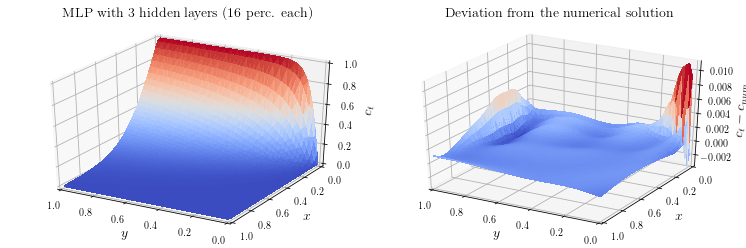

In [9]:
x_val = np.column_stack((field50.x, field50.y))
best_model_ind = np.argmin(lmax_norm)
best_model = models[best_model_ind]
print("Best model: ", names[best_model_ind])
filepath = "keras/" + names[best_model_ind] + "_best_weights.hdf5"
best_model.load_weights(filepath)
pred = best_model.predict(x_val)
plot_field_and_error(field50.x, field50.y, pred[:, 0], field50.A, "finalKerasModel.pdf",
                     ["MLP with 3 hidden layers (16 perc. each)", "Deviation from the numerical solution"])